# Importation des packages necessaires à l'étude 

In [2]:
# Import des packages
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import os
import sys
#from skimpy import skim
import matplotlib.pyplot as plt


sys.path.insert(0, str(Path(os.getcwd()).resolve().parent.parent))
from Churn_contrat_auto.src.utils.tools import (
    rename_field_categories,
    distrib_for_cat_by_target,
    distrib_for_cont_by_target,
    boxplot_by_target,
    plot_generic,
    cramers_v_between_all,
    cramers_v_with_target,
    graph_correlations,
    extract_corr_pairs,
)

In [3]:
import pandas as pd


In [41]:
display.max_columns = None

#### Objectif : cibler les clients qui vont résilier leur contrat auto

# 1. Import des données

In [42]:
# On se palce dans Churn_contrat_auto sur son terminal 
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt',
                 sep = '|',
                 encoding = 'latin1') # On rajoute l'encoding car ici nous ne sommes pas en utf8
df.head()

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_27020/456036584.py:2: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/raw/ResiliationContratAuto.txt',


NO_AFR  CDUSGAUT     IDECON  CD_AGT CD_FML CDPRGES  DTDBUCON  \
0  A00104001204707     611.0  205808992  A00104      R   4190A     14630   
1  A00104001270809     636.0  105939601  A00104      C   4190A     14701   
2  A00104001397301     611.0  306115473  A00104      C   4190A     14848   
3  A00104001402563     611.0  206122172  A00104      C   4190A     14861   
4  A00104716130632     603.0      35070  A00104      S   4190A      4018   

   DTEFTMVT  MMJECHPP  MTPAATTC  ... RESIV  RESDI  CLIACTIF         U  \
0     14812     121.0   1929.66  ...   NaN    NaN       OUI  0.630638   
1     14701     401.0   4106.44  ...   NaN    NaN       OUI  0.012901   
2     14848     826.0   4821.80  ...   0.0    0.0       OUI  0.417773   
3     14861     908.0   9460.74  ...   0.0    0.0       OUI  0.508437   
4     14707     407.0   1530.09  ...   NaN    NaN       OUI  0.615430   

   CONTRAT  ETAT MOTIFRSL COEFCOMM COEFPFLT  CRM  
0    ACTIF    CO      NaN      100   0.8500   50  
1    ACTIF    CO      NaN      100   0.7500   76  
2    ACTIF    CO      NaN      100   0.9000   95  
3    ACTIF    CO      NaN      100   0.9000   95  
4    ACTIF    CO      NaN       91   0.8065   50  

[5 rows x 58 columns]

In [30]:
print(f'Nb lignes : {len(df)}')
print(f'Nb champs : {len(df.columns)}')

Nb lignes : 90247
Nb champs : 58


In [31]:
print(df.CONTRAT.value_counts())
print(df.CONTRAT.value_counts()/df.shape[0])

CONTRAT
ACTIF    80117
RESIL    10130
Name: count, dtype: int64
CONTRAT
ACTIF    0.887753
RESIL    0.112247
Name: count, dtype: float64


📌 POINT : 
----------
- Notre dataframe contient 90247 et 58 colonnes. On peut directement avoir l'intuition qu'il faudra surement réaliser une sélection de variable afin de rendre notre modèle plus performants et eviter la multicolinéarité.
- La variable que nous cherchons à predire est la variable "CONTRAT". Cette dernière nous indique si un client est toujours assuré ou non. On remarque directement que notre cible est désequilibrée, avec majoritairement (90%) des clients actifs contre une minorité de clients résiliés (10%).


# 2. Compréhension des données

### Afin de rendre l'interpretation des résultats plus simple nous avons décidé de modifier le noms de variables de bases qui n'était pas forcement très parlant et mettre les bon type à nos variables: 

In [32]:
df.columns

Index(['NO_AFR', 'CDUSGAUT', 'IDECON', 'CD_AGT', 'CD_FML', 'CDPRGES',
       'DTDBUCON', 'DTEFTMVT', 'MMJECHPP', 'MTPAATTC', 'AUTO4R', 'NOCLIGES',
       'NUMFOY', 'CDMARVEH', 'DTOBTPDC', 'DTPMRMCI', 'LBMDLVH', 'NOTAREFF',
       'PUI_TRE', 'RN_VL_VH', 'S_2_N', 'S_3_N', 'S_1_N', 'S_0_N', 'S_3_O',
       'S_2_O', 'S_1_O', 'S_0_O', 'NIVBM', 'MTPAAREF', 'CDMCE', 'NBCTRES',
       'ANCCLI', 'CD_CSP', 'CD_SEX', 'DT_NAI', 'CDSITFAM', 'DEPT', 'REGION',
       'NBCTACT', 'AU4R', 'MH', 'DI', 'SA', 'IV', 'RESAU4R', 'RESMH', 'RESSA',
       'RESIV', 'RESDI', 'CLIACTIF', 'U', 'CONTRAT', 'ETAT', 'MOTIFRSL',
       'COEFCOMM', 'COEFPFLT', 'CRM'],
      dtype='object')

In [ ]:
renommage_vars = {
    "NO_AFR": "numero_affaire",
    "CDUSGAUT": "code_usage_auto",
    "IDECON": "id_contrat",
    "CD_AGT": "code_agent",
    "CD_FML": "code_formule",
    "CDPRGES": "code_produit_gestion",
    "DTDBUCON": "date_debut_contrat",
    "DTEFTMVT": "date_dernier_mouvement",
    "MMJECHPP": "echeance_contrat", #durée contrat
    "MTPAATTC": "prime_annuelle_ttc",
    "AUTO4R": "auto_4_roues",
    "NOCLIGES": "numero_client_gestion",
    "NUMFOY": "numero_foyer",
    "CDMARVEH": "code_marque_vehicule",
    "DTOBTPDC": "date_obtention_permis",
    "DTPMRMCI": "date_mise_circulation",
    "LBMDLVH": "libelle_modele_vehicule",
    "NOTAREFF": "numero_tarif",
    "PUI_TRE": "puissance_fiscale",
    "RN_VL_VH": "rang_valeur_vehicule",
    "S_2_N": "nb_sinistres_2_ans_non_resp",
    "S_3_N": "nb_sinistres_3_ans_non_resp",
    "S_1_N": "nb_sinistres_1_an_non_resp",
    "S_0_N": "nb_sinistres_0_an_non_resp",
    "S_3_O": "nb_sinistres_3_ans_resp",
    "S_2_O": "nb_sinistres_2_ans_resp",
    "S_1_O": "nb_sinistres_1_an_resp",
    "S_0_O": "nb_sinistres_0_an_resp",
    "NIVBM": "niveau_bonus_malus",
    "MTPAAREF": "prime_reference",
    "CDMCE": "code_marche",
    "NBCTRES": "nb_contrats_resilies",
    "ANCCLI": "anciennete_client",
    "CD_CSP": "code_csp",
    "CD_SEX": "sexe",
    "DT_NAI": "date_naissance",
    "CDSITFAM": "situation_familiale",
    "DEPT": "departement",
    "REGION": "region",
    "NBCTACT": "nb_contrats_actifs",
    "AU4R": "nb_contrats_actifs_auto",
    "MH": "nb_contrats_actifs_habitation",
    "DI": "nb_contrats_actifs_divers",
    "SA": "nb_contrats_actifs_sante",
    "IV": "nb_contrats_actifs_vie",
    "RESAU4R": "nb_contrats_auto_resilies",
    "RESMH": "nb_contrats_habitation_resilies",
    "RESSA": "nb_contrats_sante_resilies",
    "RESIV": "nb_contrats_vie_resilies",
    "RESDI": "nb_contrats_divers_resilies",
    "CLIACTIF": "client_actif",
    "U": "score_u",
    "CONTRAT": "contrat",
    "ETAT": "etat",
    "MOTIFRSL": "motif_resiliation",
    "COEFCOMM": "coefficient_commission",
    "COEFPFLT": "coefficient_profil_tarif",
    "CRM": "crm"
}


In [34]:
df.rename(columns=renommage_vars, inplace=True)

In [35]:
df.head()

numero_affaire  code_usage_auto  id_contrat code_agent code_formule  \
0  A00104001204707            611.0   205808992     A00104            R   
1  A00104001270809            636.0   105939601     A00104            C   
2  A00104001397301            611.0   306115473     A00104            C   
3  A00104001402563            611.0   206122172     A00104            C   
4  A00104716130632            603.0       35070     A00104            S   

  code_produit_gestion  date_debut_contrat  date_dernier_mouvement  \
0                4190A               14630                   14812   
1                4190A               14701                   14701   
2                4190A               14848                   14848   
3                4190A               14861                   14861   
4                4190A                4018                   14707   

   echeance_contrat  prime_annuelle_ttc  ... nb_contrats_vie_resilies  \
0             121.0             1929.66  ...                      NaN   
1             401.0             4106.44  ...                      NaN   
2             826.0             4821.80  ...                      0.0   
3             908.0             9460.74  ...                      0.0   
4             407.0             1530.09  ...                      NaN   

   nb_contrats_divers_resilies  client_actif   score_u  contrat  etat  \
0                          NaN           OUI  0.630638    ACTIF    CO   
1                          NaN           OUI  0.012901    ACTIF    CO   
2                          0.0           OUI  0.417773    ACTIF    CO   
3                          0.0           OUI  0.508437    ACTIF    CO   
4                          NaN           OUI  0.615430    ACTIF    CO   

  motif_resiliation coefficient_commission coefficient_profil_tarif  crm  
0               NaN                    100                   0.8500   50  
1               NaN                    100                   0.7500   76  
2               NaN                    100                   0.9000   95  
3               NaN                    100                   0.9000   95  
4               NaN                     91                   0.8065   50  

[5 rows x 58 columns]

In [36]:
df.info() # nous donne le type de stockage de chaque variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90247 entries, 0 to 90246
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   numero_affaire                   90247 non-null  object 
 1   code_usage_auto                  90231 non-null  float64
 2   id_contrat                       90247 non-null  int64  
 3   code_agent                       90247 non-null  object 
 4   code_formule                     89702 non-null  object 
 5   code_produit_gestion             90247 non-null  object 
 6   date_debut_contrat               90247 non-null  int64  
 7   date_dernier_mouvement           90247 non-null  int64  
 8   echeance_contrat                 90231 non-null  float64
 9   prime_annuelle_ttc               90247 non-null  float64
 10  auto_4_roues                     90247 non-null  object 
 11  numero_client_gestion            90247 non-null  int64  
 12  numero_foyer      

In [37]:
# Valeur distinctes pour chaques variables de notre df:
df_nunique = df.nunique().reset_index().rename(columns={'index':'Champ',0:'Nb_Distinct_Values'})\
                .sort_values('Nb_Distinct_Values',ascending=False)
df_nunique

Champ  Nb_Distinct_Values
51                          score_u               90247
0                    numero_affaire               90243
2                        id_contrat               90243
11            numero_client_gestion               88018
12                     numero_foyer               87025
9                prime_annuelle_ttc               79717
35                   date_naissance               22300
14            date_obtention_permis               15770
29                  prime_reference               14957
32                anciennete_client                9760
6                date_debut_contrat                8977
56         coefficient_profil_tarif                7692
16          libelle_modele_vehicule                6806
3                        code_agent                1255
7            date_dernier_mouvement                1093
15            date_mise_circulation                 557
8                  echeance_contrat                 365
13             code_marque_vehicule                 256
33                         code_csp                 234
37                      departement                 196
55           coefficient_commission                  99
57                              crm                  94
28               niveau_bonus_malus                  94
1                   code_usage_auto                  71
39               nb_contrats_actifs                  35
4                      code_formule                  25
44           nb_contrats_actifs_vie                  24
41    nb_contrats_actifs_habitation                  18
40          nb_contrats_actifs_auto                  18
19             rang_valeur_vehicule                  18
17                     numero_tarif                  17
31             nb_contrats_resilies                  16
54                motif_resiliation                  15
18                puissance_fiscale                  14
42        nb_contrats_actifs_divers                  14
45        nb_contrats_auto_resilies                  12
38                           region                  11
49      nb_contrats_divers_resilies                   8
46  nb_contrats_habitation_resilies                   8
43         nb_contrats_actifs_sante                   8
36              situation_familiale                   7
5              code_produit_gestion                   6
47       nb_contrats_sante_resilies                   6
21      nb_sinistres_3_ans_non_resp                   5
22       nb_sinistres_1_an_non_resp                   5
23       nb_sinistres_0_an_non_resp                   4
24          nb_sinistres_3_ans_resp                   4
20      nb_sinistres_2_ans_non_resp                   4
53                             etat                   4
25          nb_sinistres_2_ans_resp                   3
48         nb_contrats_vie_resilies                   3
26           nb_sinistres_1_an_resp                   3
27           nb_sinistres_0_an_resp                   3
50                     client_actif                   2
52                          contrat                   2
34                             sexe                   2
30                      code_marche                   2
10                     auto_4_roues                   1

💡 CONSTATS ET INTUITIONS : 
------

Nous allons supprimer les variables identifiants ou sans varaince : 
- La variable auto_4_roues ne nous apporte aucunes information car une modalité. Nous allons donc la supprimer.
- Nous avons supprimer numero_affaire, id_contrat, numero_client_gestion, numero_foyer.

Certaines variables de dates comme : date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement, echeance_contrat, echeance_contrat_periode, sont à transformer pour la suite. Par exemple obetnir des variables comme age, durée, etc


⚠️ On peut supposer qu'il faudra mettre les variables à moins de 10 modalité en categorielles. (Plus precisement les variables de "nombre" à moins de 10 modalités -> utile seulement dans le cas d'un modele de reg log)

On constate que beaucoup de nos variables ne semblent pas au bon type. Pour faciliter nos future interpretations (graphique) il est preferable de corriger ce problème des maintenant. 

In [38]:
df.drop(columns=['numero_affaire', 'id_contrat', "numero_client_gestion", "numero_foyer", "auto_4_roues"], inplace=True)

## 2.1 Variables de temps : 

In [39]:
var_date = ['date_debut_contrat', 'date_dernier_mouvement', 'date_obtention_permis', 'date_mise_circulation', 'date_naissance', 'anciennete_client']

In [40]:
df[var_date]

date_debut_contrat  date_dernier_mouvement  date_obtention_permis  \
0                   14630                   14812                10273.0   
1                   14701                   14701                12877.0   
2                   14848                   14848                14196.0   
3                   14861                   14861                14629.0   
4                    4018                   14707                    NaN   
...                   ...                     ...                    ...   
90242               13340                   14801                11197.0   
90243               13504                   14051                 9212.0   
90244               14335                   14335                 9303.0   
90245               14474                   14840                13559.0   
90246               11578                   14866                 9890.0   

       date_mise_circulation  date_naissance  anciennete_client  
0                    10683.0          3639.0            14598.0  
1                    11262.0          6093.0            14701.0  
2                     9678.0         -8391.0             8866.0  
3                    11870.0          7904.0            13872.0  
4                     5935.0         -3633.0             4018.0  
...                      ...             ...                ...  
90242                11323.0           -66.0            13340.0  
90243                10624.0          2181.0            13504.0  
90244                10897.0          2702.0            11401.0  
90245                10593.0          6627.0            13590.0  
90246                 7518.0          3167.0            11578.0  

[90247 rows x 6 columns]

💡 CONSTATS ET INTUITIONS (Analyse de date): 
------
On constate que nous sommes sur un format "non standard" pour des dates ! Ce ne sont pas des yyyymmdd, mais des jours depuis une origine (on peut supposer Excel). 

Les valeurs comme :

- 14812, 14630 pour date_debut_contrat → ressemblent à des jours depuis 1900 (comme dans Excel).

- -8391.0 pour date_naissance → indique que certaines dates sont avant la date d'origine.

Donc on est très probablement sur une date d'origine de 1900.

Mais il faut être vigilant car : Excel considère 1900 comme une année bissextile (ce qui est faux), donc il ajoute un jour fantôme.

Pandas ne fait pas cette erreur.

In [24]:
origin = pd.Timestamp("1970-01-01")
min_days = -40000   # environ l’an 1790 
max_days = 100000   # environ 2173

for col in var_date:
    # Ne garde que les valeurs valides dans la plage
    valid = df[col].between(min_days, max_days)
    
    # Convertit uniquement les valeurs valides, le reste devient NaT
    df[col] = pd.to_timedelta(np.where(valid, df[col], np.nan), unit="D") + origin

In [25]:
df[var_date]

date_debut_contrat date_dernier_mouvement date_obtention_permis  \
0             2010-01-21             2010-07-22            1998-02-16   
1             2010-04-02             2010-04-02            2005-04-04   
2             2010-08-27             2010-08-27            2008-11-13   
3             2010-09-09             2010-09-09            2010-01-20   
4             1981-01-01             2010-04-08                   NaT   
...                  ...                    ...                   ...   
90242         2006-07-11             2010-07-11            2000-08-28   
90243         2006-12-22             2008-06-21            1995-03-23   
90244         2009-04-01             2009-04-01            1995-06-22   
90245         2009-08-18             2010-08-19            2007-02-15   
90246         2001-09-13             2010-09-14            1997-01-29   

      date_mise_circulation date_naissance anciennete_client  
0                1999-04-02     1979-12-19        2009-12-20  
1                2000-11-01     1986-09-07        2010-04-02  
2                1996-07-01     1947-01-11        1994-04-11  
3                2002-07-02     1991-08-23        2007-12-25  
4                1986-04-02     1960-01-21        1981-01-01  
...                     ...            ...               ...  
90242            2001-01-01     1969-10-27        2006-07-11  
90243            1999-02-02     1975-12-22        2006-12-22  
90244            1999-11-02     1977-05-26        2001-03-20  
90245            1999-01-02     1988-02-23        2007-03-18  
90246            1990-08-02     1978-09-03        2001-09-13  

[90247 rows x 6 columns]

### Créer des variables de date

On va à présent créer des variables 

In [108]:
# Définir la date de référence comme la date la plus récente
date_reference = df['date_dernier_mouvement'].max() #on prends la date maximal rentrée dans la base de données
print(date_reference)

2010-12-01 00:00:00


1) on a crée la variable pour calculer l'âge du client 


In [ ]:
df['age_client'] = ((date_reference - df['date_naissance']).dt.days / 365.25).round(0)
print(df['age_client'])

#pourquoi créer cette variable ?

#1) l'âge est important pour analyser les comportements des clients
#ex : les jeunes résilients-ils plus souvent leurs contrats ?

#2) par exemple, les jeunes sont plus suceptible à faire des accidents, donc plus d'accidents, plus de sinistre 
#et donc suceptible de résilier 

0        31.0
1        24.0
2        64.0
3        19.0
4        51.0
         ... 
90242    41.0
90243    35.0
90244    34.0
90245    23.0
90246    32.0
Name: age_client, Length: 90026, dtype: float64


In [ ]:
print(df[df['age_client'] < 0]) #si on a des clients avec un age en 2020, on dit page négatif ou nul

Empty DataFrame
Columns: [code_usage_auto, code_agent, code_formule, code_produit_gestion, date_debut_contrat, date_dernier_mouvement, echeance_contrat, prime_annuelle_ttc, code_marque_vehicule, date_obtention_permis, date_mise_circulation, libelle_modele_vehicule, numero_tarif, puissance_fiscale, rang_valeur_vehicule, nb_sinistres_2_ans_non_resp, nb_sinistres_3_ans_non_resp, nb_sinistres_1_an_non_resp, nb_sinistres_0_an_non_resp, nb_sinistres_3_ans_resp, nb_sinistres_2_ans_resp, nb_sinistres_1_an_resp, nb_sinistres_0_an_resp, niveau_bonus_malus, prime_reference, code_marche, nb_contrats_resilies, anciennete_client, code_csp, sexe, date_naissance, situation_familiale, departement, region, nb_contrats_actifs, nb_contrats_actifs_auto, nb_contrats_actifs_habitation, nb_contrats_actifs_divers, nb_contrats_actifs_sante, nb_contrats_actifs_vie, nb_contrats_auto_resilies, nb_contrats_habitation_resilies, nb_contrats_sante_resilies, nb_contrats_vie_resilies, nb_contrats_divers_resilies, client

In [51]:
df['age_client'].isna().sum()

0

2) On calcule l'ancienneté du contrat 

In [46]:
df['anciennete_contrat'] = ((date_reference - df['date_debut_contrat']).dt.days / 365.25).round(1)
print(df['anciennete_contrat'])

0         0.9
1         0.7
2         0.3
3         0.2
4        29.9
         ... 
90242     4.4
90243     3.9
90244     1.7
90245     1.3
90246     9.2
Name: anciennete_contrat, Length: 90026, dtype: float64


In [52]:
df['anciennete_contrat'].isna().sum()

0

un contrat plus ancien peut être moins suceptible d'être résilié.

3. Ancienneté du permis

In [47]:
df['anciennete_permis'] = ((date_reference - df['date_obtention_permis']).dt.days / 365.25).round(1)
print(df['anciennete_permis'])

0        12.8
1         5.7
2         2.0
3         0.9
4         NaN
         ... 
90242    10.3
90243    15.7
90244    15.4
90245     3.8
90246    13.8
Name: anciennete_permis, Length: 90026, dtype: float64


In [55]:
df['date_obtention_permis'].isna().sum()

142

In [53]:
df['anciennete_permis'].isna().sum()

142

In [ ]:
#probléme de NaN dans la variable date_obtention_permis

Plus un client a de l'ancienneté de permis, plus il a de l'experience sur la route

4. Ancienneté du vehicule

In [50]:
df['age_vehicule'] = ((date_reference - df['date_mise_circulation']).dt.days / 365.25).round(1)
print(df['age_vehicule'])

0        11.7
1        10.1
2        14.4
3         8.4
4        24.7
         ... 
90242     9.9
90243    11.8
90244    11.1
90245    11.9
90246    20.3
Name: age_vehicule, Length: 90026, dtype: float64


Un véhicule plus ancien peut être plus sujet aux pannes, moins sécurisé, ou moins cher à assurer. Un véhicule récent peut être plus coûteux à réparer ou plus souvent sous garantie.

⚠️ On aurait pu aussi appliquer ces changements à la variable "echeance_contrat" mais nous ne l'avons pas faire car cette variables semble etre le nombre de jours du contrat. 

#### 2.2.2 Analyse d'anomalies de date

##### 2.2.2.1 Vérification d'éventuelles anomalies sur les variables de date

#### 2.1.2 Types variables catégorielles : 

In [96]:
var_cat = ["code_usage_auto", "code_agent", "code_formule", "code_produit_gestion", "code_marque_vehicule", "libelle_modele_vehicule", "numero_tarif", "rang_valeur_vehicule", "code_marche", "code_csp", "sexe", "situation_familiale", "departement", "region", "client_actif", "contrat", "etat", "motif_resiliation", "crm"]

In [98]:
df[var_cat] = df[var_cat].astype("category")

In [99]:
df[var_cat].nunique()

code_usage_auto              71
code_agent                 1254
code_formule                 25
code_produit_gestion          6
code_marque_vehicule        256
libelle_modele_vehicule    6795
numero_tarif                 17
rang_valeur_vehicule         18
code_marche                   2
code_csp                    234
sexe                          2
situation_familiale           7
departement                 196
region                       11
client_actif                  2
contrat                       2
etat                          4
motif_resiliation            15
crm                          94
dtype: int64

In [100]:
var_cat.remove('contrat')

In [101]:
df[df['date_debut_contrat']>df['date_dernier_mouvement']].shape[0] 

0

In [102]:
# Voir si réellement bizarre (pas compris)
df[df['date_mise_circulation']>df['date_debut_contrat']][['date_debut_contrat', 'date_mise_circulation']]

date_debut_contrat date_mise_circulation
4             1981-01-01            1986-04-02
5             1989-02-23            2001-10-01
6             1989-09-03            1996-01-02
7             1992-02-14            1992-12-01
8             1993-05-09            2007-05-02
...                  ...                   ...
90207         2004-02-11            2009-11-01
90215         2007-08-02            2007-12-02
90229         1969-09-25            2009-01-01
90230         1990-11-30            1996-12-01
90241         2001-10-23            2003-05-02

[32789 rows x 2 columns]

In [103]:
# Voir si réellement bizarre : Possibilité que le client soit enfaite le fils d'un client qui avait deja pris un contrat
df[df['date_naissance']>df['date_debut_contrat']][['date_debut_contrat', 'date_naissance']]

Empty DataFrame
Columns: [date_debut_contrat, date_naissance]
Index: []

In [104]:
df = df[df['date_naissance']<df['date_debut_contrat']]

In [105]:
# Les variables comme date_debut_contrat et anciennete_client sont souvent tres proches. Vérifier si l'ecart n'est jamais supérieur à 1an. Dans quel cas on pourra garder qu'une des deux variables :
df[df['date_debut_contrat']-df['anciennete_client']< pd.Timedelta(365)][['date_debut_contrat', 'anciennete_client']]

date_debut_contrat anciennete_client
1             2010-04-02        2010-04-02
4             1981-01-01        1981-01-01
5             1989-02-23        1989-02-23
7             1992-02-14        1992-02-14
8             1993-05-09        1993-05-09
...                  ...               ...
90239         2001-04-15        2001-04-15
90241         2001-10-23        2001-10-23
90242         2006-07-11        2006-07-11
90243         2006-12-22        2006-12-22
90246         2001-09-13        2001-09-13

[33826 rows x 2 columns]

In [106]:
df_resil = df[df['contrat']=='RESIL']

In [ ]:
# Vérifie et affiche les anomalies logiques entre les dates
anomalies = {
    "naissance_apres_permis": df[df["date_naissance"] > df["date_obtention_permis"]],
    "permis_apres_mise_circulation": df[df["date_obtention_permis"] > df["date_mise_circulation"]],
    "mise_circulation_apres_contrat": df[df["date_mise_circulation"] > df["date_debut_contrat"]],
    "naissance_apres_contrat": df[df["date_naissance"] > df["date_debut_contrat"]],
    "naissance_apres_dernier_mouvement": df[df["date_naissance"] > df["date_dernier_mouvement"]],
    "contrat_apres_dernier_mouvement": df[df["date_debut_contrat"] > df["date_dernier_mouvement"]],
}


for desc, subset in anomalies.items():
    print(f"\nAnomalie détectée : {desc} ({len(subset)} lignes)")
    display(subset[['date_naissance', 'date_obtention_permis', 'date_mise_circulation',
                    'date_debut_contrat', 'date_dernier_mouvement']].head())



Anomalie détectée : naissance_apres_permis (207 lignes)


date_naissance date_obtention_permis date_mise_circulation  \
469      1985-01-07            1979-02-03            2009-09-01   
584      1982-06-05            1976-12-02            2003-11-02   
1204     1979-05-08            1967-10-04            2004-07-01   
1421     1981-04-21            1971-10-10            1999-12-02   
1442     1991-12-24            1989-08-02            2001-02-01   

     date_debut_contrat date_dernier_mouvement  
469          2007-04-24             2010-04-24  
584          2002-01-17             2010-07-08  
1204         2001-01-01             2010-07-02  
1421         2006-09-03             2010-03-03  
1442         2010-05-27             2010-05-27


Anomalie détectée : permis_apres_mise_circulation (16835 lignes)


date_naissance date_obtention_permis date_mise_circulation  \
1      1986-09-07            2005-04-04            2000-11-01   
2      1947-01-11            2008-11-13            1996-07-01   
3      1991-08-23            2010-01-20            2002-07-02   
27     1974-03-23            2005-08-07            2000-03-01   
30     1981-11-09            2002-07-28            1994-12-02   

   date_debut_contrat date_dernier_mouvement  
1          2010-04-02             2010-04-02  
2          2010-08-27             2010-08-27  
3          2010-09-09             2010-09-09  
27         2000-04-12             2010-07-13  
30         2002-08-22             2010-05-22


Anomalie détectée : mise_circulation_apres_contrat (32789 lignes)


date_naissance date_obtention_permis date_mise_circulation  \
4     1960-01-21                   NaT            1986-04-02   
5     1937-02-01            1978-02-01            2001-10-01   
6     1946-12-26            1969-05-01            1996-01-02   
7     1971-12-02            1992-01-02            1992-12-01   
8     1937-11-01            1962-08-13            2007-05-02   

  date_debut_contrat date_dernier_mouvement  
4         1981-01-01             2010-04-08  
5         1989-02-23             2010-04-08  
6         1989-09-03             2010-04-08  
7         1992-02-14             2010-05-08  
8         1993-05-09             2010-07-08


Anomalie détectée : naissance_apres_contrat (0 lignes)


Empty DataFrame
Columns: [date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement]
Index: []


Anomalie détectée : naissance_apres_dernier_mouvement (0 lignes)


Empty DataFrame
Columns: [date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement]
Index: []


Anomalie détectée : contrat_apres_dernier_mouvement (0 lignes)


Empty DataFrame
Columns: [date_naissance, date_obtention_permis, date_mise_circulation, date_debut_contrat, date_dernier_mouvement]
Index: []

⚠️ Revoir cela !
* Date fin contrat :

Si le contrat n'est plus actif alors on peut calculer sa date de fin de contart grace à la date de debut et l'echeance contrat.

In [ ]:
# Obtenir la date de fin de contrat potentiel 
df['date_fin_contrat'] = df_resil['date_debut_contrat'] + pd.to_timedelta(df_resil['echeance_contrat'], unit='D')

In [ ]:
df[df['date_fin_contrat']>df['date_dernier_mouvement']].shape[0] 

In [ ]:
df[df['date_obtention_permis'] > date_reference]

⚠️ Il ne semlble pas réellement possible d'avoir une date de fin de contrat ainsi. L'echeance_contrat semble etre une durée arbitraire.

💡 CONSTATS ET INTUITIONS : 
------
Certaines variables catégorielles ont beaucoup trop de modalités pour etre representées graphiquement. Nous alors donc representer celles qui comportent un nombre de modalités raisonnables.

In [ ]:
for col in df[var_cat].columns:
    print(df[col].value_counts())

code_usage_auto
611.0    38575
603.0    11991
601.0     8493
613.0     5142
624.0     5022
         ...  
116.0        1
115.0        1
108.0        1
640.0        1
610.0        1
Name: count, Length: 71, dtype: int64
code_agent
A00676    524
A12530    521
A18220    414
A22230    327
A04729    314
         ... 
A26310      1
A26210      1
A11823      1
A12811      1
L00005      1
Name: count, Length: 1255, dtype: int64
code_formule
T     37944
C     22404
S     18289
R      4336
D      4271
E      2242
P        54
G        33
L        26
1X       22
K        16
7X       12
3X       12
N        11
H         9
A         5
6         5
B         2
1N        2
3         2
7K        1
7H        1
M         1
5F        1
1J        1
Name: count, dtype: int64
code_produit_gestion
4190A    89973
4011A      149
4001A       60
4199G       31
4010A       20
4100A       14
Name: count, dtype: int64
code_marque_vehicule
RENAULT       27666
PEUGEOT       18527
CITROEN       12011
FORD           5465

#### 2.1.3 Types variables continues : 

Pour les variables continues non n'allons pas changer les types pour l'instant du aux valeurs manquantes. Cela ne posera pas de problèmes pour notre analyse graphique.

In [57]:
var_num = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

### 2.2 Statistiques descriptives 

In [56]:
skim(df)

NameError: name 'skim' is not defined

#### 2.2.1 Analyse des Nan en fonction de la variable cible 

In [58]:
# Dataframe contenant toutes les lignes où se trouvent au moins une NaN
df_nan = df[df.isna().any(axis=1)].copy(deep=True)
df_nan

code_usage_auto code_agent code_formule code_produit_gestion  \
0                611.0     A00104            R                4190A   
1                636.0     A00104            C                4190A   
2                611.0     A00104            C                4190A   
3                611.0     A00104            C                4190A   
4                603.0     A00104            S                4190A   
...                ...        ...          ...                  ...   
90242            609.0     L00004            S                4190A   
90243            611.0     L00004            C                4190A   
90244            611.0     L00004            C                4190A   
90245            613.0     L00004            C                4190A   
90246            668.0     L00005          NaN                4190A   

      date_debut_contrat date_dernier_mouvement  echeance_contrat  \
0             2010-01-21             2010-07-22             121.0   
1             2010-04-02             2010-04-02             401.0   
2             2010-08-27             2010-08-27             826.0   
3             2010-09-09             2010-09-09             908.0   
4             1981-01-01             2010-04-08             407.0   
...                  ...                    ...               ...   
90242         2006-07-11             2010-07-11             710.0   
90243         2006-12-22             2008-06-21             621.0   
90244         2009-04-01             2009-04-01             401.0   
90245         2009-08-18             2010-08-19             818.0   
90246         2001-09-13             2010-09-14             913.0   

       prime_annuelle_ttc code_marque_vehicule date_obtention_permis  ...  \
0                 1929.66              PEUGEOT            1998-02-16  ...   
1                 4106.44              PEUGEOT            2005-04-04  ...   
2                 4821.80              PEUGEOT            2008-11-13  ...   
3                 9460.74              RENAULT            2010-01-20  ...   
4                 1530.09             MERCEDES                   NaT  ...   
...                   ...                  ...                   ...  ...   
90242             1290.36                 FORD            2000-08-28  ...   
90243             2521.50              CITROEN            1995-03-23  ...   
90244             1814.34              PEUGEOT            1995-06-22  ...   
90245             2700.12              PEUGEOT            2007-02-15  ...   
90246              412.60              RENAULT            1997-01-29  ...   

      contrat etat motif_resiliation coefficient_commission  \
0       ACTIF   CO               NaN                    100   
1       ACTIF   CO               NaN                    100   
2       ACTIF   CO               NaN                    100   
3       ACTIF   CO               NaN                    100   
4       ACTIF   CO               NaN                     91   
...       ...  ...               ...                    ...   
90242   ACTIF   CO               NaN                    100   
90243   ACTIF   CO               NaN                     98   
90244   ACTIF   CO               NaN                     95   
90245   ACTIF   CO               NaN                     77   
90246   RESIL   RL               1.0                    100   

       coefficient_profil_tarif  crm  age_client  anciennete_contrat  \
0                        0.8500   50        31.0                 0.9   
1                        0.7500   76        24.0                 0.7   
2                        0.9000   95        64.0                 0.3   
3                        0.9000   95        19.0                 0.2   
4                        0.8065   50        51.0                29.9   
...                         ...  ...         ...                 ...   
90242                    0.9562   50        41.0                 4.4   
90243                    0.8100   66        35.0                 3.

#### 2.2.2 Création de variables pertinentes à partir des variables de temps

In [ ]:
df[var_date]

date_debut_contrat date_dernier_mouvement date_obtention_permis  \
0             1940-01-22             1940-07-22            1928-02-17   
1             1940-04-02             1940-04-02            1935-04-05   
2             1940-08-27             1940-08-27            1938-11-14   
3             1940-09-09             1940-09-09            1940-01-21   
4             1911-01-02             1940-04-08                   NaT   
...                  ...                    ...                   ...   
90242         1936-07-11             1940-07-11            1930-08-29   
90243         1936-12-22             1938-06-22            1925-03-23   
90244         1939-04-02             1939-04-02            1925-06-22   
90245         1939-08-19             1940-08-19            1937-02-15   
90246         1931-09-14             1940-09-14            1927-01-30   

      date_mise_circulation date_naissance anciennete_client  
0                1929-04-02     1909-12-19        1939-12-21  
1                1930-11-02     1916-09-07        1940-04-02  
2                1926-07-02     1877-01-10        1924-04-11  
3                1932-07-02     1921-08-23        1937-12-25  
4                1916-04-02     1890-01-20        1911-01-02  
...                     ...            ...               ...  
90242            1931-01-02     1899-10-27        1936-07-11  
90243            1929-02-02     1905-12-22        1936-12-22  
90244            1929-11-02     1907-05-27        1931-03-21  
90245            1929-01-02     1918-02-23        1937-03-18  
90246            1920-08-02     1908-09-03        1931-09-14  

[90026 rows x 6 columns]

- Création de la variable age

In [ ]:
df['age'] = (df['date_debut_contrat'] - df['date_naissance']).dt.days // 365
df['age'].describe()

count    90026.000000
mean        40.349699
std         13.849087
min          0.000000
25%         29.000000
50%         39.000000
75%         50.000000
max        137.000000
Name: age, dtype: float64

In [ ]:
df[df['age']==0]

code_usage_auto code_agent code_formule code_produit_gestion  \
40927            611.0     A12838            S                4190A   
59452            621.0     A17171            C                4190A   

      date_debut_contrat date_dernier_mouvement  echeance_contrat  \
40927         1925-03-31             1939-10-08            1007.0   
59452         1922-04-09             1940-07-08             707.0   

       prime_annuelle_ttc auto_4_roues code_marque_vehicule  ...  \
40927              739.15            O                 FIAT  ...   
59452             2062.60            O              RENAULT  ...   

      nb_contrats_divers_resilies client_actif   score_u contrat etat  \
40927                         NaN          OUI  0.032238   ACTIF   CO   
59452                         NaN          OUI  0.206655   ACTIF   CO   

       motif_resiliation  coefficient_commission  coefficient_profil_tarif  \
40927                NaN                      98                    1.1067   
59452                NaN                     100                    1.0241   

       crm  age  
40927   50    0  
59452   50    0  

[2 rows x 55 columns]

⚠️ voir si enlever les ages à 0 

In [ ]:
df[df['age']==137]

code_usage_auto code_agent code_formule code_produit_gestion  \
60409            601.0     A17540            T                4190A   

      date_debut_contrat date_dernier_mouvement  echeance_contrat  \
60409         1934-04-20             1940-04-20             419.0   

       prime_annuelle_ttc auto_4_roues code_marque_vehicule  ...  \
60409             5472.52            O              PEUGEOT  ...   

      nb_contrats_divers_resilies client_actif   score_u contrat etat  \
60409                         0.0          OUI  0.502175   ACTIF   CO   

       motif_resiliation  coefficient_commission  coefficient_profil_tarif  \
60409                NaN                      95                    0.7967   

       crm  age  
60409   50  137  

[1 rows x 55 columns]

⚠️ voir si enlever les ages à 137

- Création de variable de durée 

⚠️ Je ne sais pas si on calcule nos durée en fonction de la date de debut de contrat ou de la date actuelles (sachant que les dates me semblent tres anciennes pour faire par rapport à la date actuelle)

In [ ]:
df['anciennete_permis'] = (df['date_debut_contrat'] - df['date_obtention_permis']).dt.days // 365
df['anciennete_permis'].describe()
# il y a des valeurs négatives, cela est possible si le client a pris un contrat avant d'avoir son permis
# Cependant il y a des valeurs très élevées (31 ans d'ecart), il faut donc les traiter
# On pourrait aussi créer une variable binaire qui indique si le client a son permis avant de prendre le contrat ou apres

count    89884.000000
mean        15.350285
std         12.484691
min        -35.000000
25%          5.000000
50%         14.000000
75%         24.000000
max         74.000000
Name: anciennete_permis, dtype: float64

In [ ]:
df['age_vehicule'] = (df['date_debut_contrat'] - df['date_mise_circulation']).dt.days // 365
df['age_vehicule'].describe()
# Il y a des valeurs négatives, cela est possible si le client roulait sans assurance ou etait dans une autre assurance
# Créer une variable binaire qui indique si le client a son vehicule avant de prendre le contrat ou apres

count    89097.000000
mean         1.037790
std          9.400395
min        -68.000000
25%         -4.000000
50%          2.000000
75%          7.000000
max         94.000000
Name: age_vehicule, dtype: float64

In [ ]:
df['temps_depuis_dernier_mvt'] = (df['date_fin_contrat']  - df['date_dernier_mouvement']).dt.days


In [ ]:
df['temps_depuis_dernier_mvt'].describe()
# Résultats bizarre car variable fin_contrat est la date de fin de contrat potentiel et non réelle

count    90010.000000
mean     -2134.587213
std       2646.433350
min     -24566.000000
25%      -3382.750000
50%      -1497.000000
75%       -129.000000
max       1231.000000
Name: temps_depuis_dernier_mvt, dtype: float64

#### 2.3.2 Création de variables pertinentes à partir des variables catégorielles

In [ ]:
# créer une vairable zone a partir de la variable region. Dire si c'est une zone rurale ou urbaine par exemple

### 2.4 Representation graphique de chaque variable

#### 2.4.1 Variables continues

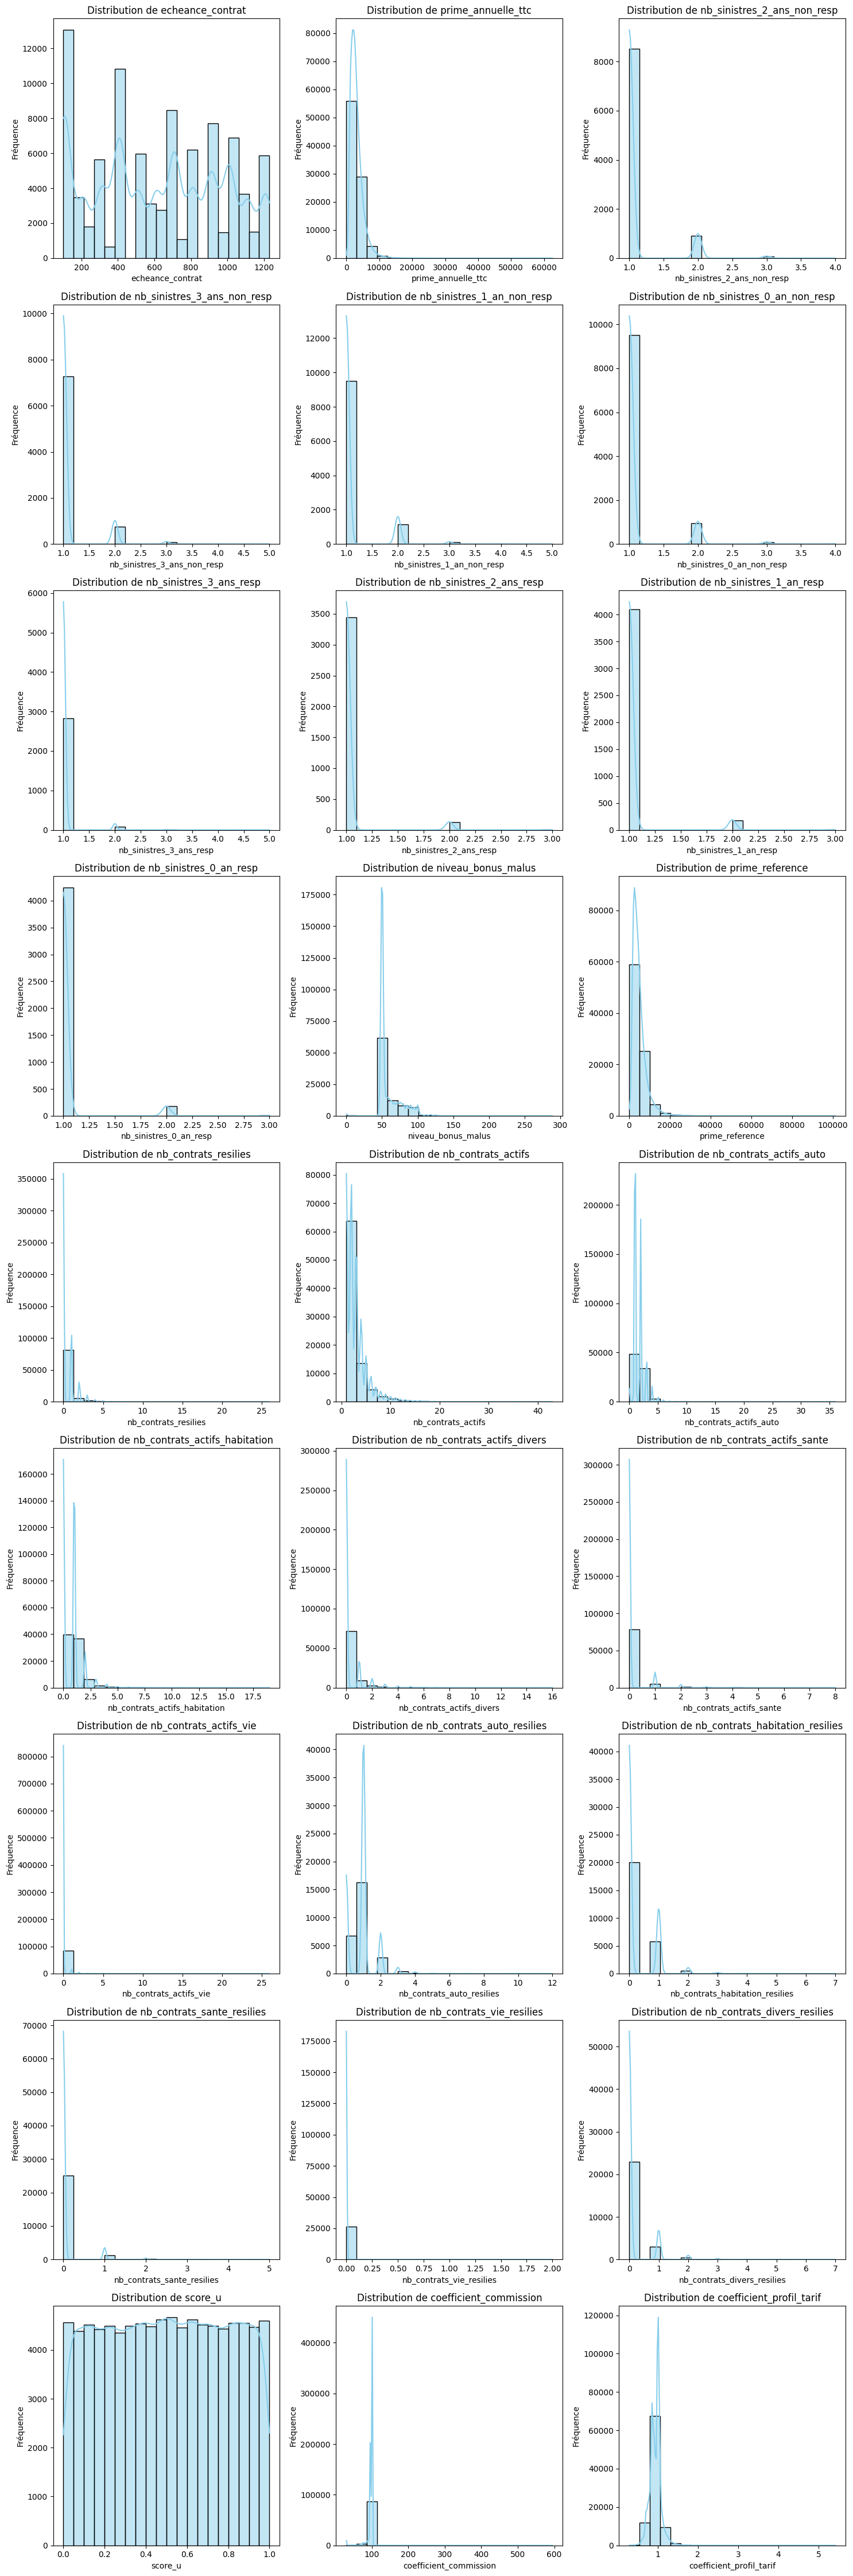

In [ ]:
n_cols = 3
n_rows = (len(var_num) + n_cols - 1) // n_cols  

plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i, col in enumerate(var_num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

⚠️ est ce que mettre les variables de nombre en variables catégorielles ? Pour les modèles basés sur les arbres cela ne risque pas de poser de problèmes mais pour les autres modèle comme logistique je pense. Pour l'instant je pense rien faire. 

#### 2.4.2 Variables de durée

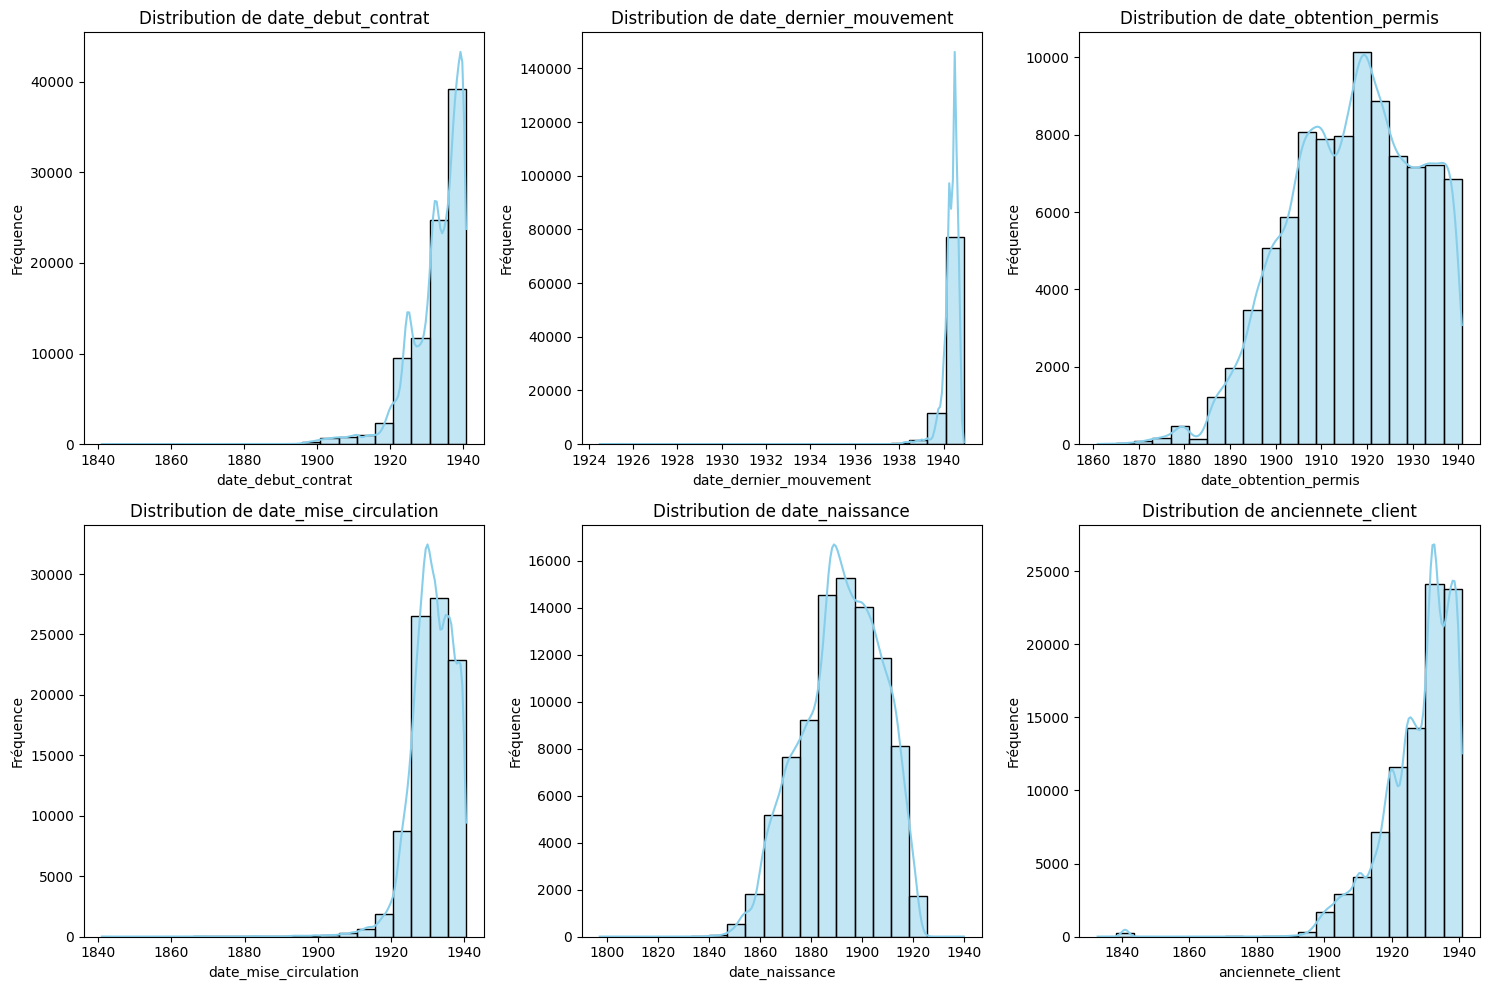

In [ ]:
n_cols = 3
n_rows = (len(var_date) + n_cols - 1) // n_cols  

plt.figure(figsize=(n_cols * 5, n_rows * 5))

for i, col in enumerate(var_date):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

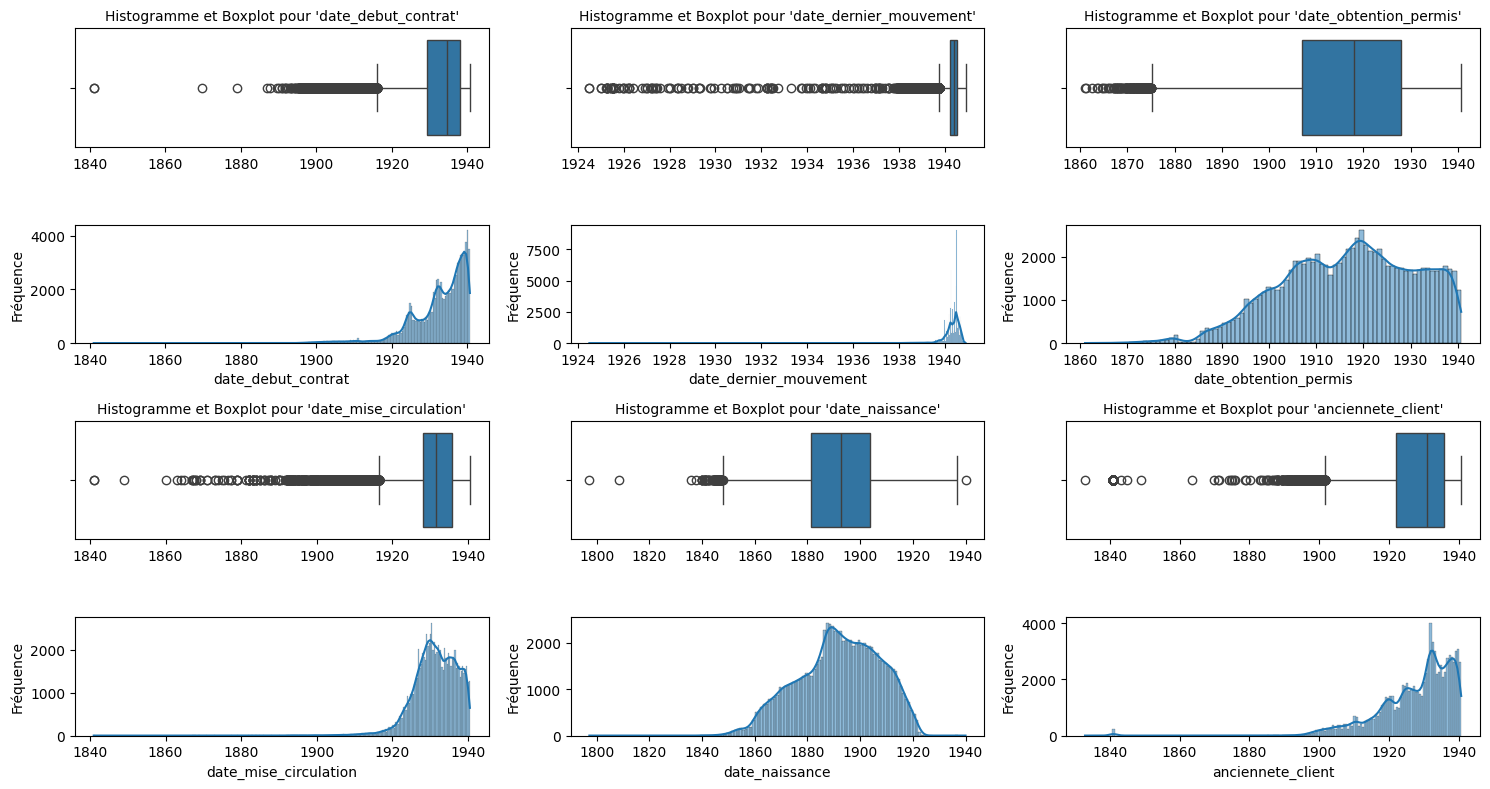

In [ ]:
def hist_box(data, var, ax_box, ax_hist):
    # Boxplot
    sns.boxplot(data=data, x=var, ax=ax_box)
    ax_box.set(xlabel='')
    ax_box.set_title(f"Histogramme et Boxplot pour '{var}'", fontsize=10)

    # Histogramme
    sns.histplot(data=data, x=var, kde=True, ax=ax_hist)
    ax_hist.set(xlabel=var, ylabel='Fréquence')



n_cols = 3
n_rows = (len(var_date) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows * 2, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False)

if n_rows * 2 == 1:
    axes = [axes]

for idx, var in enumerate(var_date):
    row = (idx // n_cols) * 2  # Ligne du subplot (box + hist)
    col = idx % n_cols

    ax_box = axes[row][col]
    ax_hist = axes[row + 1][col]

    hist_box(df, var, ax_box, ax_hist)

total_slots = n_rows * n_cols
for idx in range(len(var_date), total_slots):
    row = (idx // n_cols) * 2
    col = idx % n_cols
    axes[row][col].axis('off')
    axes[row + 1][col].axis('off')

plt.tight_layout()
plt.show()


⚠️ Dis moi les graph que tu pref pour les variables continues.

#### 2.4.3 Variables catégorielles

In [ ]:
# Retirer les variables catégorielles qui ne sont pas pertinentes pour l'analyse :
var_cat_graph = [col for col in var_cat if df[col].nunique() < 50]
df[var_cat_graph]

code_formule code_produit_gestion numero_tarif rang_valeur_vehicule  \
0                R                4190A        BL050                  5.0   
1                C                4190A        BL064                 10.0   
2                C                4190A        BL100                  4.0   
3                C                4190A        BL100                 10.0   
4                S                4190A        BL064                 15.0   
...            ...                  ...          ...                  ...   
90242            S                4190A        BL050                  8.0   
90243            C                4190A        BL064                  8.0   
90244            C                4190A        BL064                  6.0   
90245            C                4190A        BL090                  3.0   
90246          NaN                4190A        BL999                  9.0   

      code_marche sexe situation_familiale region client_actif etat  \
0               P    F                   M     RA          OUI   CO   
1               P    M                   M     RA          OUI   CO   
2               P    M                   M     RA          OUI   CO   
3               P    M                   C     RA          OUI   CO   
4               P    M                   M     RA          OUI   CO   
...           ...  ...                 ...    ...          ...  ...   
90242           P    F                   A     MM          OUI   CO   
90243           P    M                   C     MM          OUI   CO   
90244           P    M                   M     NE          OUI   CO   
90245           P    F                   C     NE          OUI   CO   
90246           P    M                   M     PA          NON   RL   

      motif_resiliation  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
90242               NaN  
90243               NaN  
90244               NaN  
90245               NaN  
90246               1.0  

[90247 rows x 11 columns]

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_9986/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_9986/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_9986/956134913.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='Set2')
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_9986/956

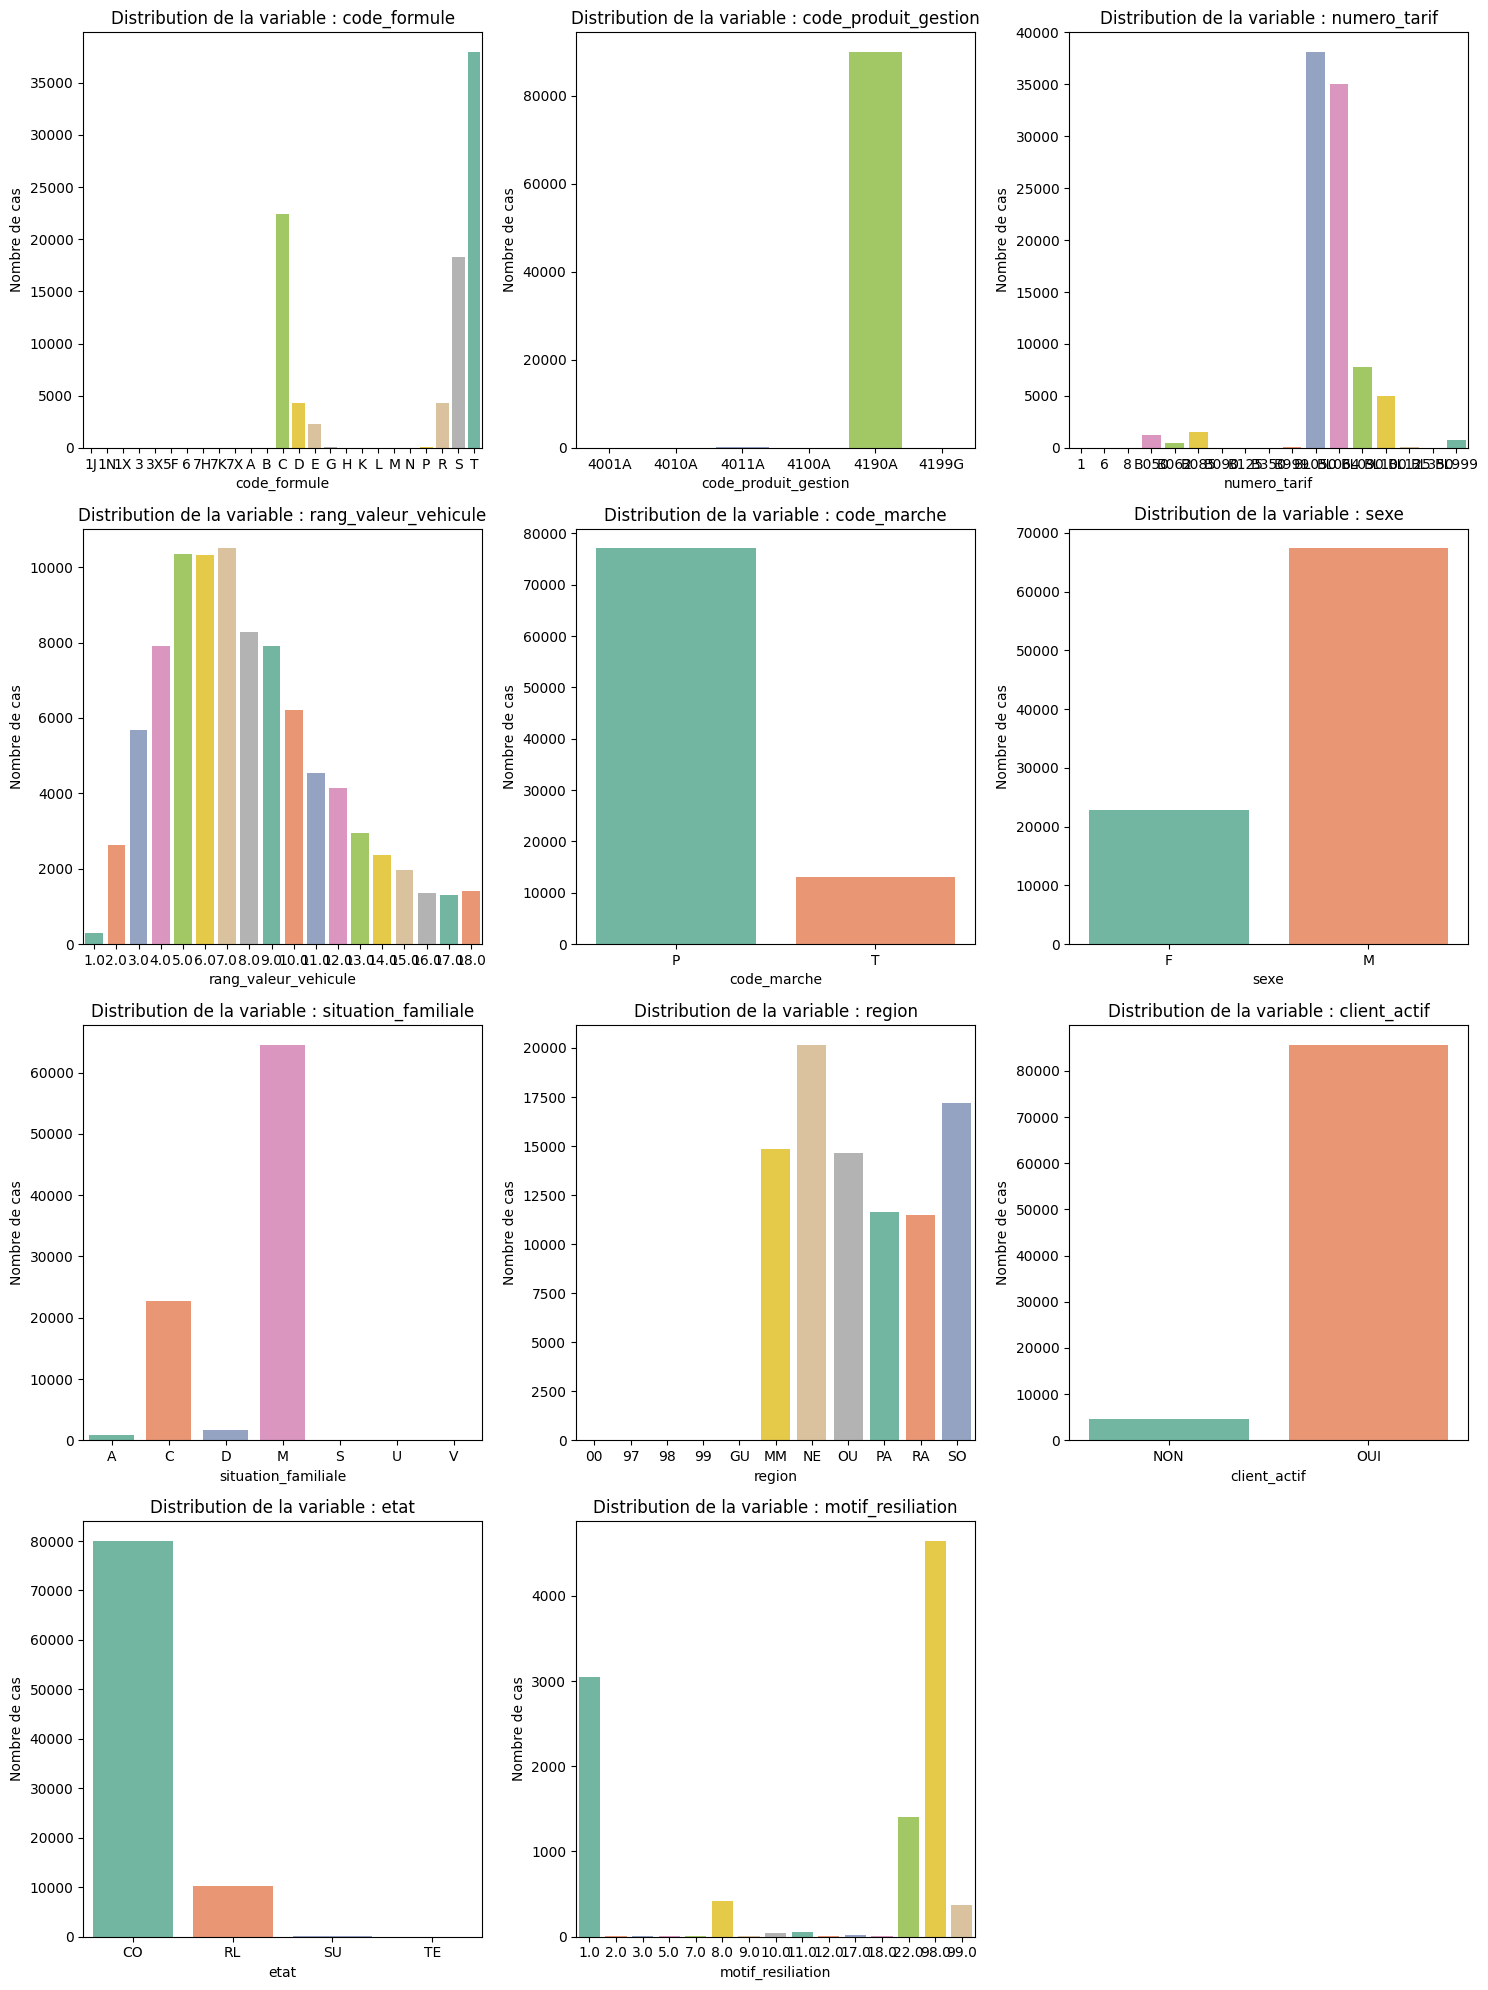

In [ ]:
n_cols = 3
n_rows = (len(var_cat_graph) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

plt.figure(figsize=(n_cols * 5, n_rows * 5))  
for i, col in enumerate(var_cat_graph):
    plt.subplot(n_rows, n_cols, i + 1)  
    sns.countplot(x=col, data=df, palette='Set2')  
    plt.title(f'Distribution de la variable : {col}')
    plt.xlabel(col)
    plt.ylabel('Nombre de cas')

plt.tight_layout() 
plt.show()


### 2.5 Representation graphique de chaque variable en fonction de la variable cible 

#### 2.5.1 Représentations graphiques des catégorielles par rapport à la cible

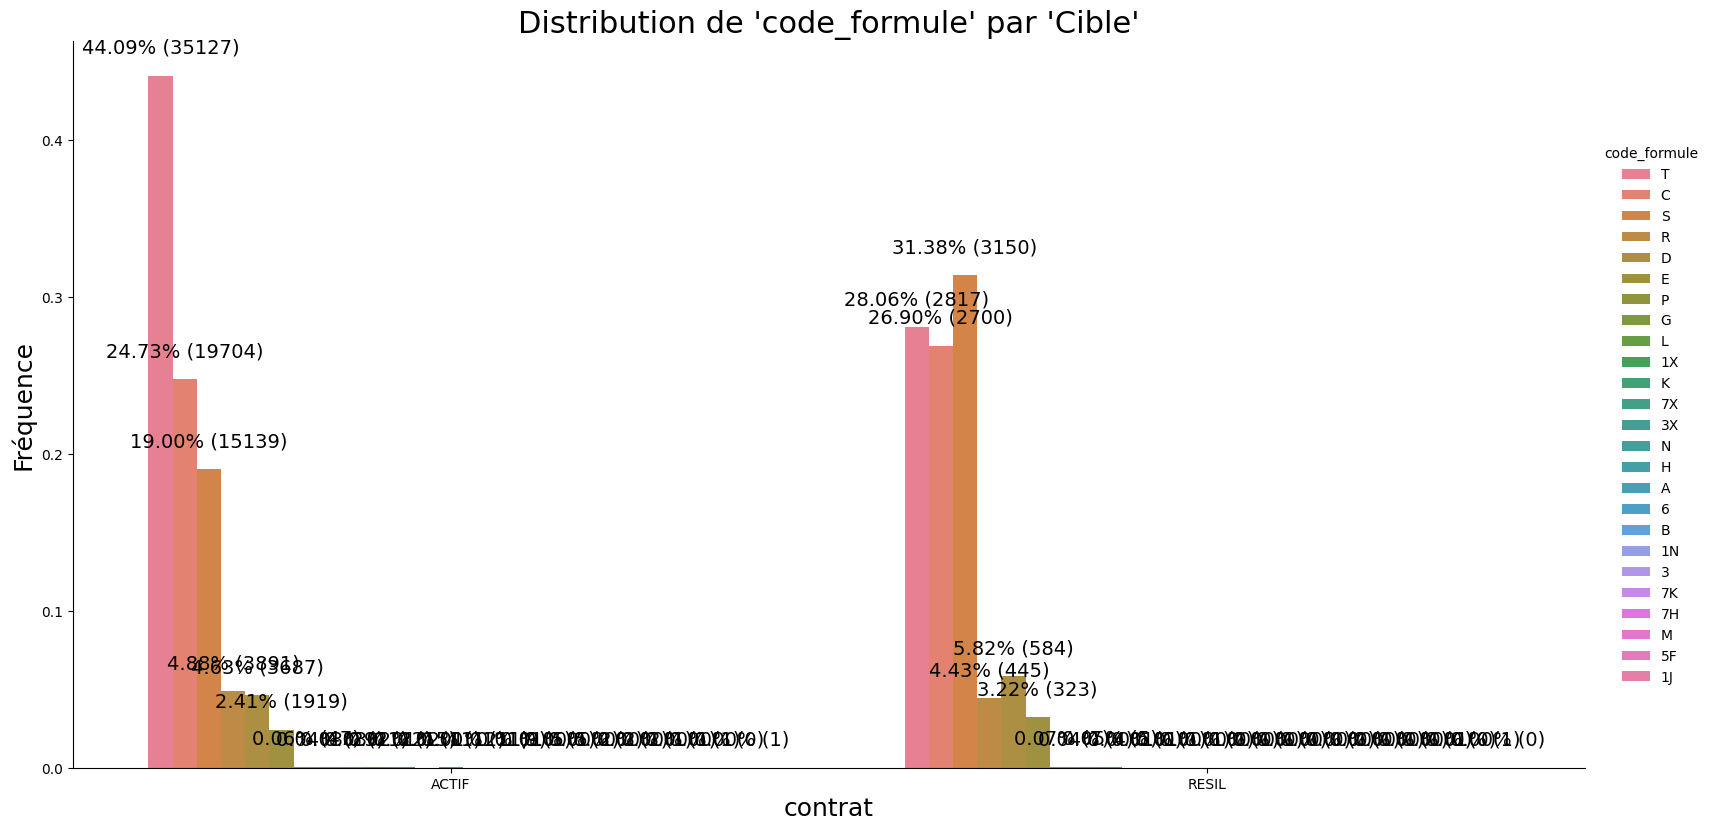

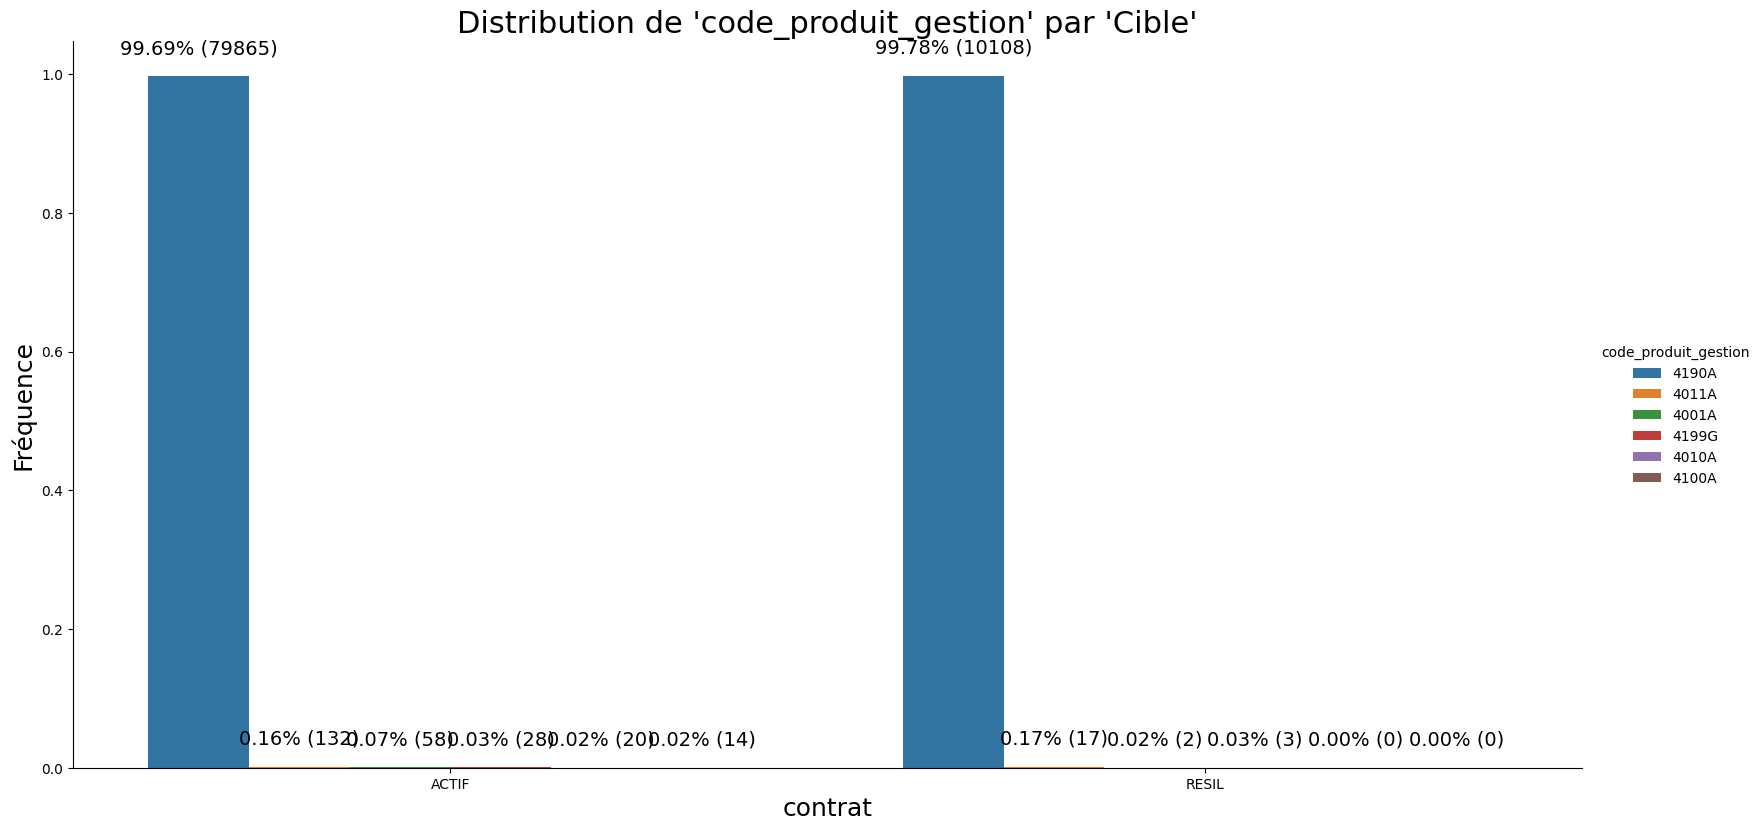

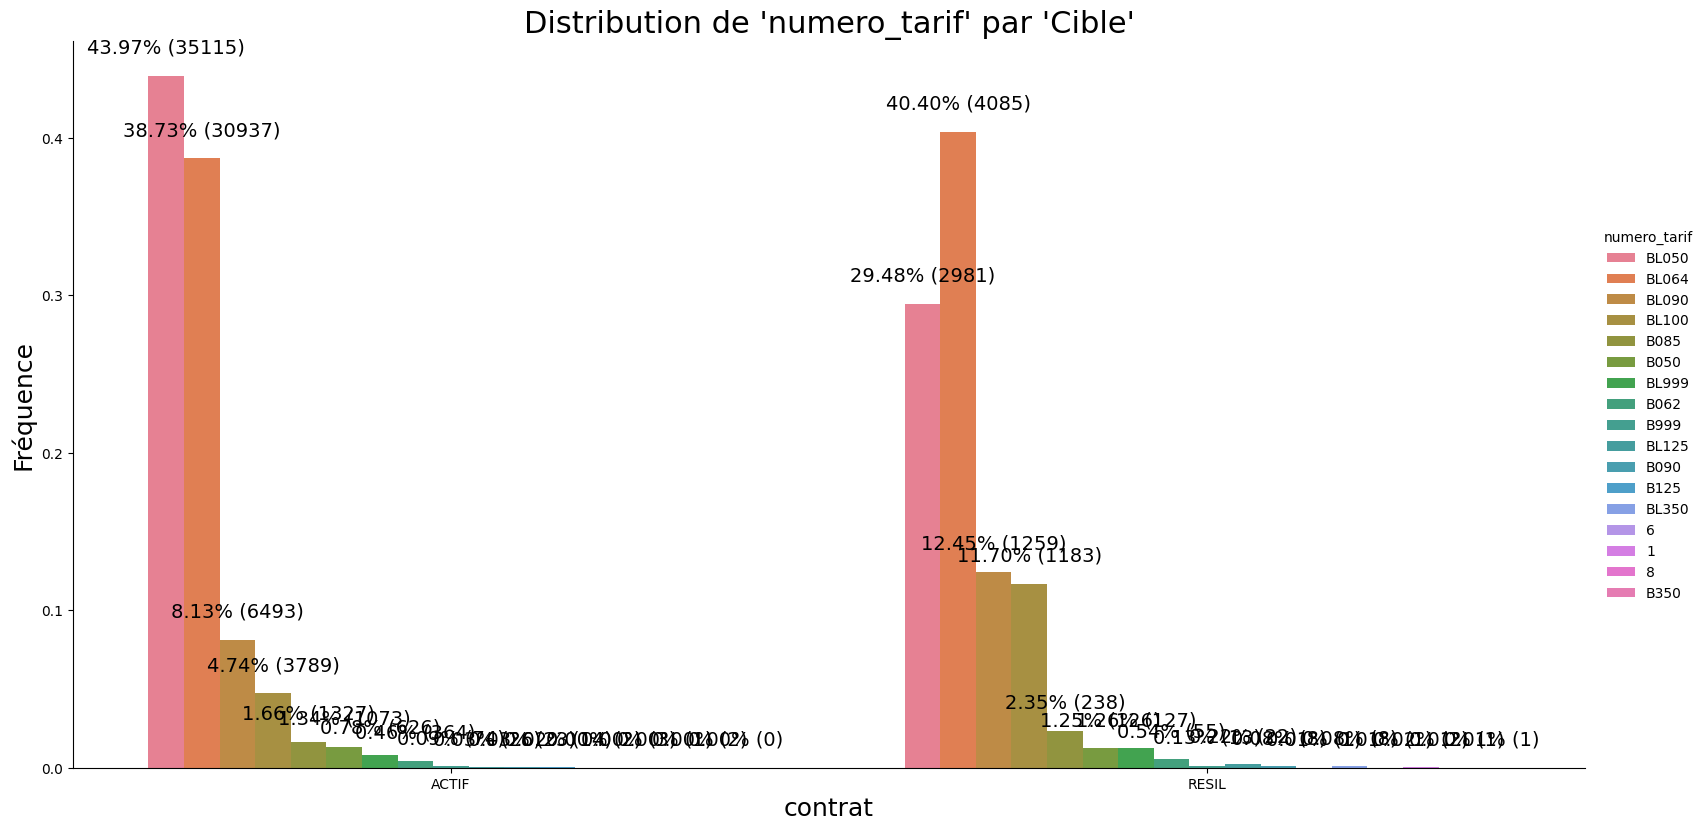

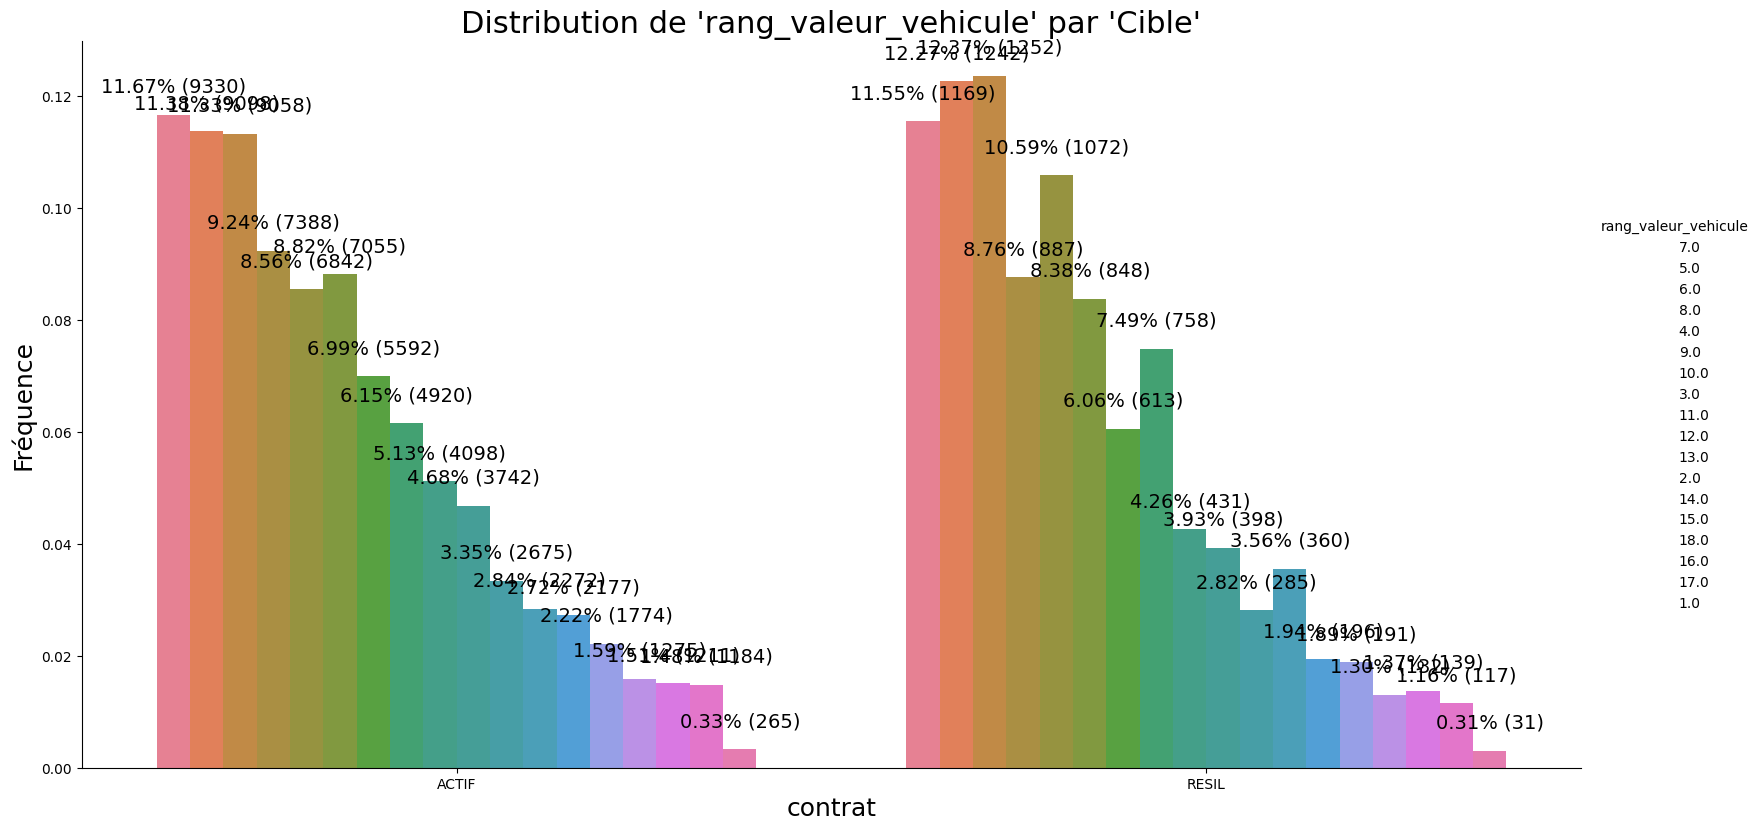

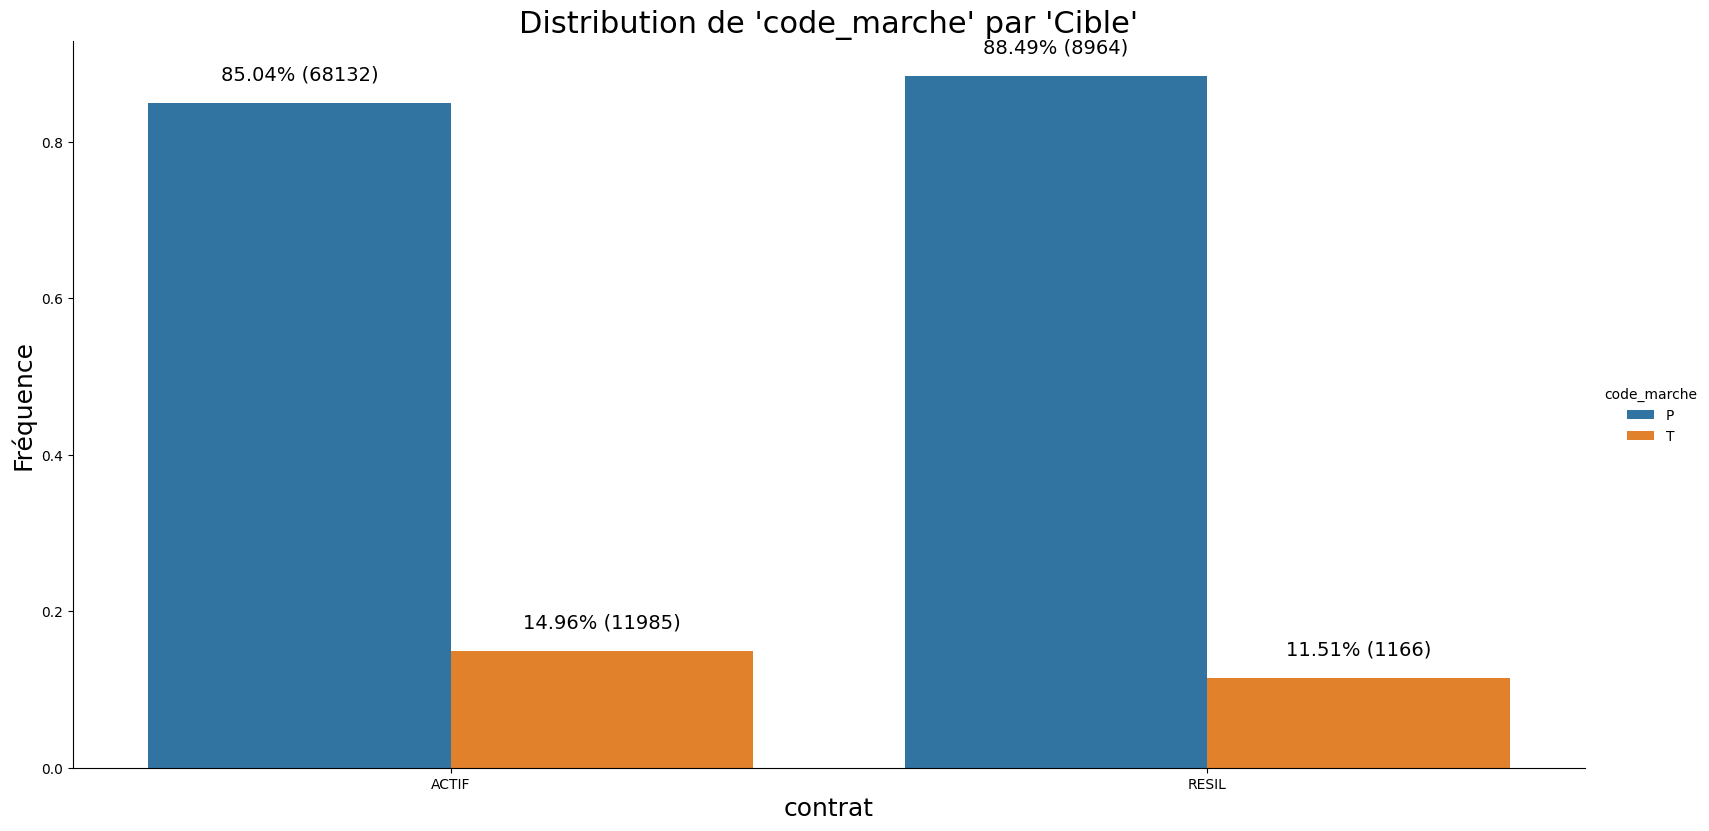

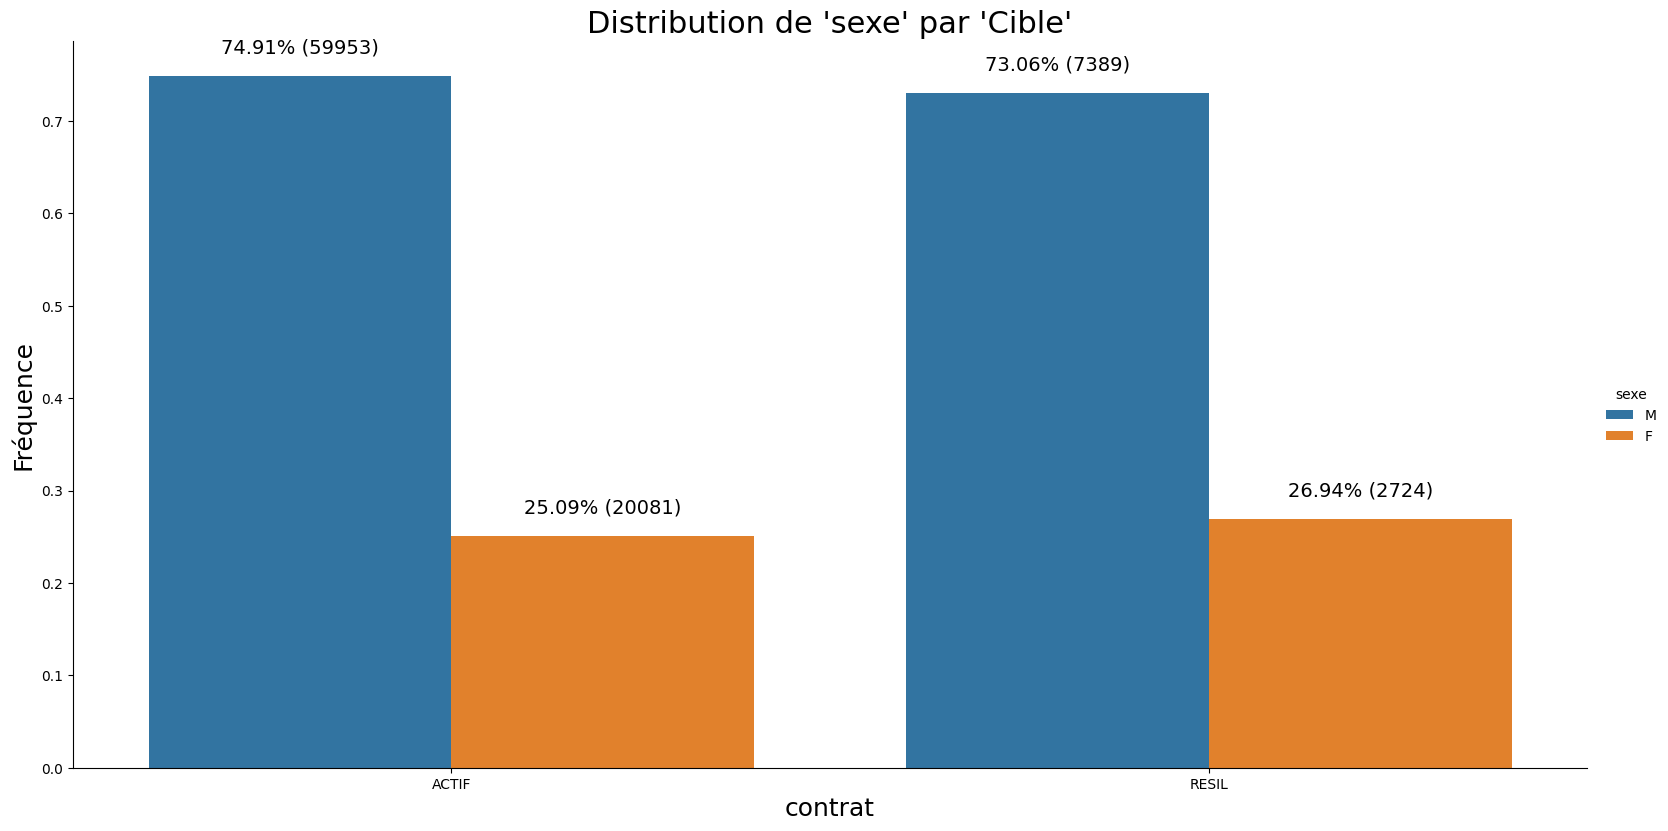

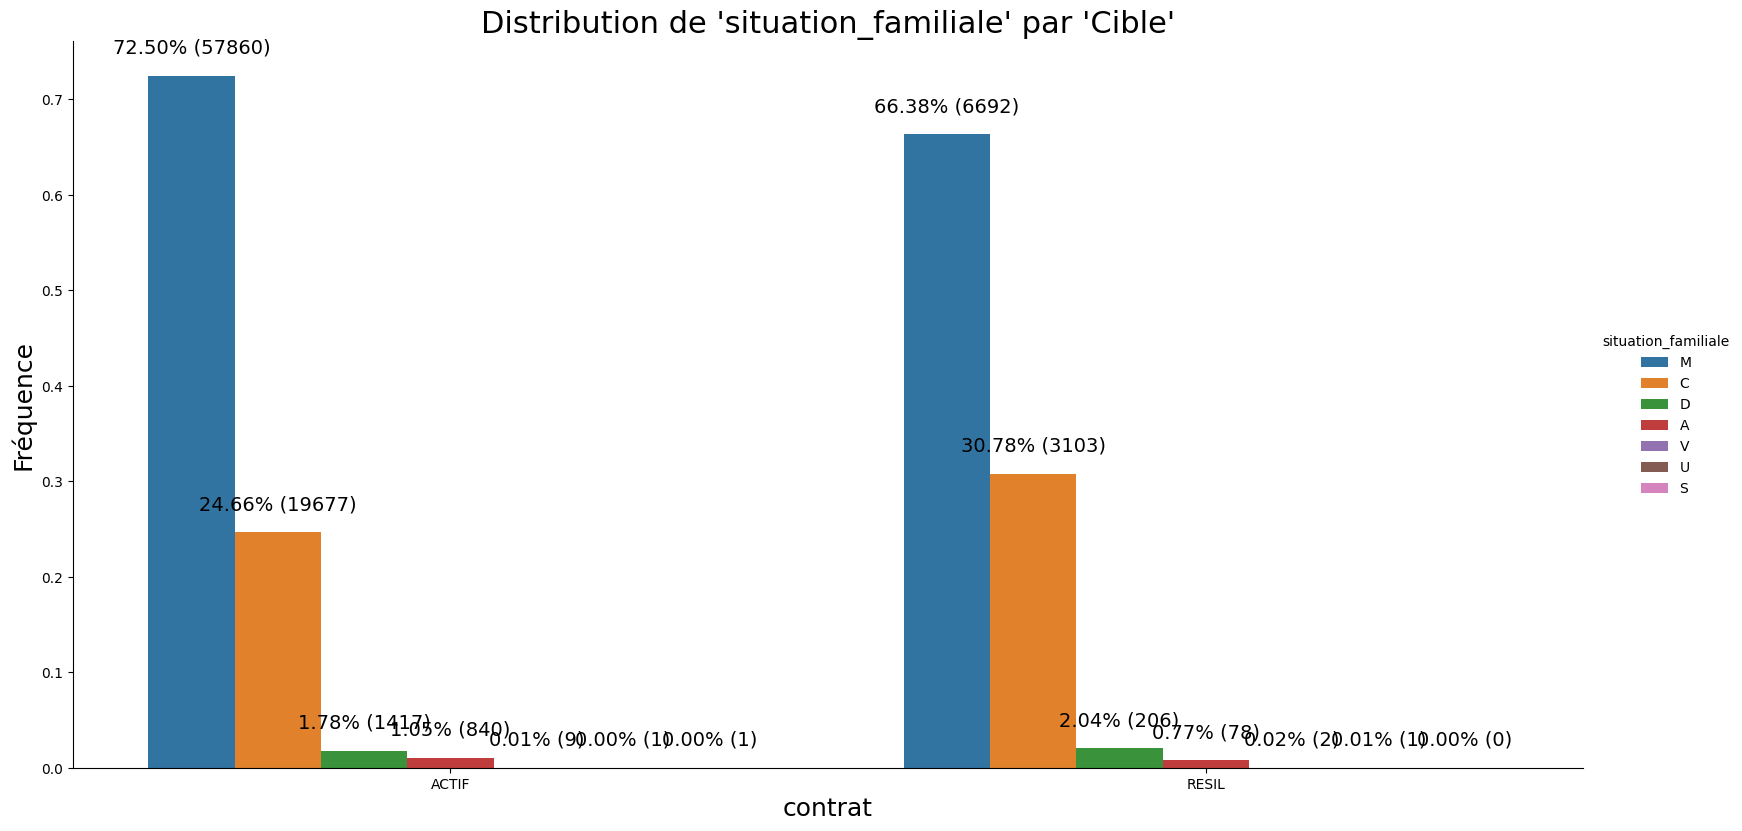

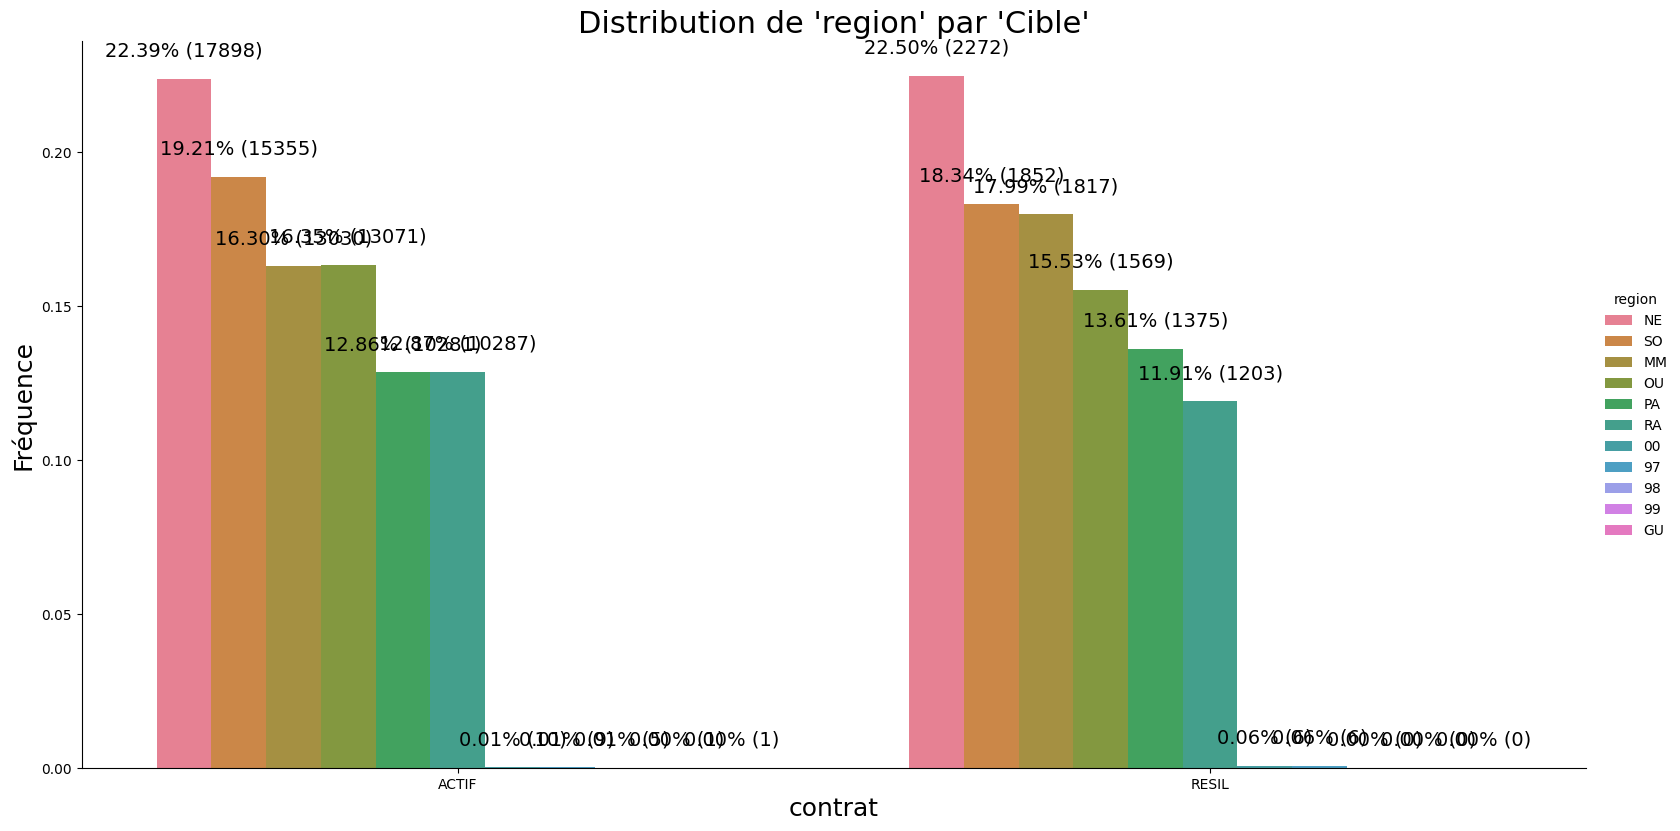

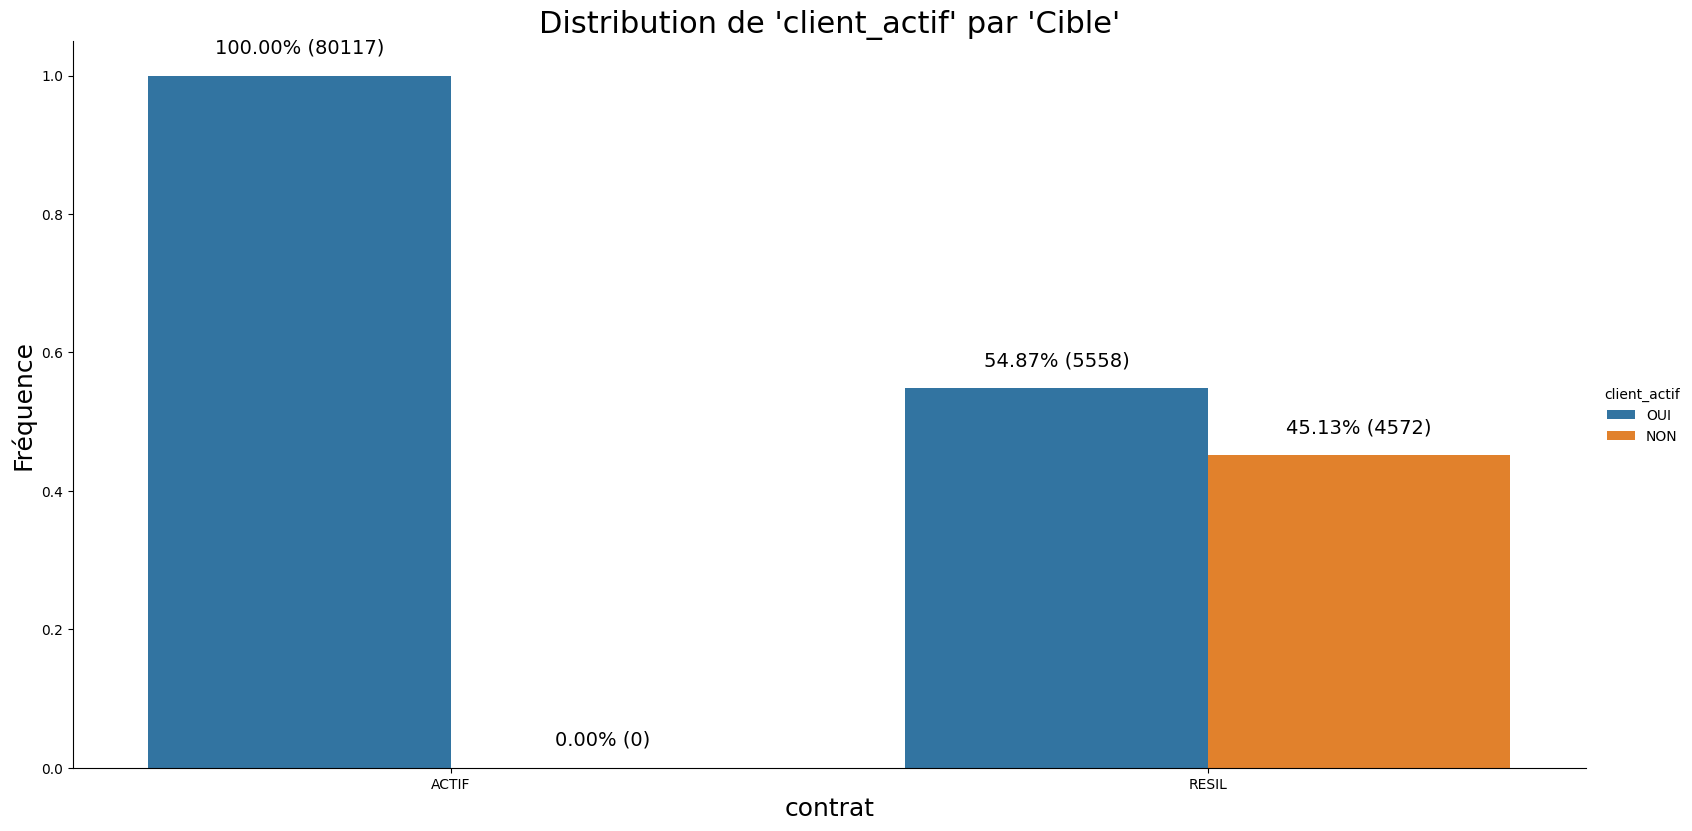

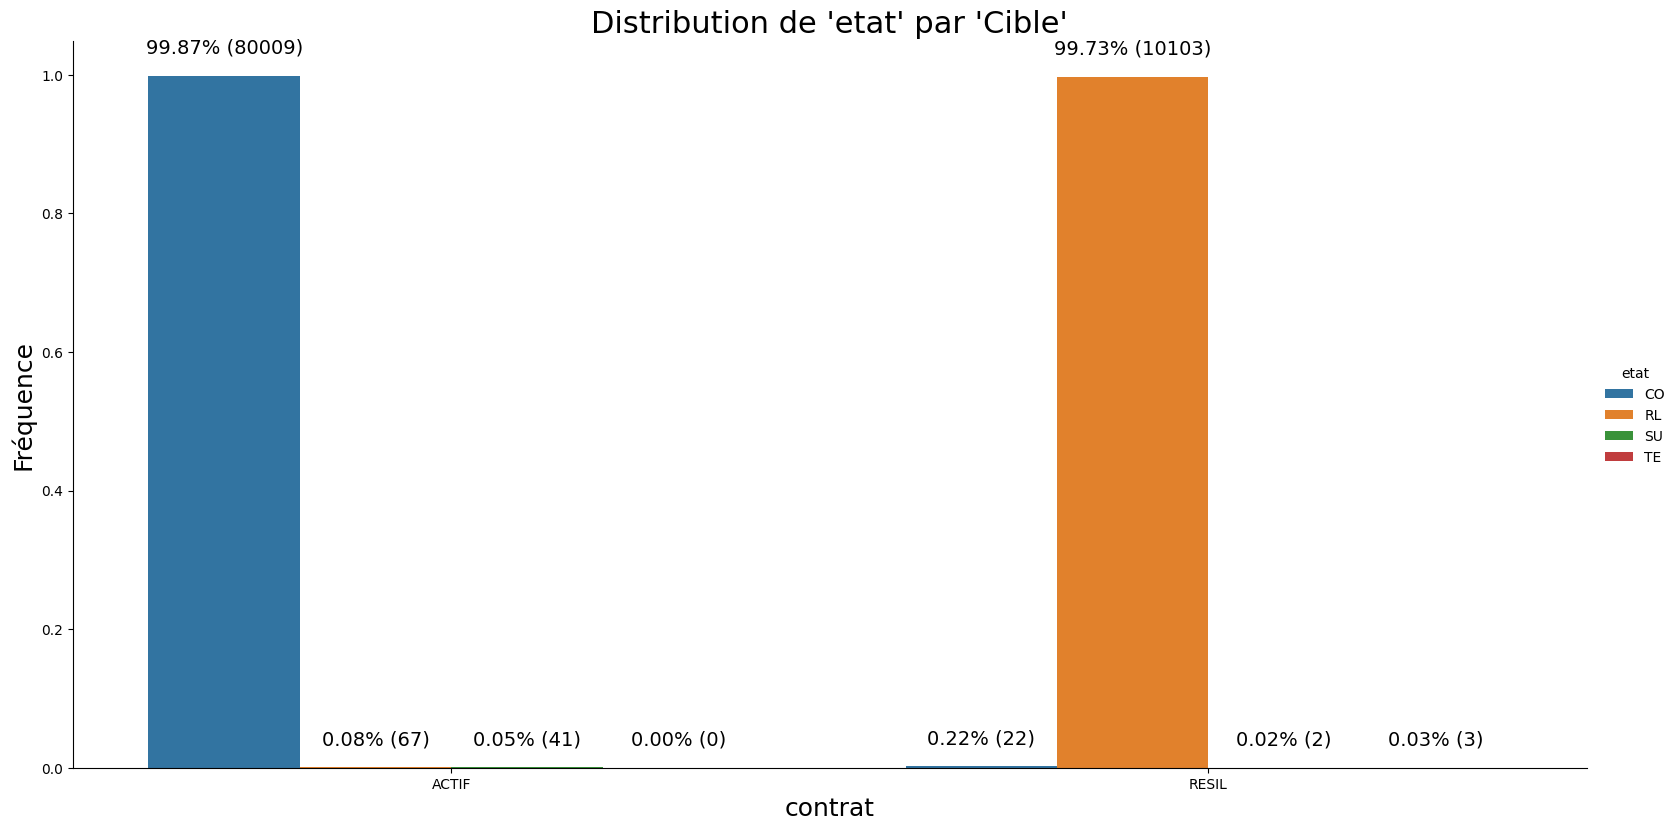

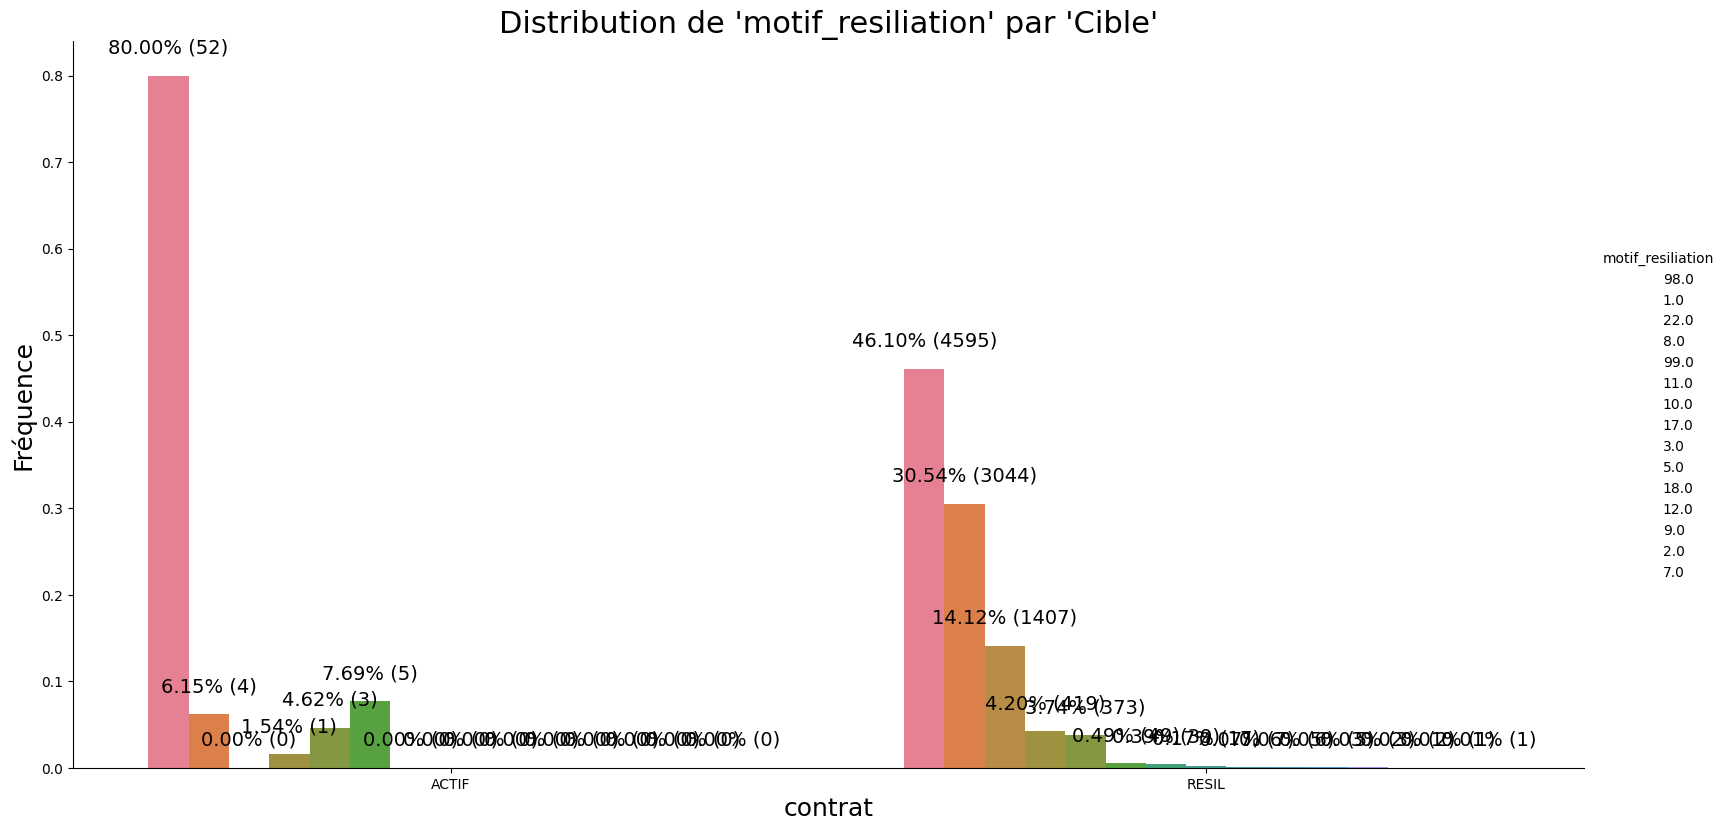

In [ ]:
for col in var_cat_graph:
    distrib_for_cat_by_target(col,df,"contrat")

#### 2.5.2 Représentations graphiques des continues par rapport à la cible

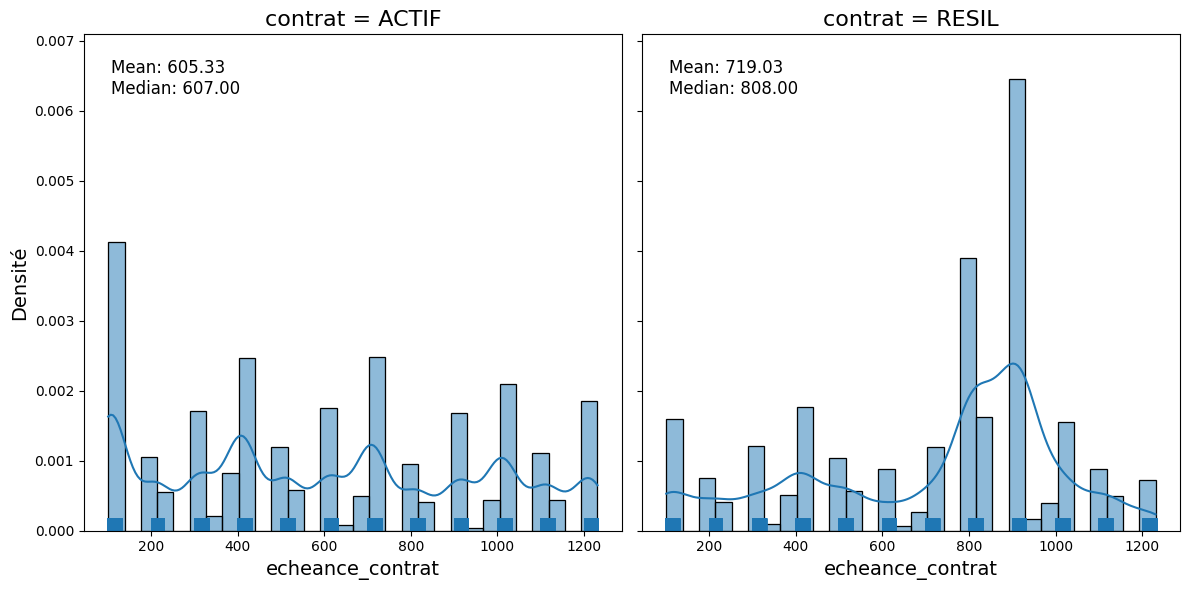

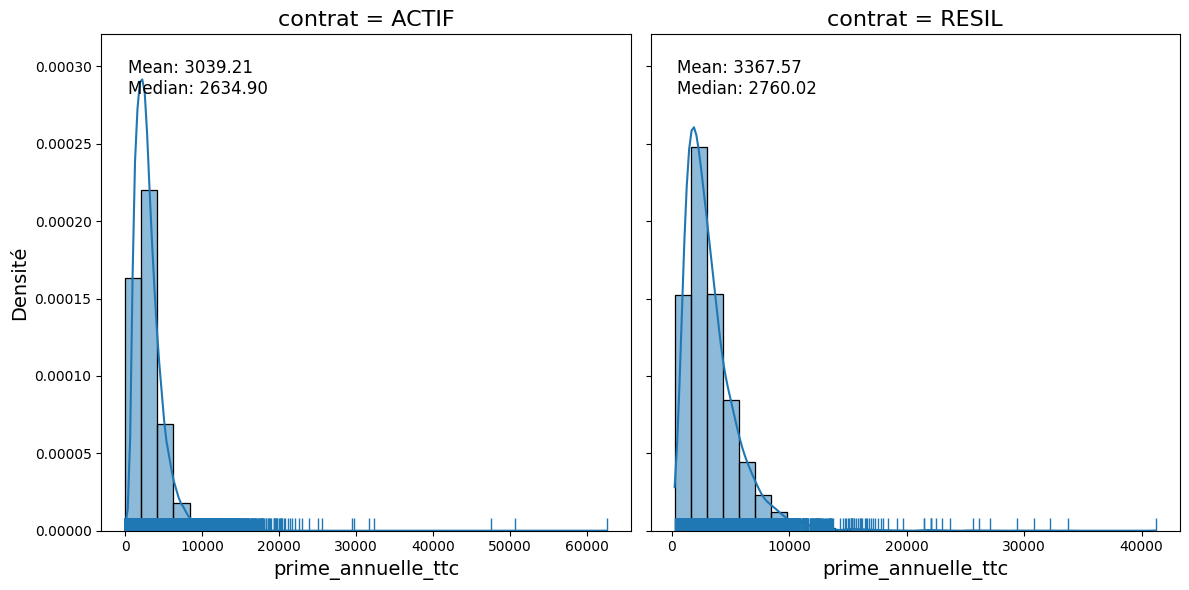

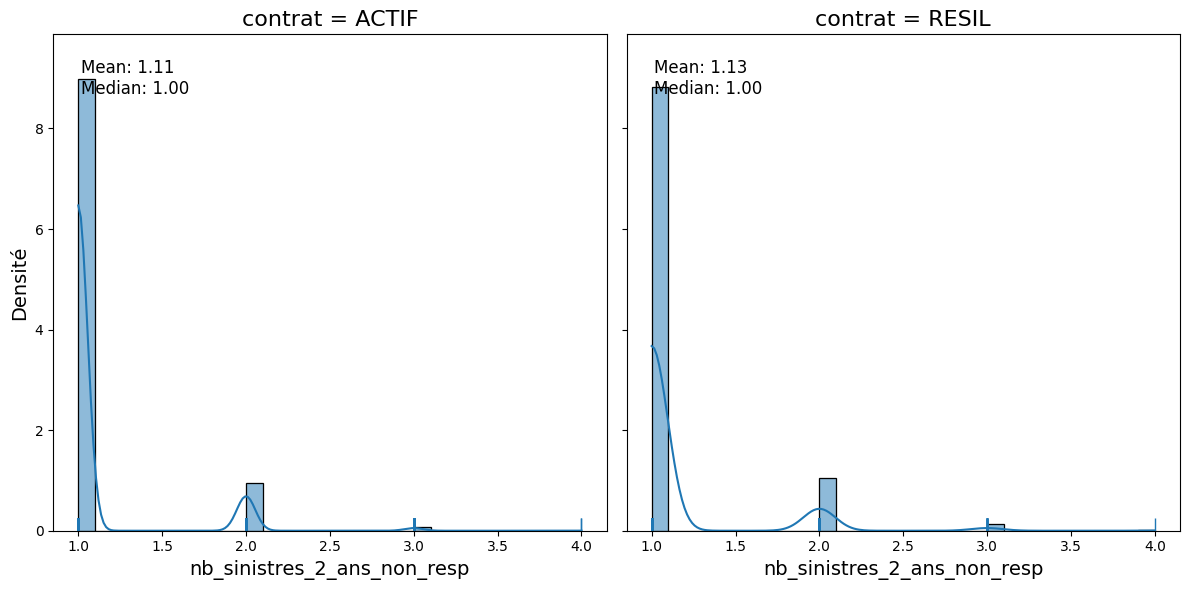

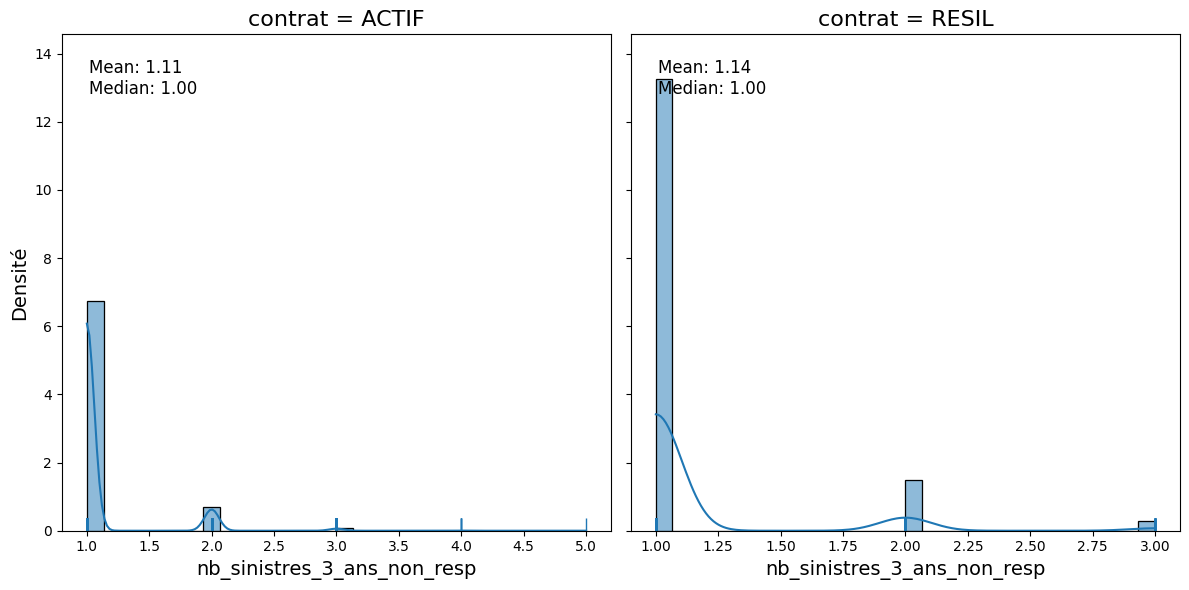

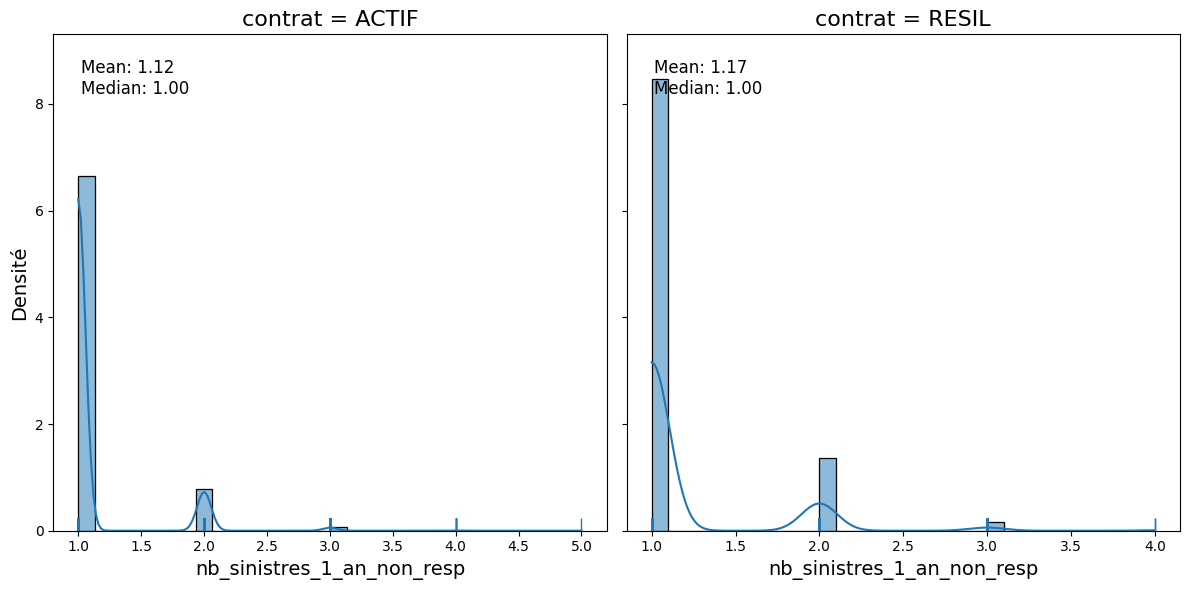

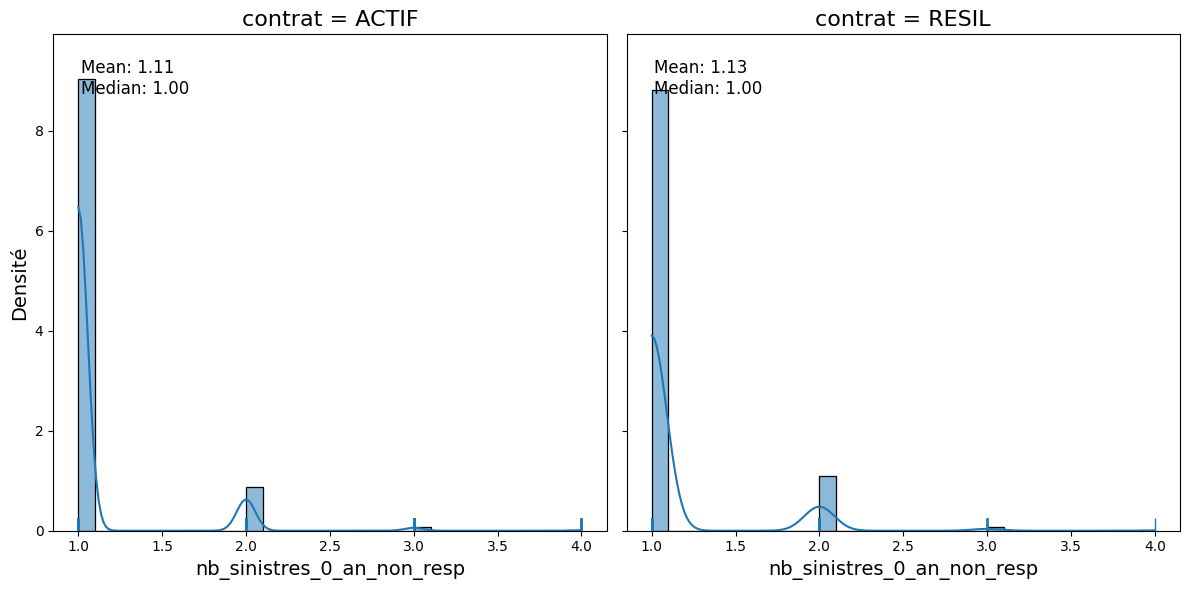

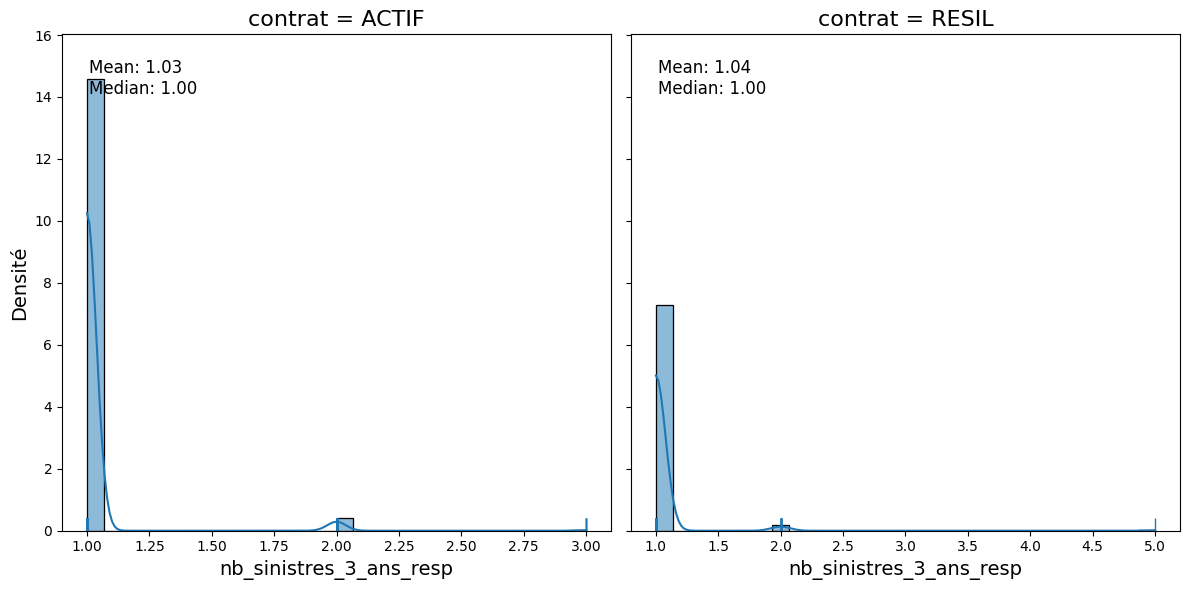

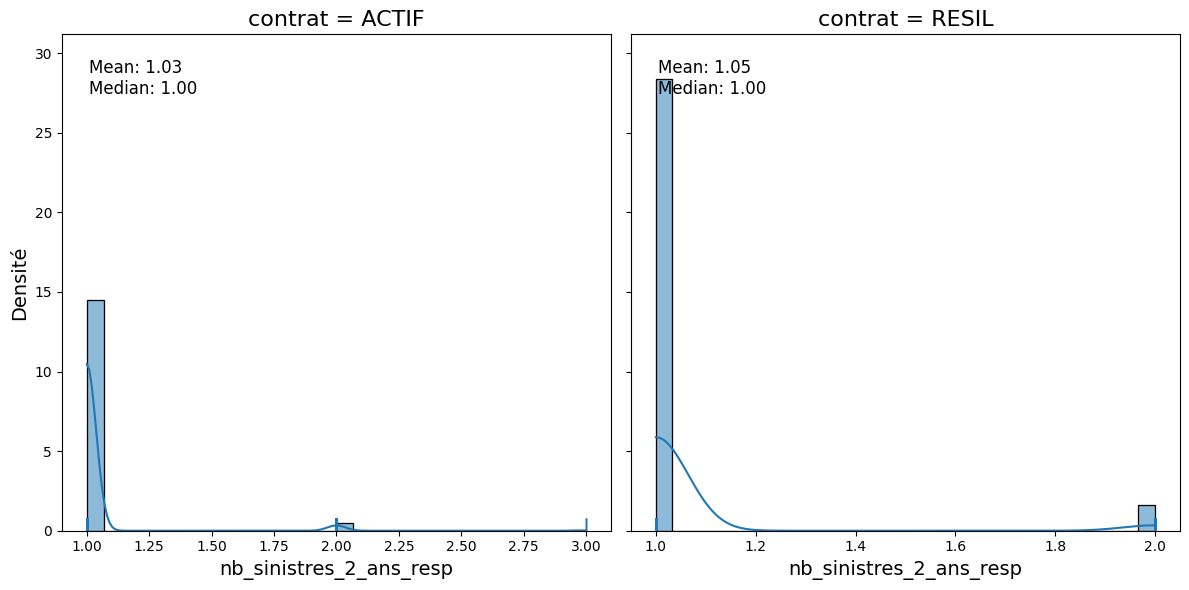

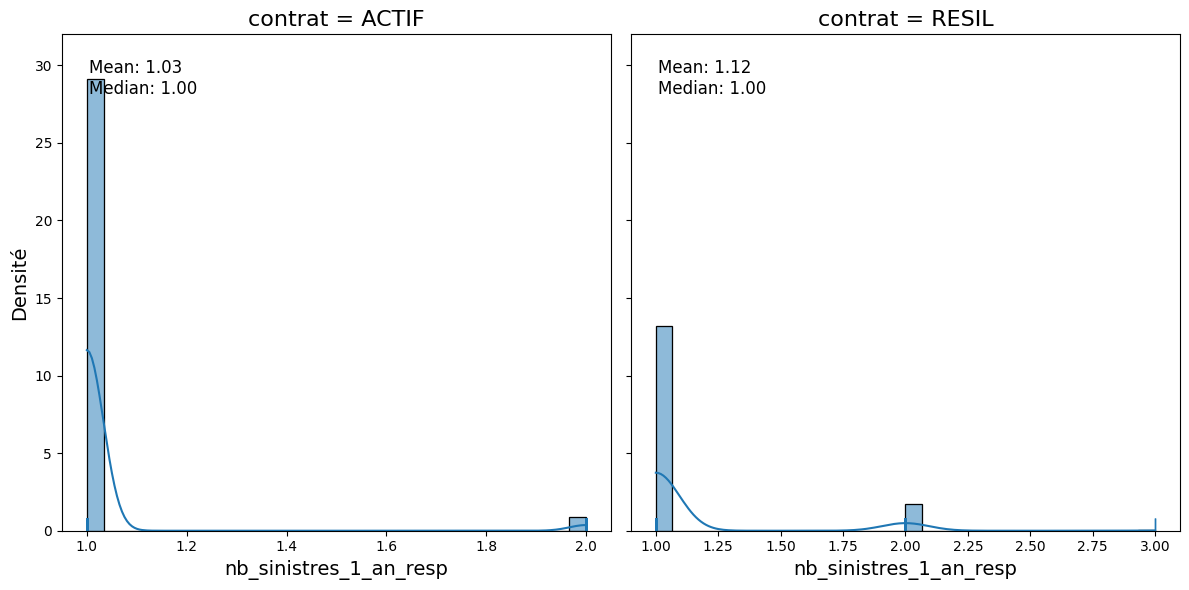

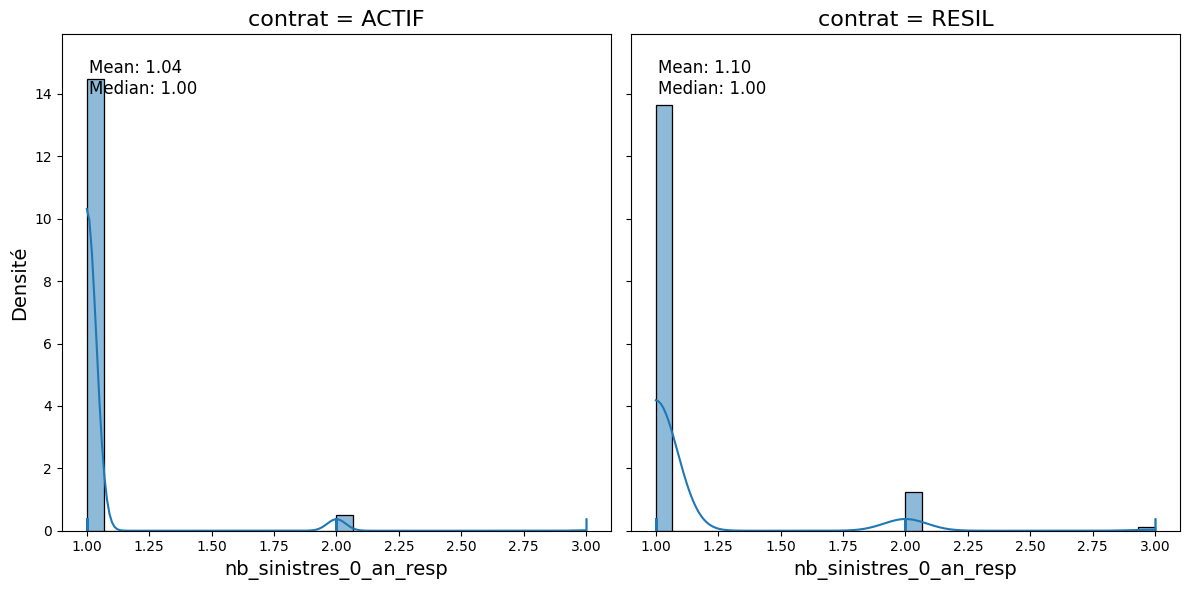

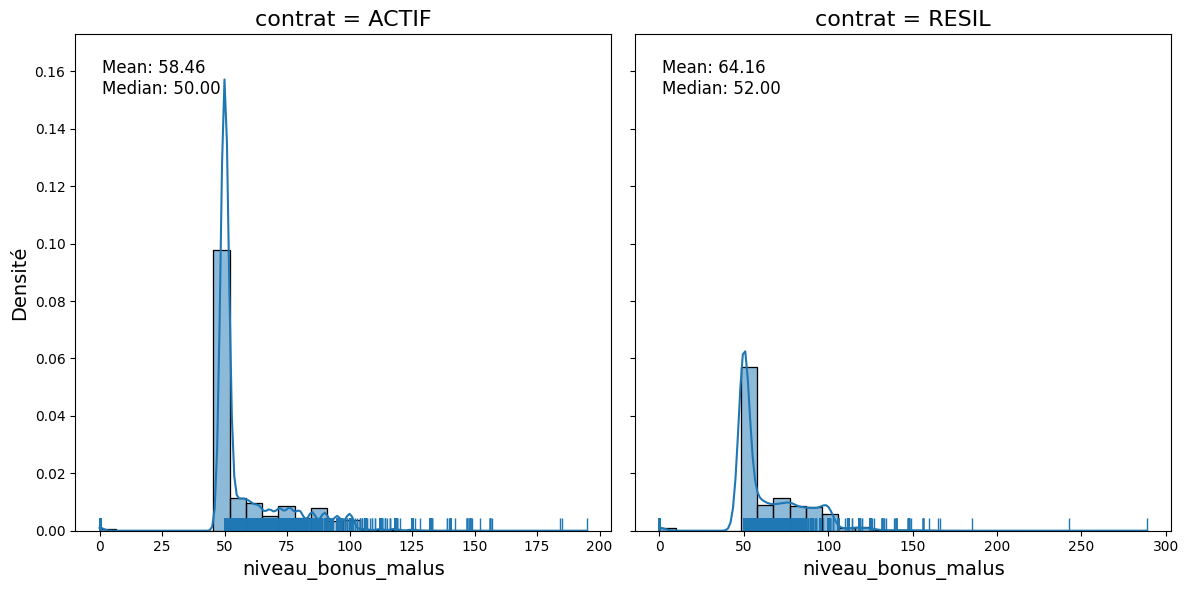

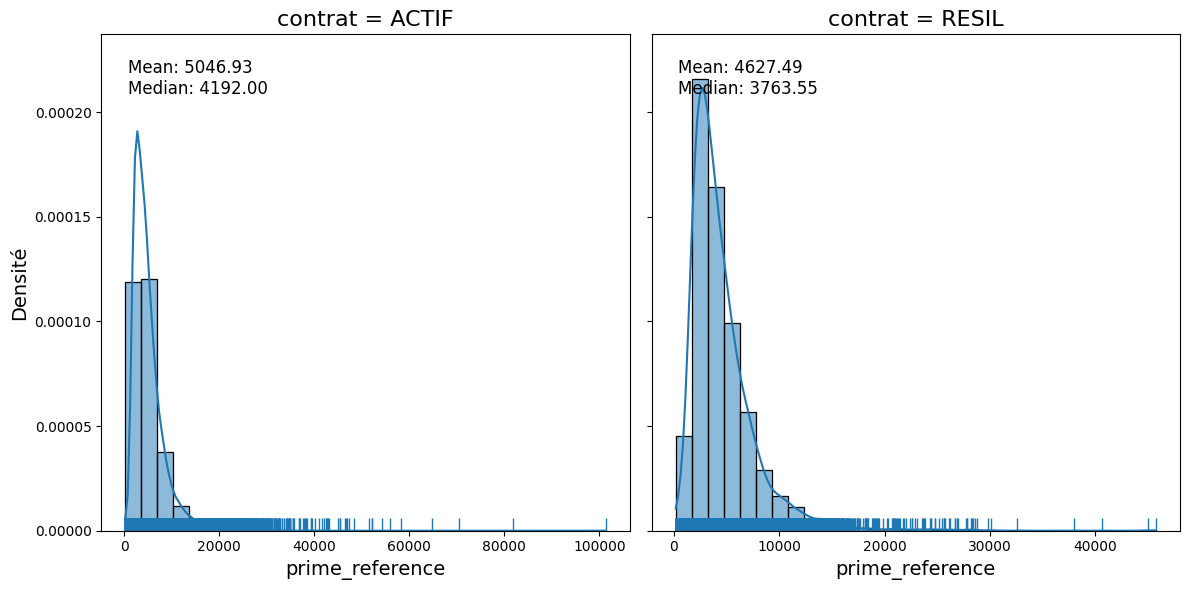

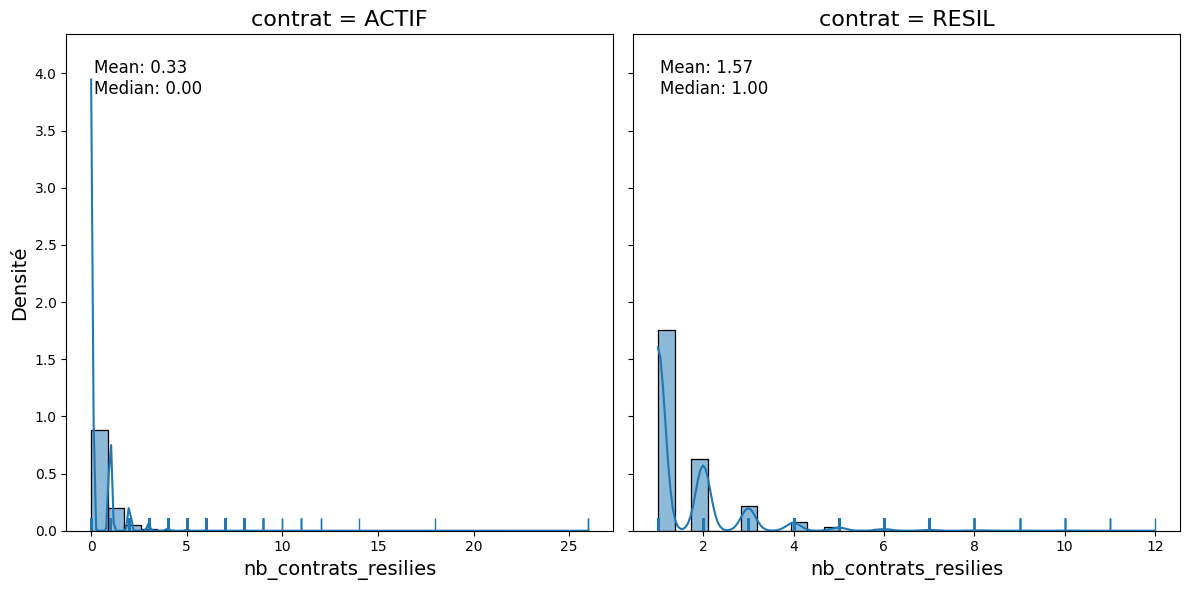

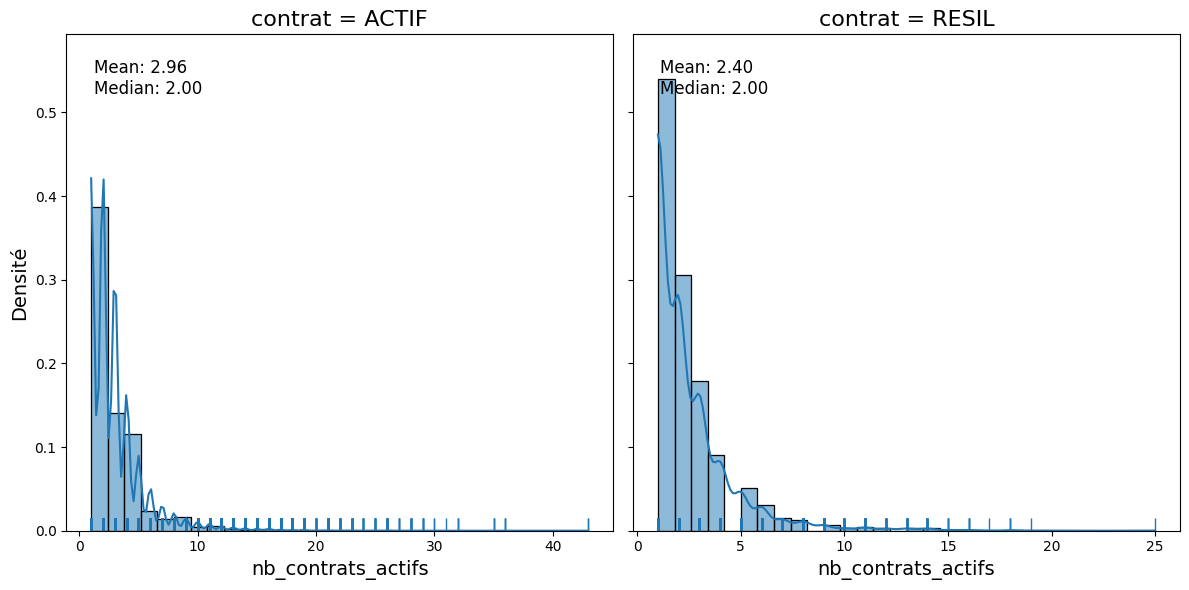

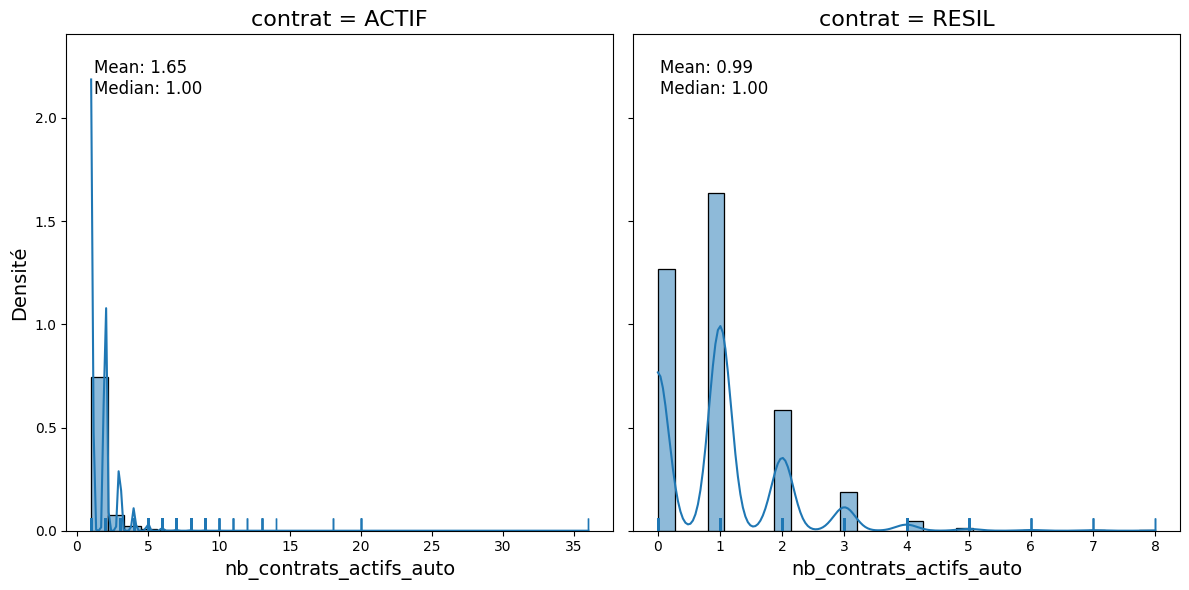

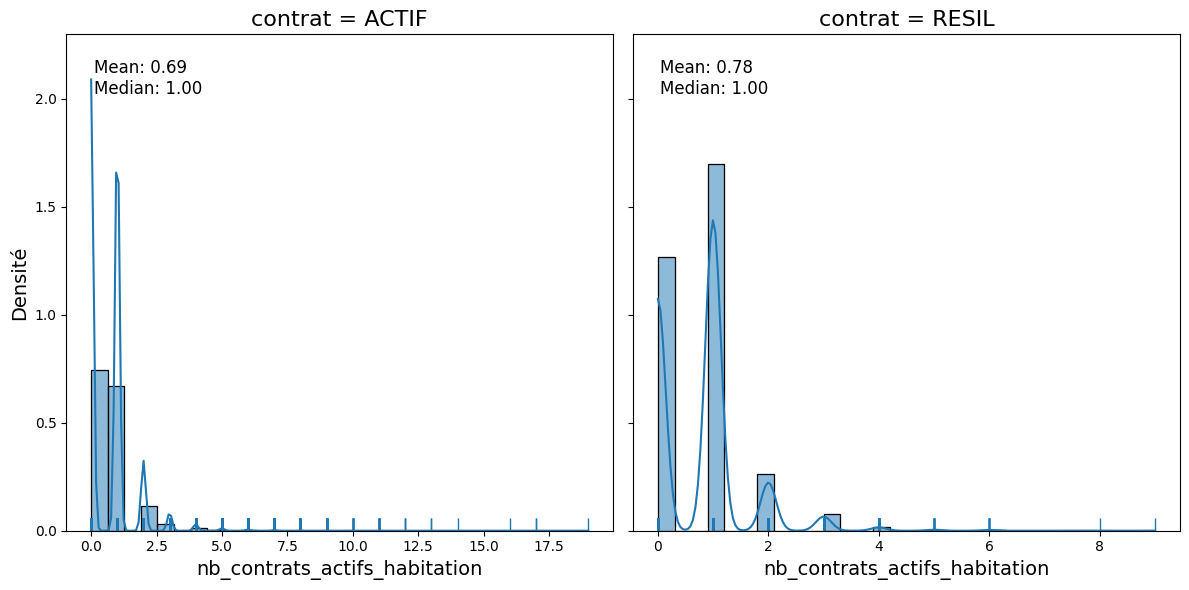

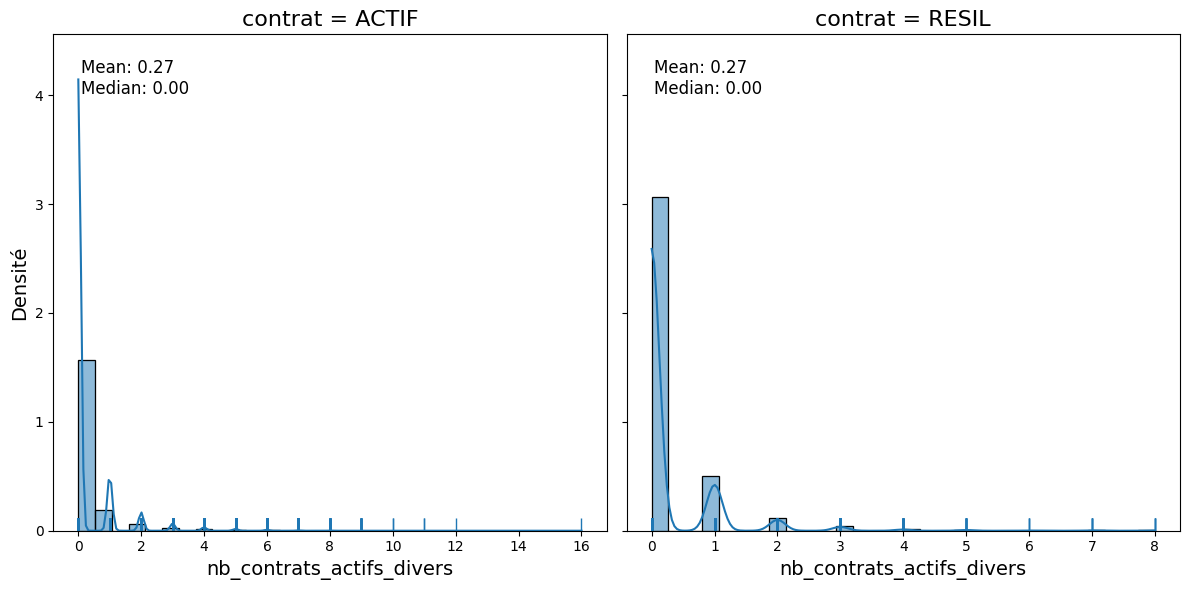

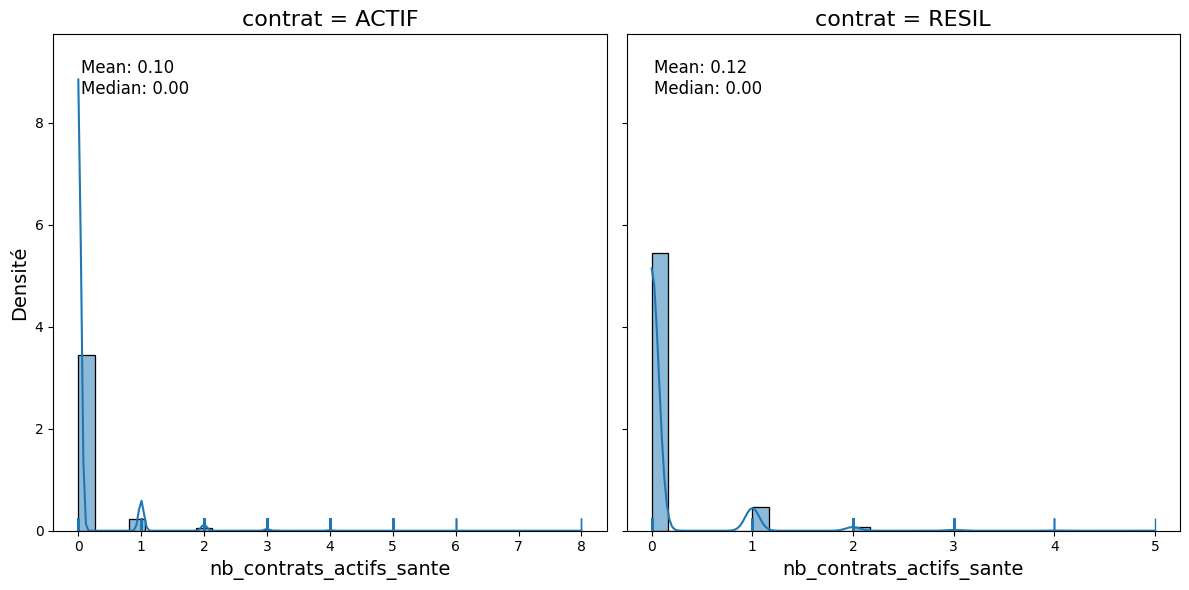

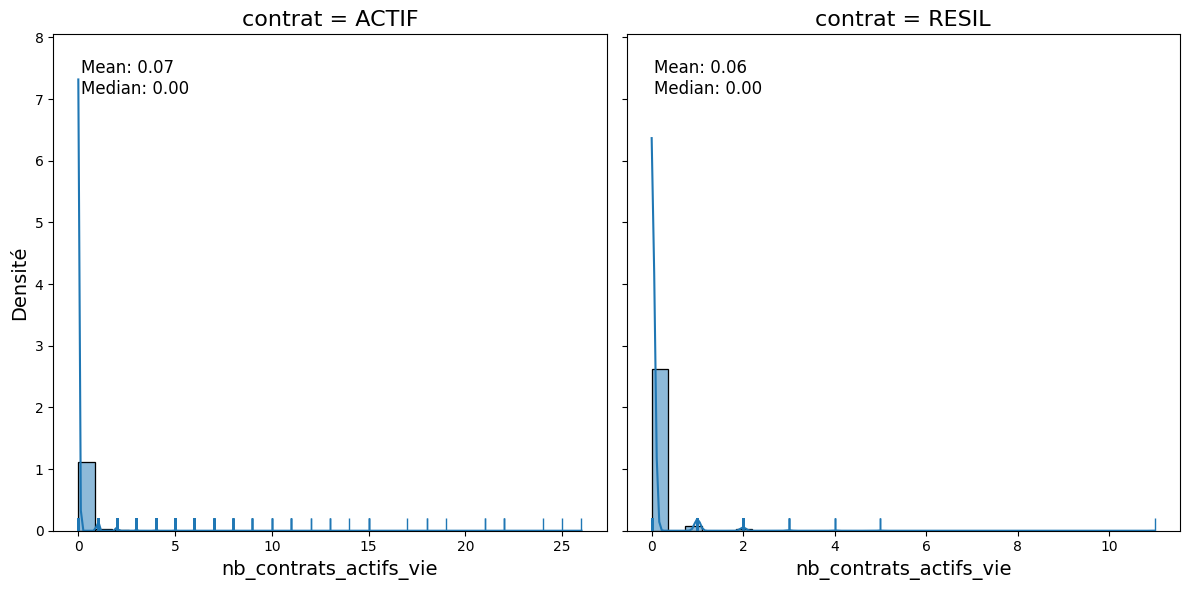

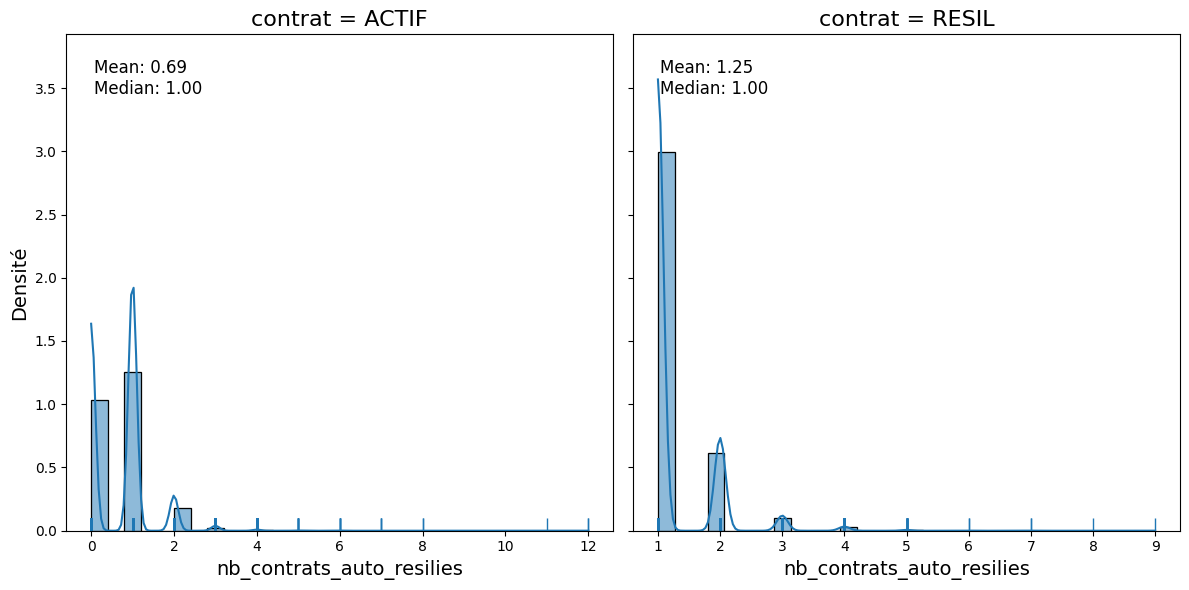

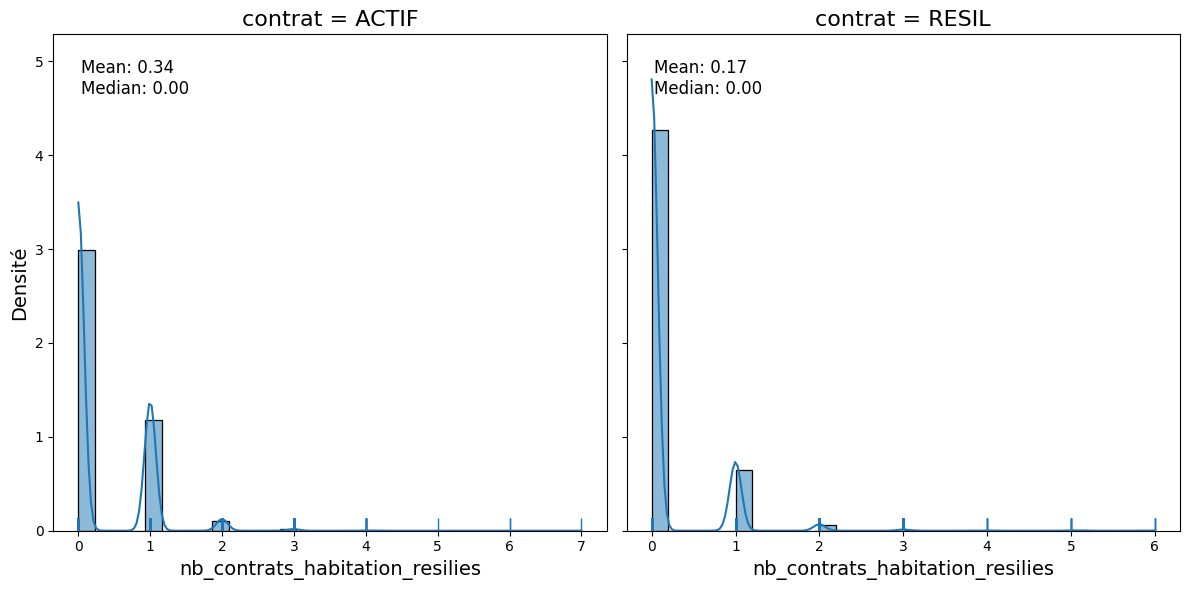

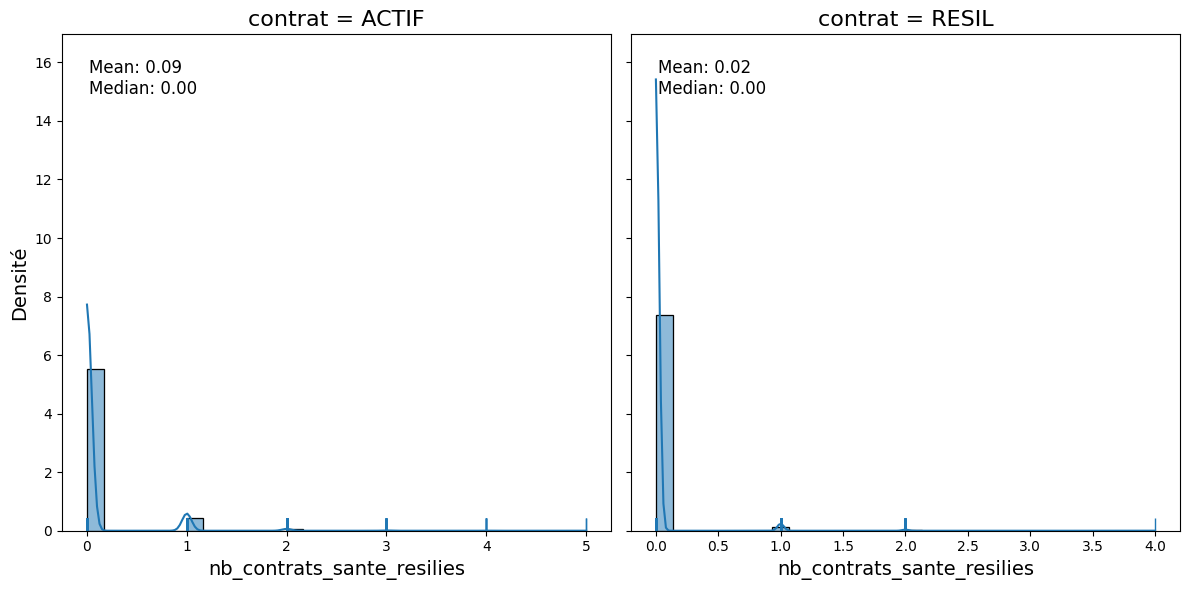

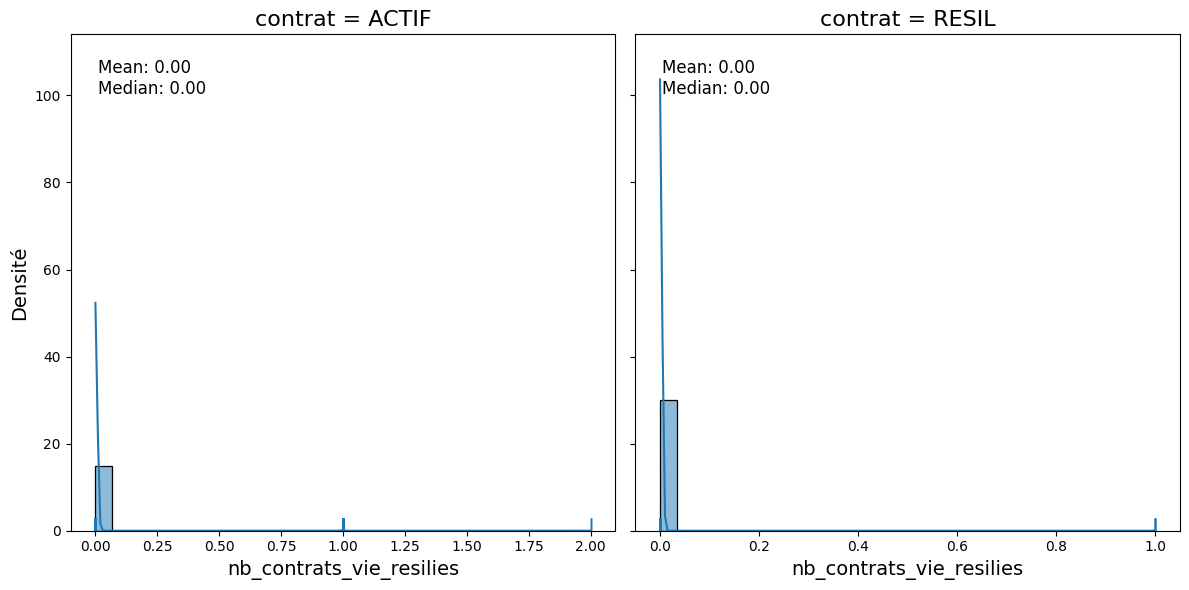

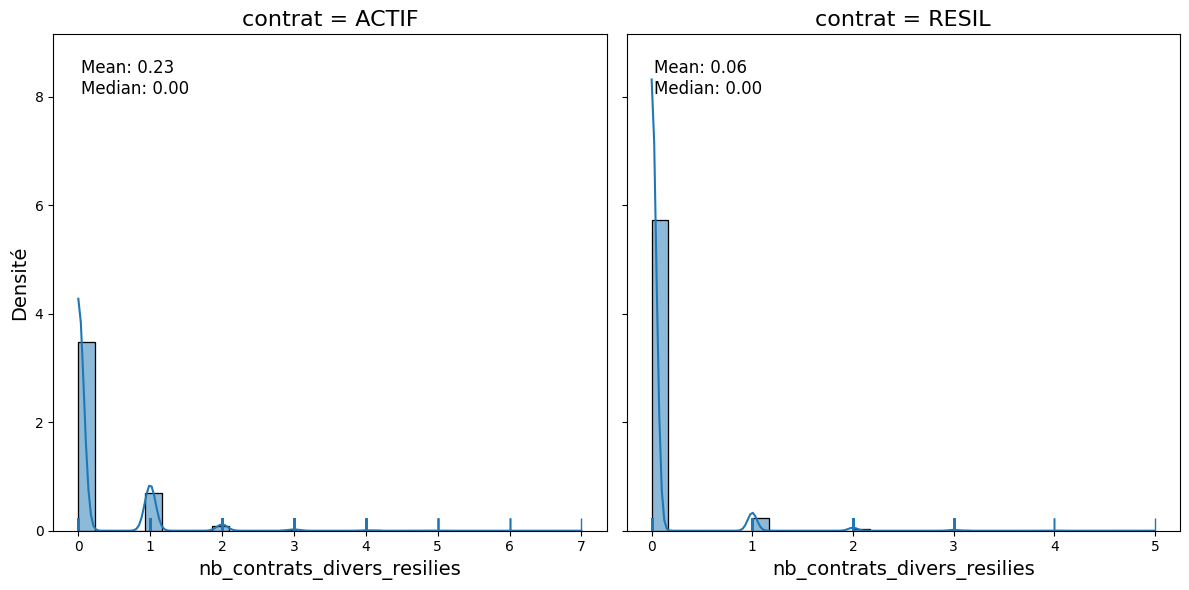

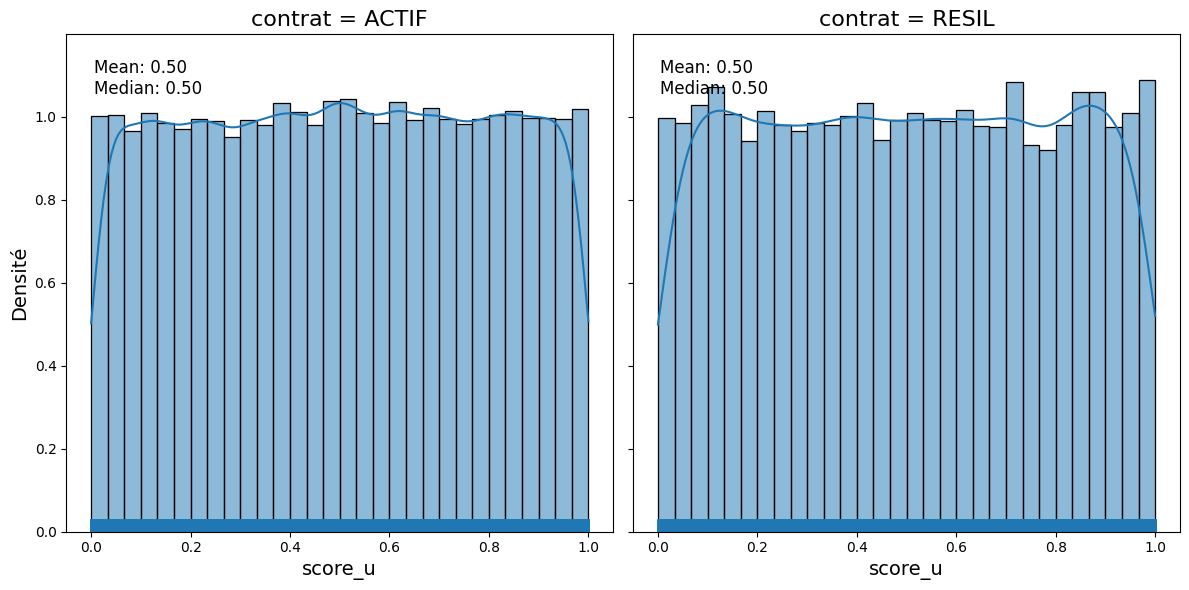

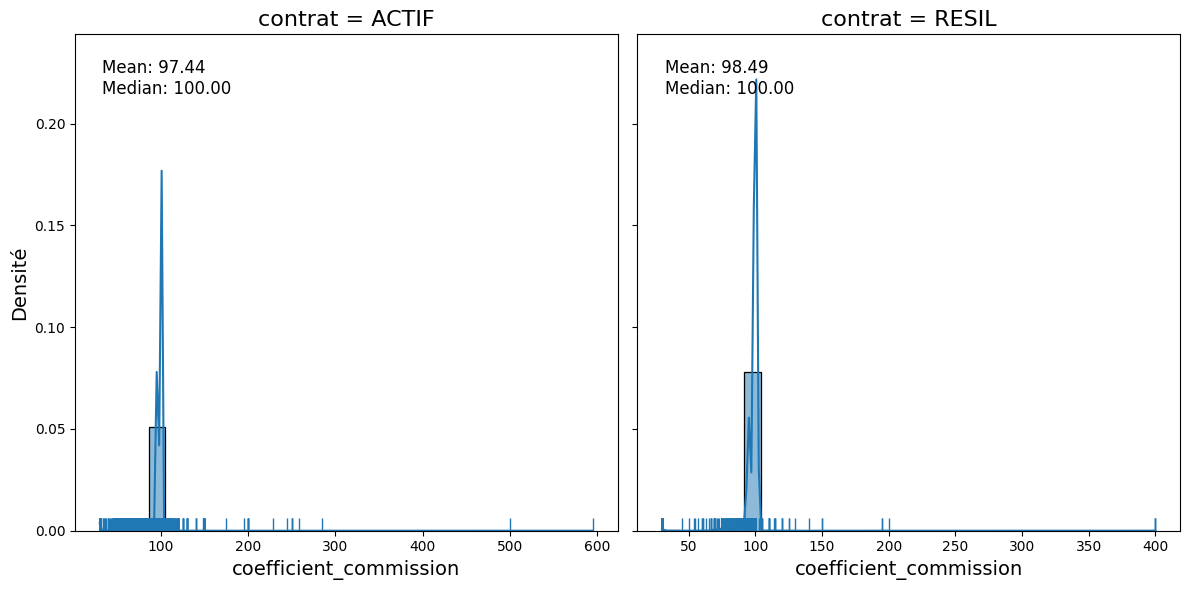

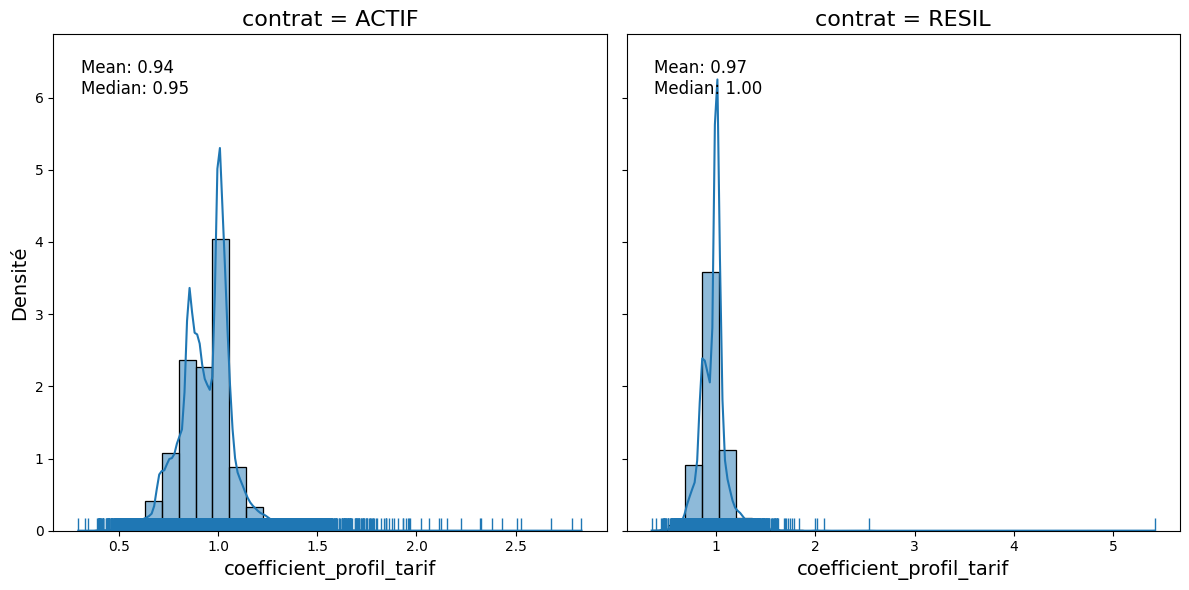

In [ ]:
for field in var_num:
    distrib_for_cont_by_target(field,df,"contrat")

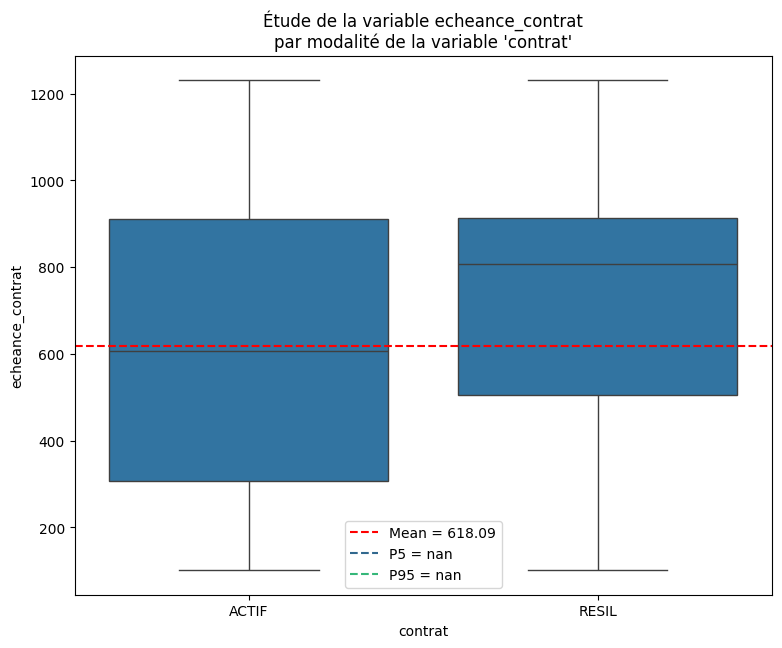

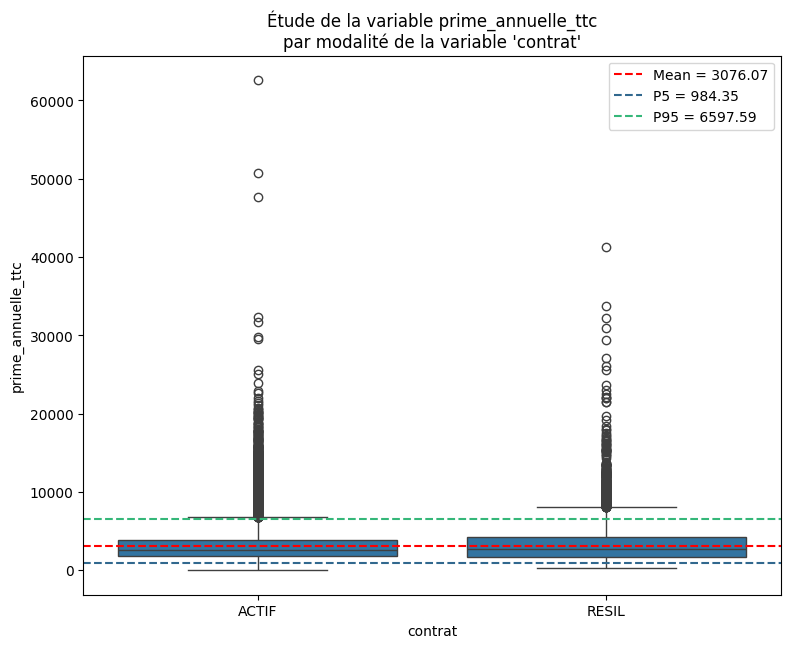

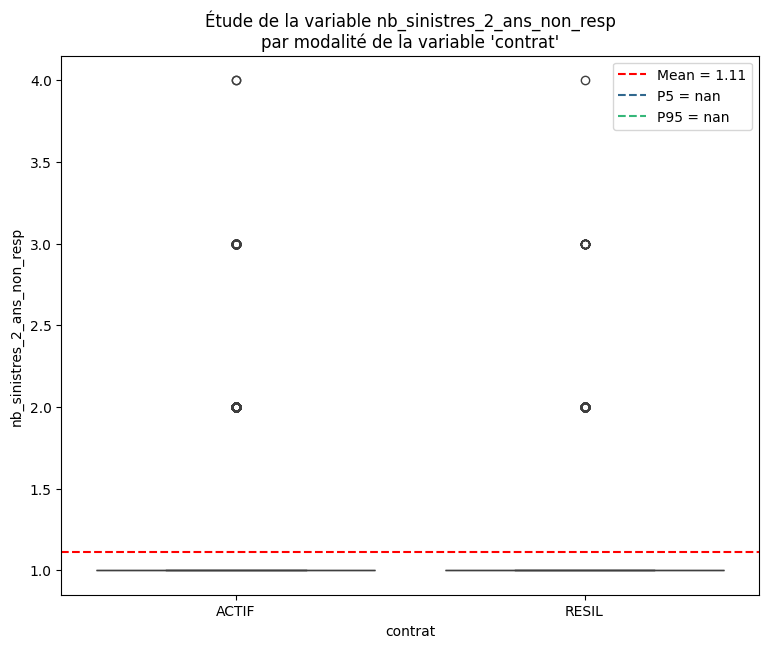

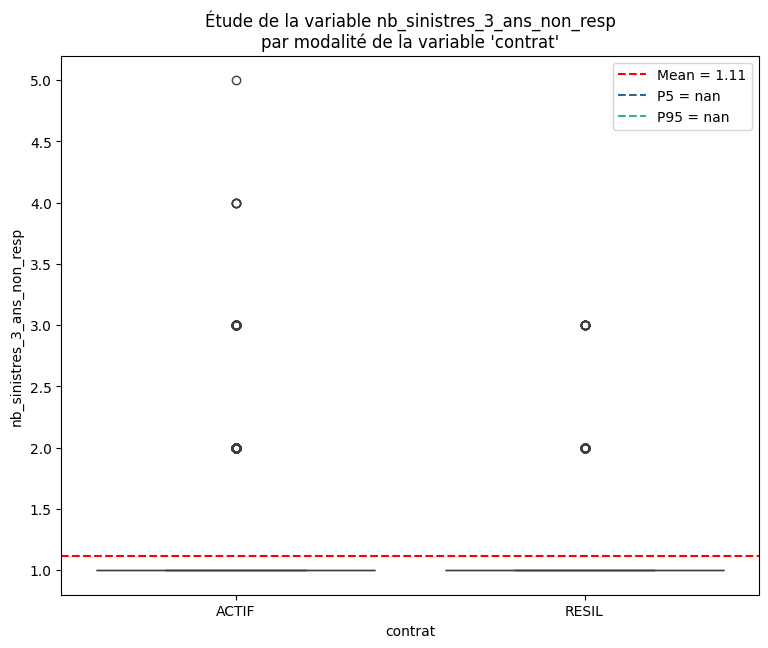

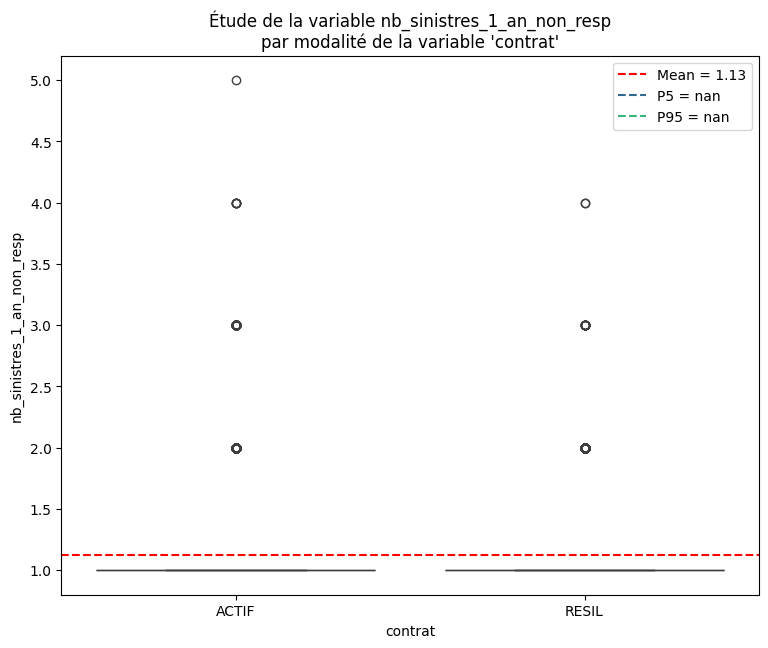

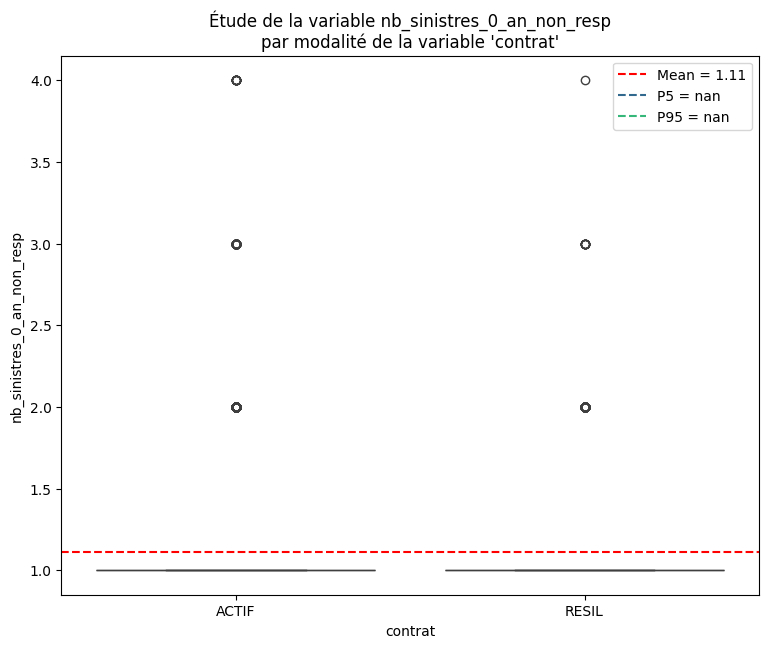

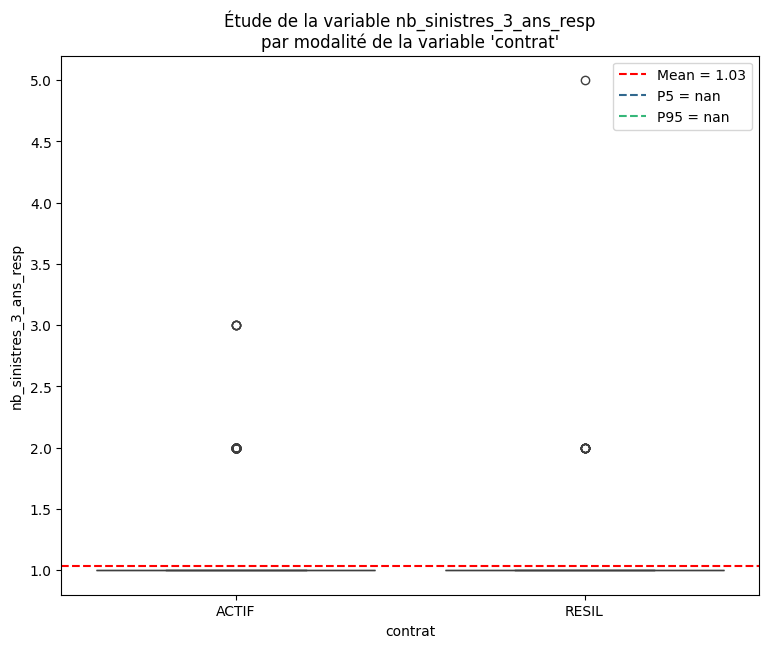

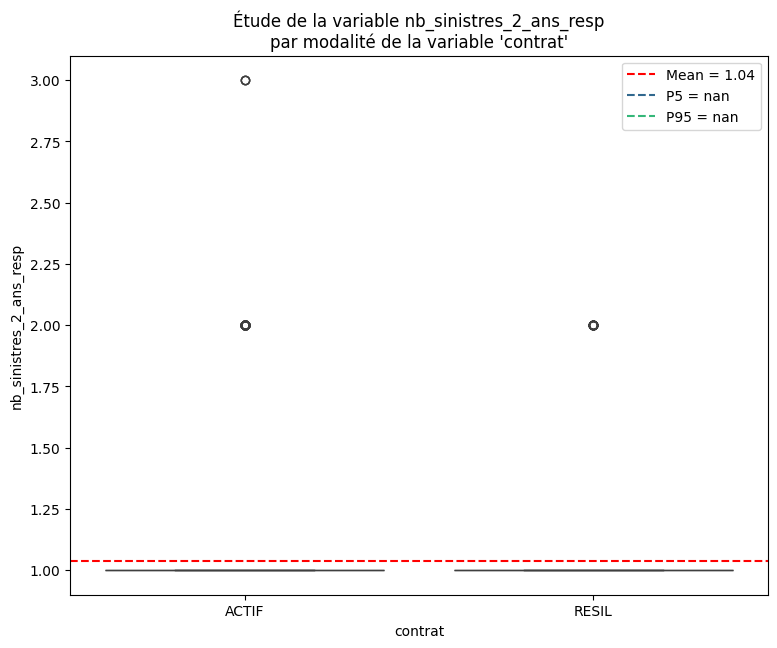

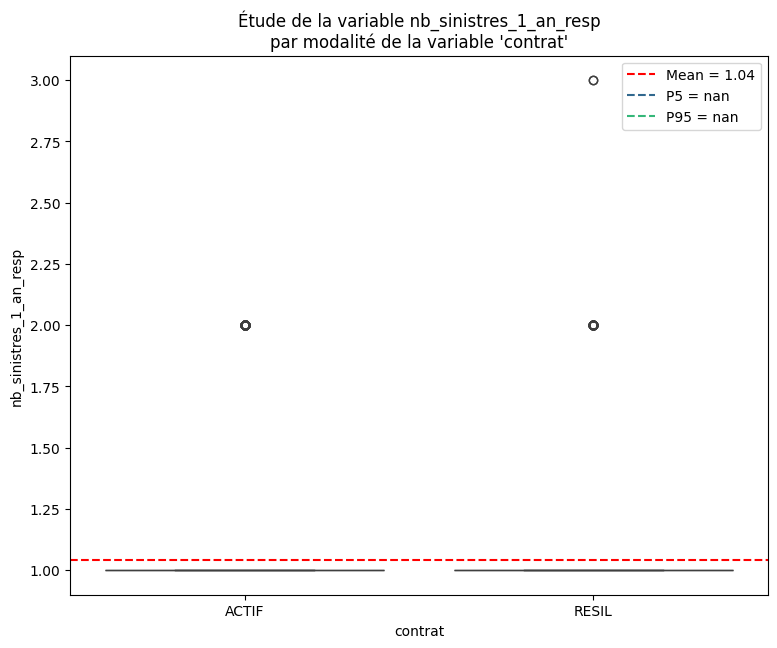

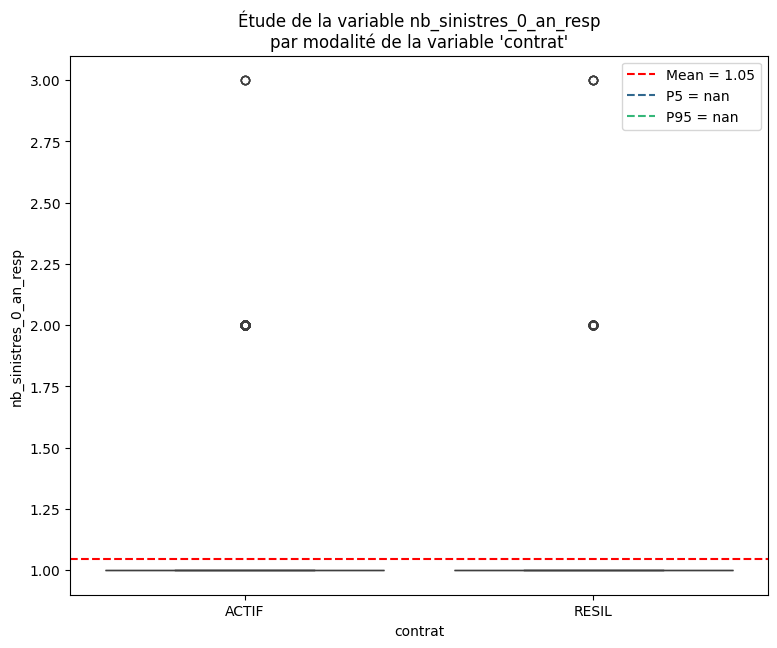

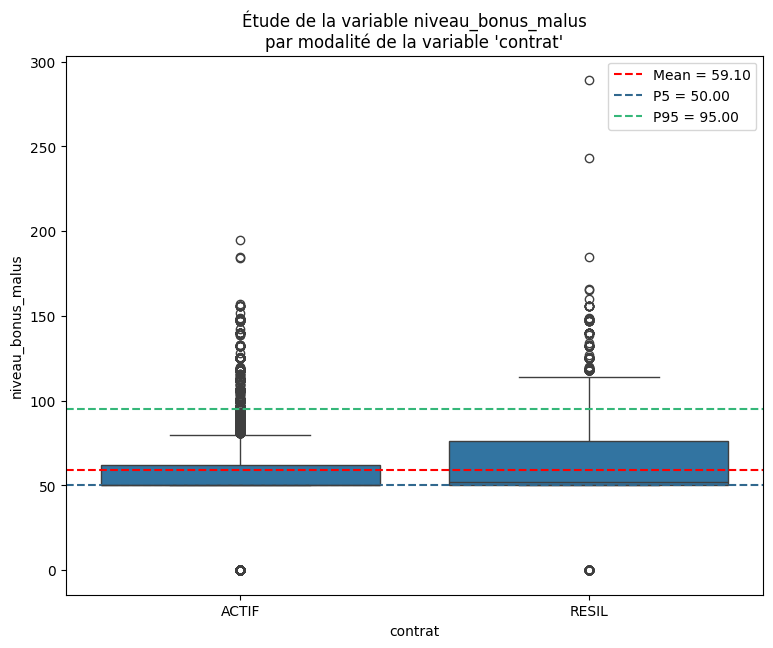

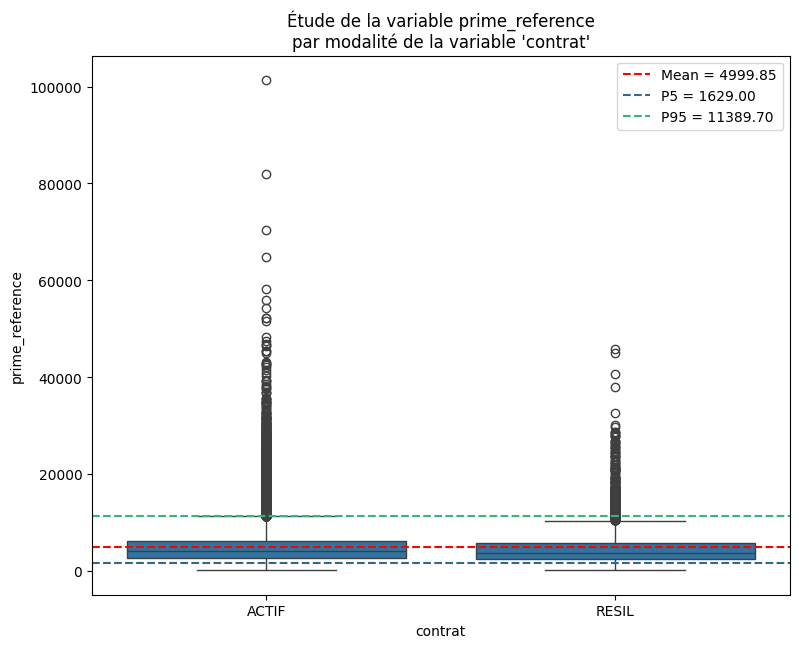

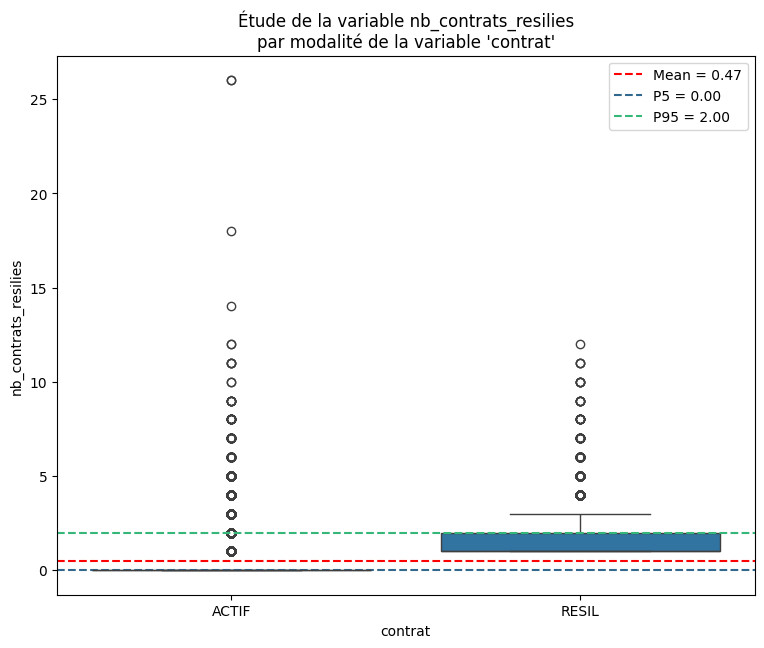

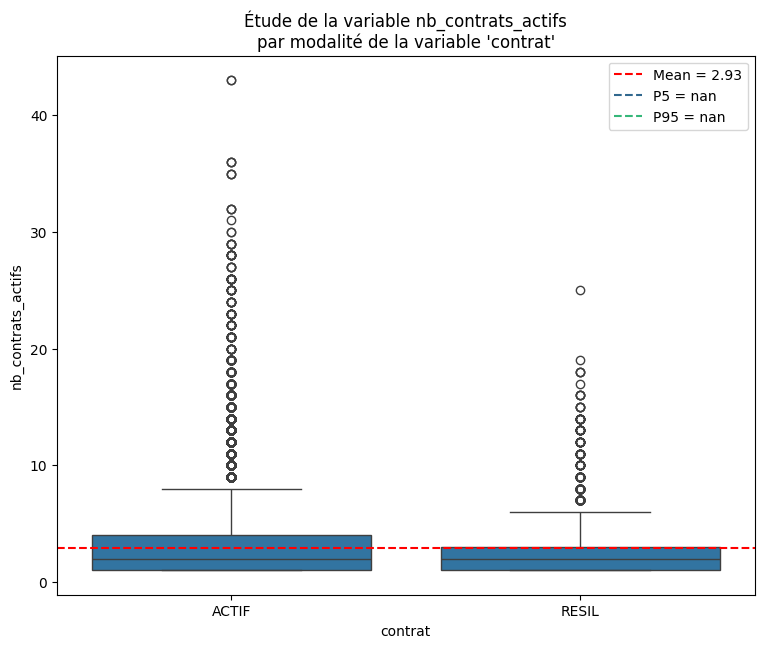

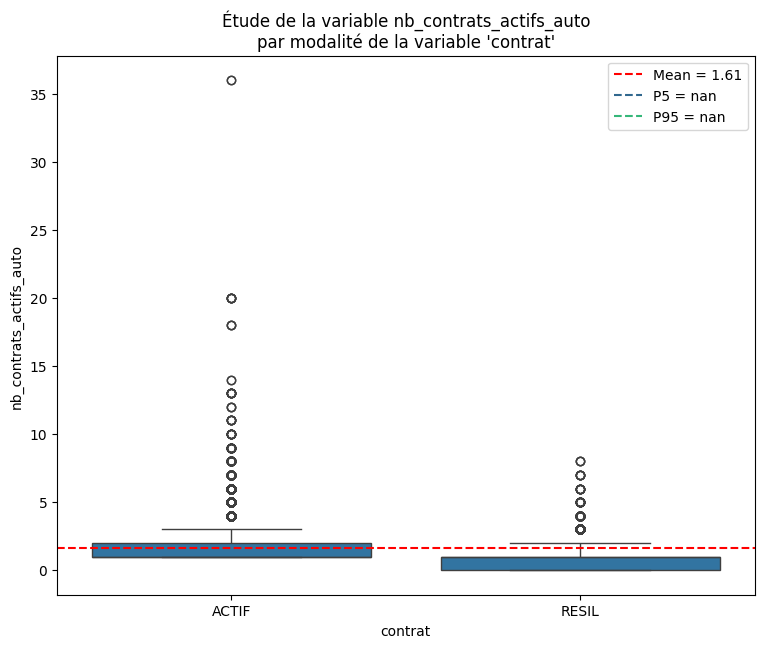

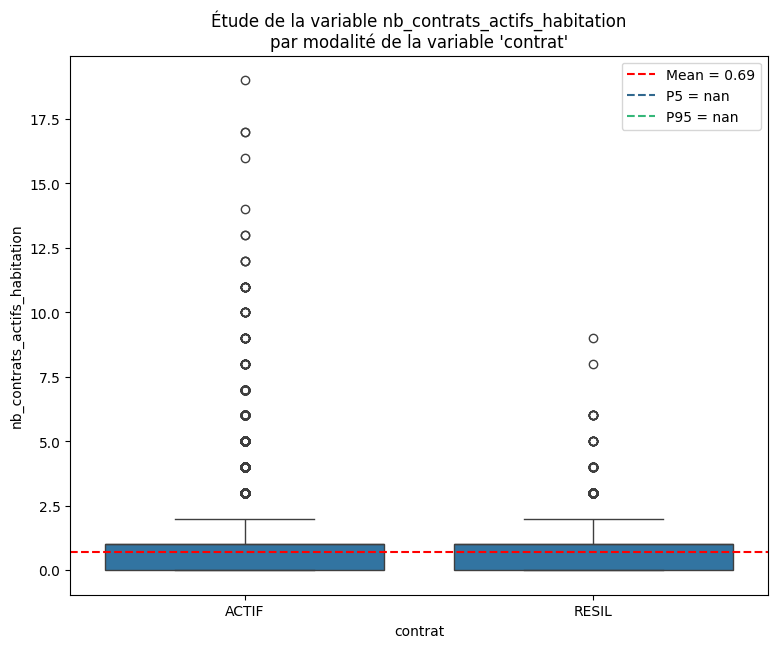

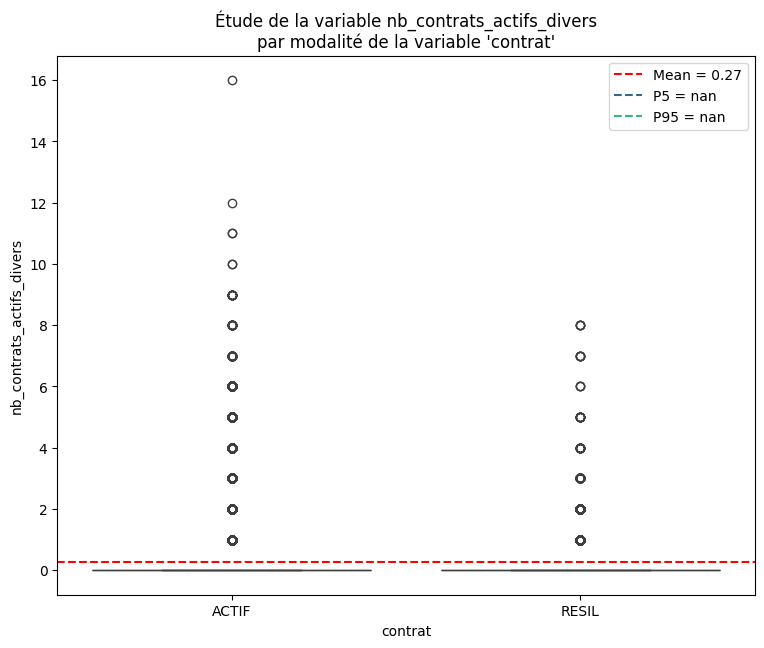

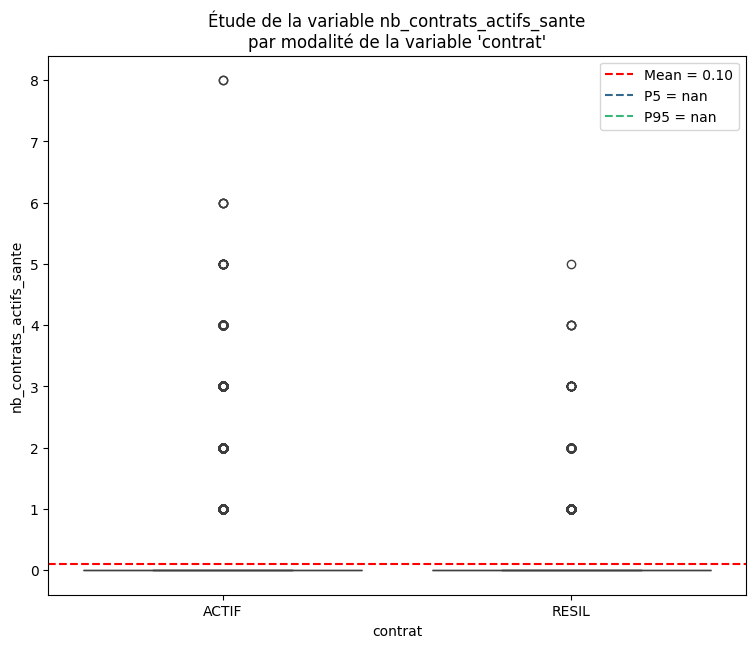

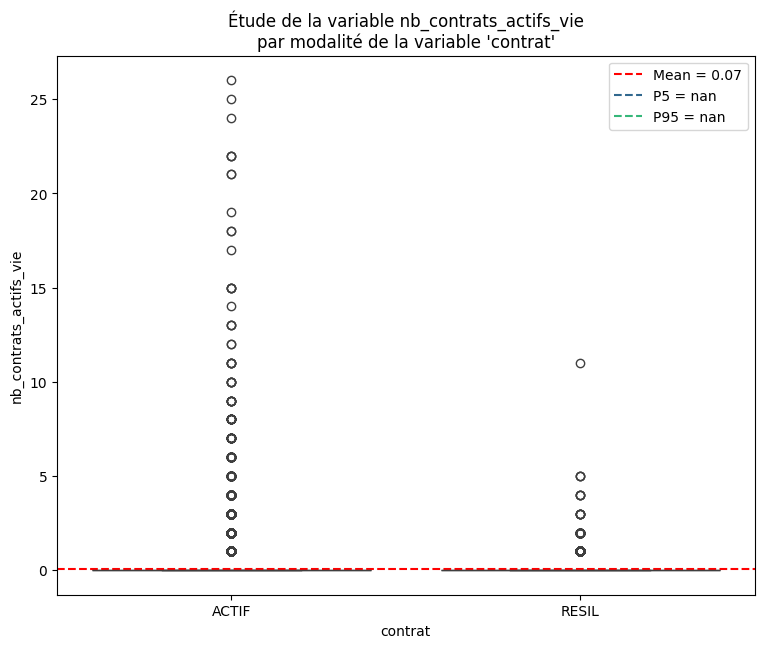

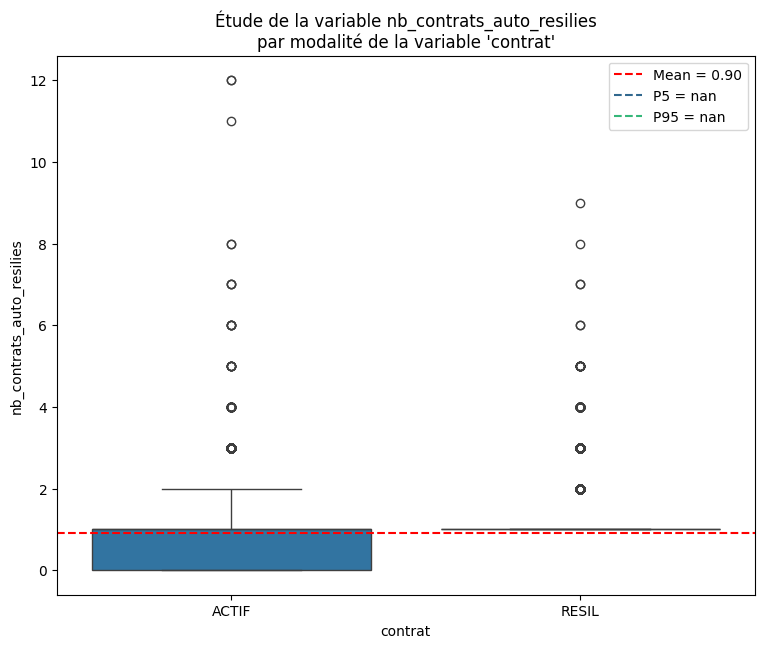

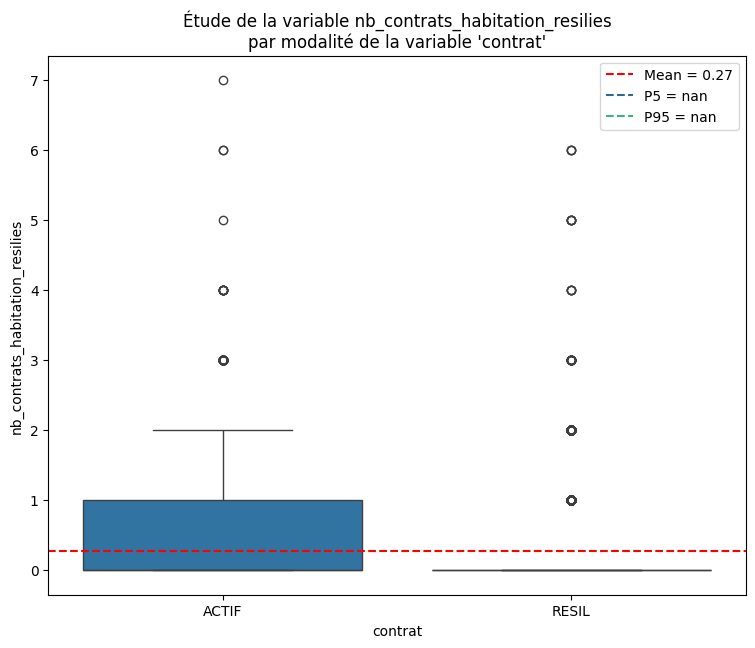

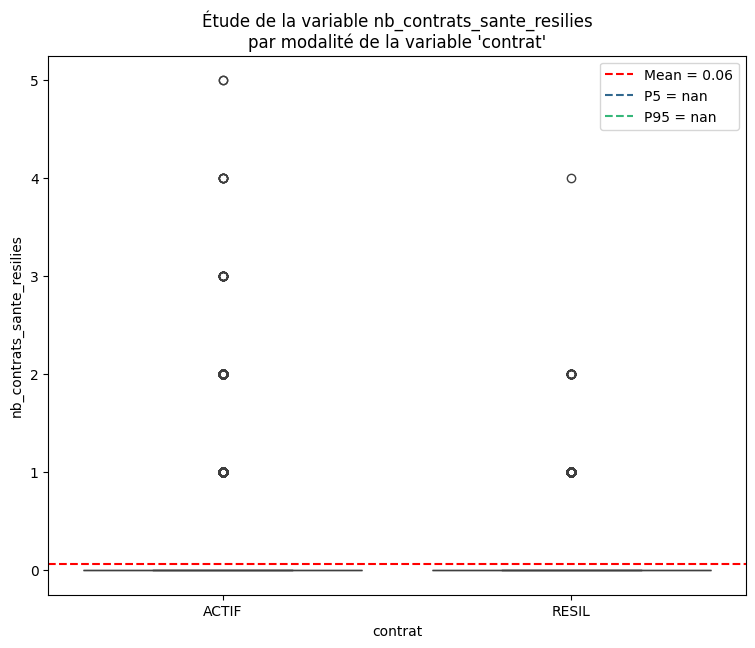

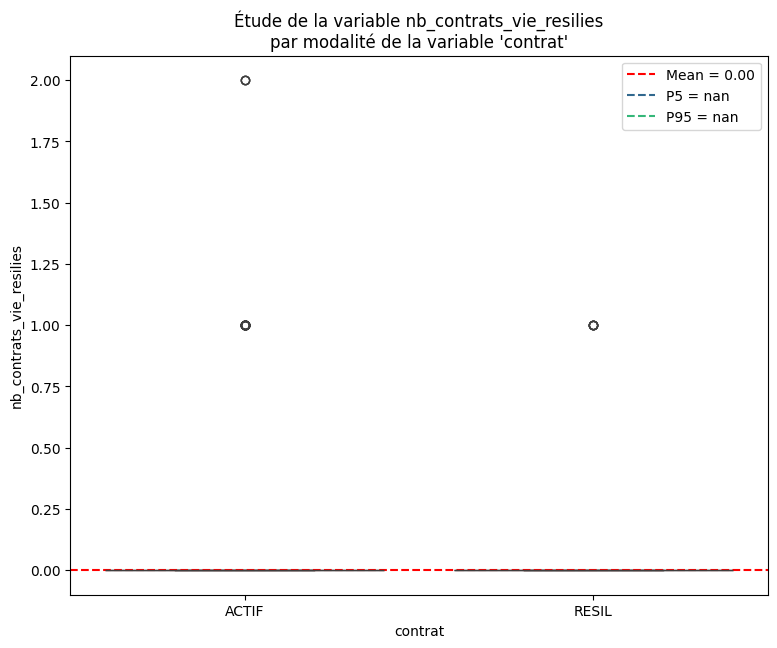

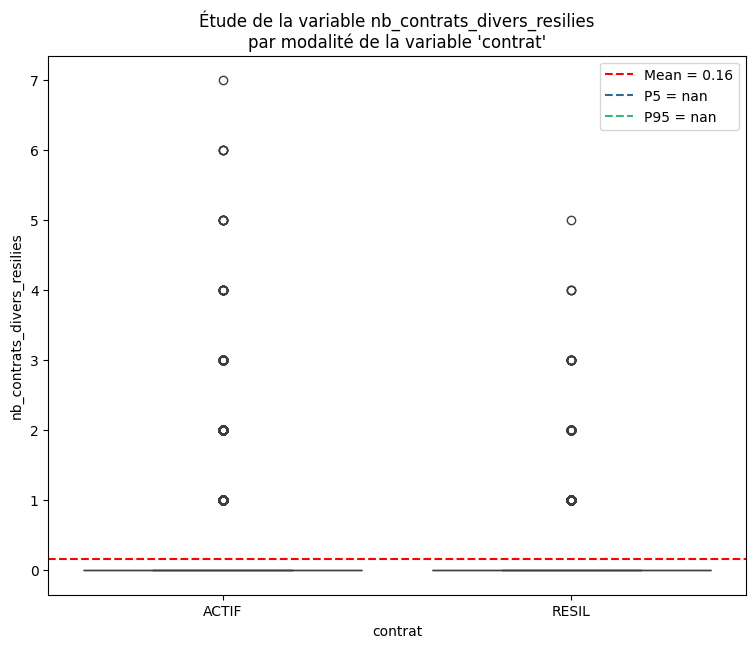

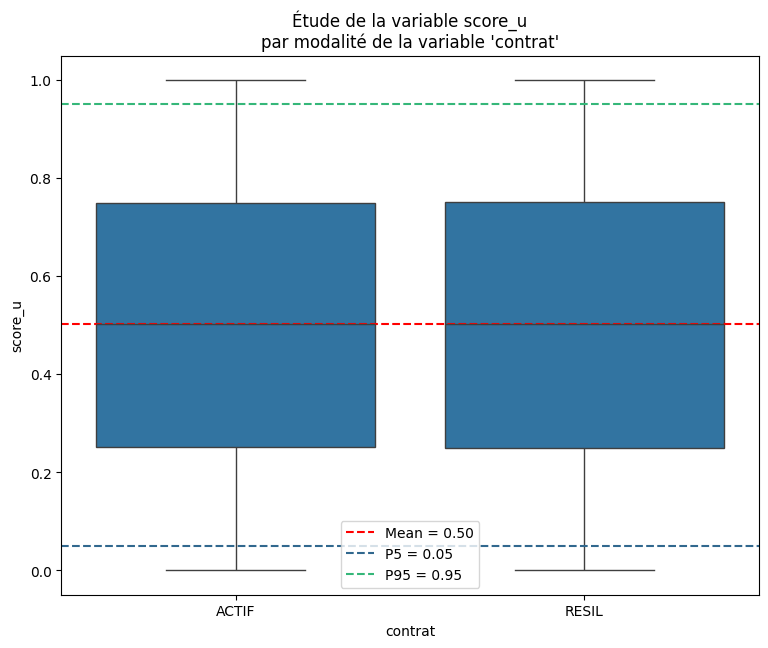

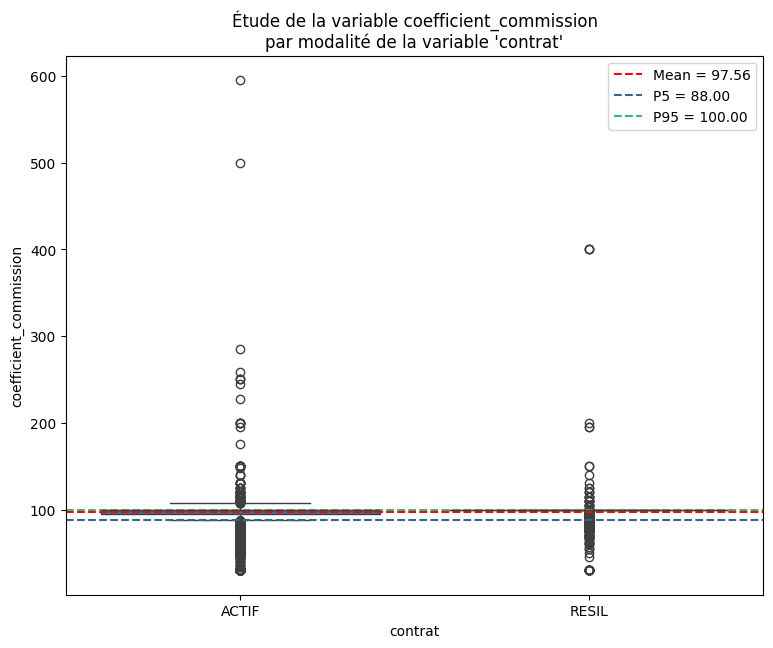

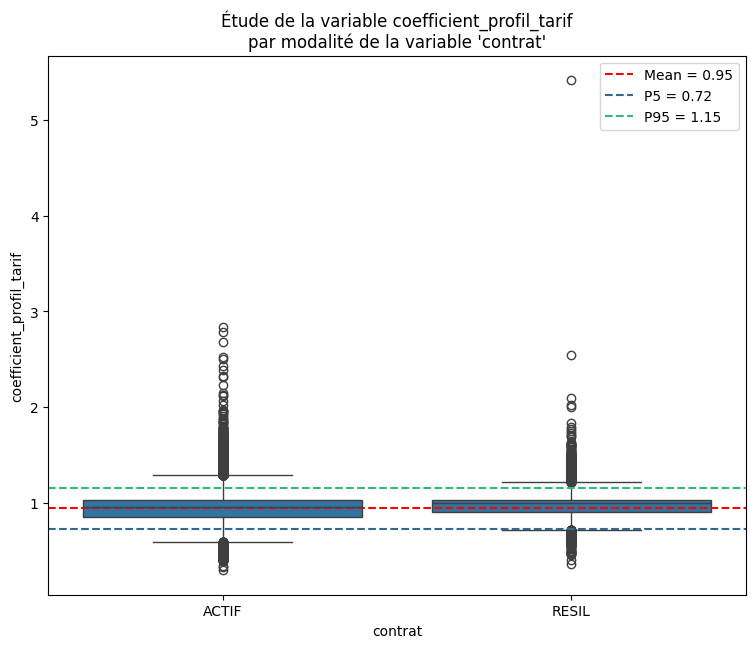

In [ ]:
for field in var_num:
    boxplot_by_target(field,df,"contrat",quantiles=[5,95]) #VOIR POUR CONCATENER LES BOXPLOT

### 2.6 Représentations graphiques avancées (variables continue est catégorielles)

Analyse des taux de défaut en fonction de la variable etat


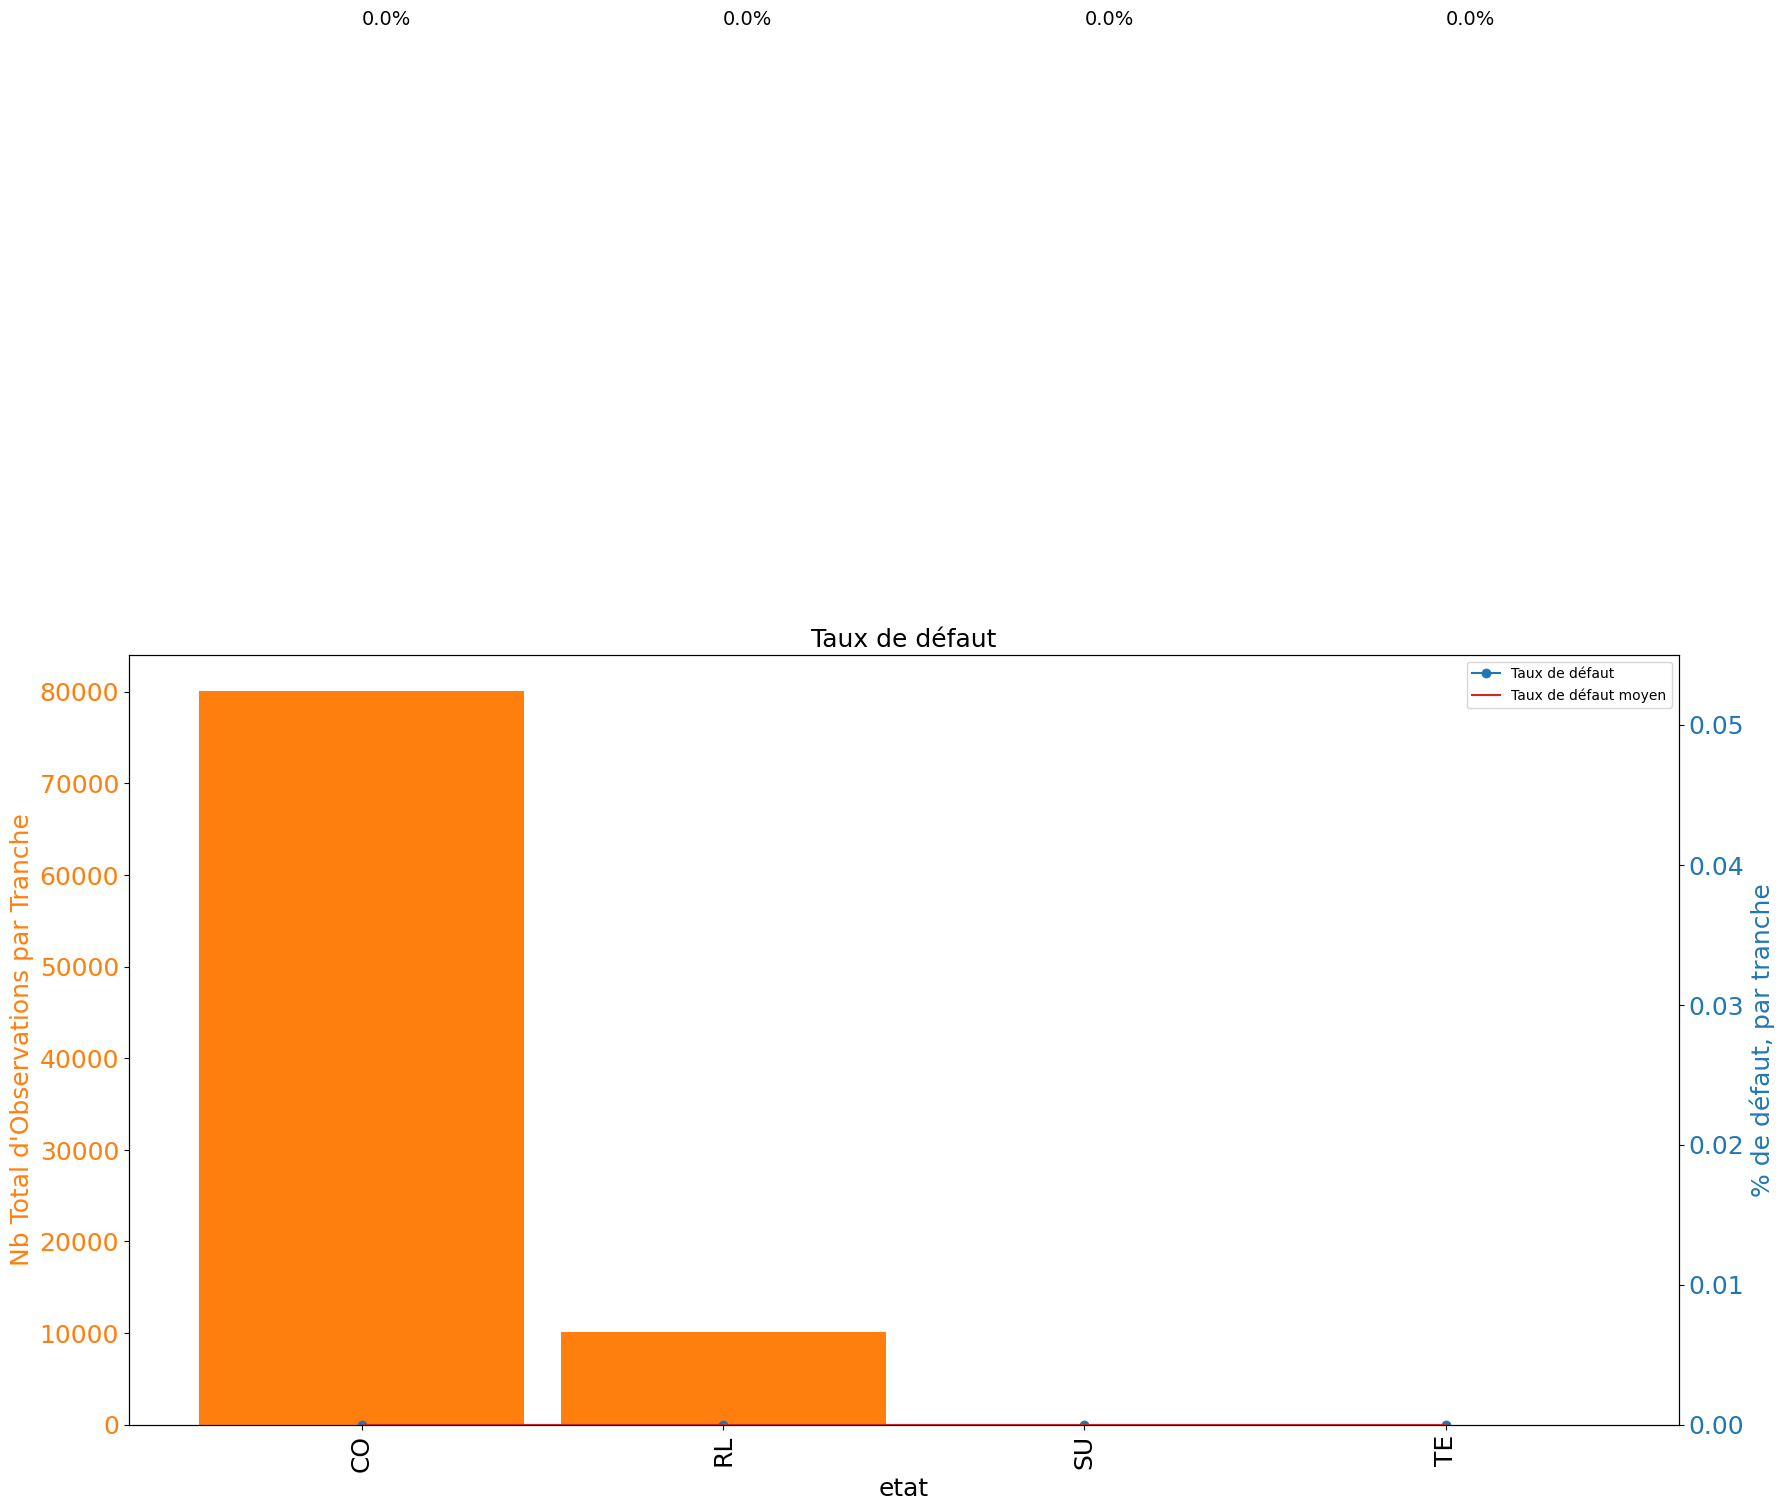

In [ ]:
plot_generic(df,'etat',"contrat", bins=10, force_binning=True)

⚠️ Voir si on fait ça pour d'autre variables importantes. 

## 3. Etude du lien entre variables explicatives et variable cible

Pas forcement très utile pour les modèles à bases d'arbre. Cependant cela reste tres important pour bien comprendre notre base ainsi que nos variables : 
- permet d'avoir un premier a priori sur les facteurs pouvant expliquer la cible (et c'est plus rapide à lancer qu'un modèle)
- permet d'identifier des variables trop "magiques" càd qui expliquent trop bien la cible. Il est possible qu'il s'agissait 
d'un champ construit selon la cible (ex: numéro de contentieux renseigné --> défaut)
- permet de supprimer les variables sans lien avec la cible ce qui permet d'optimiser les temps de calculs (à l'entrainement
mais surtout en production quand le score sera utilisé)

### 3.1. Lien entre les variables explicatives catégorielles

In [ ]:
df_vcramers = cramers_v_between_all(var_cat,df)
df_vcramers

Variable_1               Variable_2  abs_V_cramer  \
50   code_produit_gestion             numero_tarif         1.000   
138           departement                   region         1.000   
108           code_marche                 code_csp         0.970   
62   code_marque_vehicule  libelle_modele_vehicule         0.873   
27             code_agent              departement         0.734   
..                    ...                      ...           ...   
52   code_produit_gestion              code_marche         0.010   
54   code_produit_gestion                     sexe         0.009   
58   code_produit_gestion             client_actif         0.006   
59   code_produit_gestion                     etat         0.006   
150                  etat        motif_resiliation           NaN   

             Chi2 Prob_Chi2  
50   8.998000e+04  < 0.0001  
138  9.004800e+05  < 0.0001  
108  4.757350e+04  < 0.0001  
62   1.602191e+07  < 0.0001  
27   9.460013e+06  < 0.0001  
..            ...       ...  
52   9.677000e+00    0.0849  
54   7.321000e+00    0.1979  
58   3.720000e+00    0.5904  
59   8.430000e+00    0.9054  
150  0.000000e+00       1.0  

[153 rows x 5 columns]

In [ ]:
df_vcramers.sort_values('abs_V_cramer',ascending=False).head(30)

Variable_1               Variable_2  abs_V_cramer  \
50      code_produit_gestion             numero_tarif         1.000   
138              departement                   region         1.000   
108              code_marche                 code_csp         0.970   
62      code_marque_vehicule  libelle_modele_vehicule         0.873   
27                code_agent              departement         0.734   
33              code_formule     code_produit_gestion         0.723   
28                code_agent                   region         0.694   
35              code_formule  libelle_modele_vehicule         0.658   
49      code_produit_gestion  libelle_modele_vehicule         0.654   
147             client_actif                     etat         0.646   
7            code_usage_auto              code_marche         0.605   
34              code_formule     code_marque_vehicule         0.578   
76   libelle_modele_vehicule     rang_valeur_vehicule         0.566   
4            code_usage_auto  libelle_modele_vehicule         0.520   
1            code_usage_auto             code_formule         0.516   
3            code_usage_auto     code_marque_vehicule         0.477   
17                code_agent             code_formule         0.439   
75   libelle_modele_vehicule             numero_tarif         0.435   
2            code_usage_auto     code_produit_gestion         0.424   
48      code_produit_gestion     code_marque_vehicule         0.395   
85   libelle_modele_vehicule        motif_resiliation         0.389   
77   libelle_modele_vehicule              code_marche         0.389   
31                code_agent        motif_resiliation         0.382   
97              numero_tarif                      crm         0.382   
18                code_agent     code_produit_gestion         0.361   
117                 code_csp                     sexe         0.360   
79   libelle_modele_vehicule                     sexe         0.336   
20                code_agent  libelle_modele_vehicule         0.316   
78   libelle_modele_vehicule                 code_csp         0.300   
148             client_actif        motif_resiliation         0.288   

             Chi2 Prob_Chi2  
50   8.998000e+04  < 0.0001  
138  9.004800e+05  < 0.0001  
108  4.757350e+04  < 0.0001  
62   1.602191e+07  < 0.0001  
27   9.460013e+06  < 0.0001  
33   2.344915e+05  < 0.0001  
28   4.336796e+05  < 0.0001  
35   8.933698e+05  < 0.0001  
49   1.925551e+05  < 0.0001  
147  3.770584e+04  < 0.0001  
7    3.298648e+04  < 0.0001  
34   7.193307e+05  < 0.0001  
76   4.907074e+05  < 0.0001  
4    1.485780e+06  < 0.0001  
1    5.740842e+05  < 0.0001  
3    1.434100e+06  < 0.0001  
17   4.158293e+05  < 0.0001  
75   2.722228e+05  < 0.0001  
2    8.099639e+04  < 0.0001  
48   7.025452e+04  < 0.0001  
85   2.124803e+04  < 0.0001  
77   1.366641e+04  < 0.0001  
31   2.054700e+04  < 0.0001  
97   2.098295e+05  < 0.0001  
18   5.892070e+04  < 0.0001  
117  6.545464e+03  < 0.0001  
79   1.016391e+04  < 0.0001  
20   1.124821e+07  < 0.0001  
78   1.057257e+06       1.0  
148  8.327170e+02  < 0.0001

In [ ]:
# lien fort >0.4

💡 CONSTATS ET INTUITIONS : 
------
On remarque directement qu'il faudra garder seulement une variable entre "departement" et "region" (la plus corrélée avec ma cible) -> onb peut supposer qu'on gardera region comme moins de modalités, qu'on recodera. De meme pour "code_produit_gestion" et "numero_tarif".

On remarque aussi que d'autres variables qemble avoir un fort lien que nous devrons traiter.

### 3.2. Lien entre les variables catégorielles et la variable cible

In [ ]:
df_vcramers_target = cramers_v_with_target(var_cat,"contrat",df)
df_vcramers_target

Variable  abs_V_cramer       Chi2 Prob_Chi2
15                     etat         0.995  89339.209  < 0.0001
14             client_actif         0.650  38079.664  < 0.0001
5   libelle_modele_vehicule         0.292   7678.097  < 0.0001
1                code_agent         0.167   2506.438  < 0.0001
6              numero_tarif         0.134   1614.854  < 0.0001
17                      crm         0.129   1504.388  < 0.0001
2              code_formule         0.120   1301.359  < 0.0001
16        motif_resiliation         0.101    101.808  < 0.0001
0           code_usage_auto         0.081    597.038  < 0.0001
9                  code_csp         0.080    327.619  < 0.0001
12              departement         0.068    419.884  < 0.0001
4      code_marque_vehicule         0.058    298.987    0.0304
11      situation_familiale         0.046    193.174  < 0.0001
7      rang_valeur_vehicule         0.045    184.471  < 0.0001
8               code_marche         0.031     85.657  < 0.0001
13                   region         0.025     57.657  < 0.0001
10                     sexe         0.013     16.076    0.0001
3      code_produit_gestion         0.009      8.137    0.1489

💡 CONSTATS ET INTUITIONS : 
------
- On remarque etat (je ne sais pas a quoi cette variable correspond) et client_actif semble tres lié avec la variable cible.

- On remarque que motif_resiliation, code_usage_auto, code_csp, departement, code_marque_vehicule, situation_familiale, rang_valeur_vehicule, code_marche, region, sexe, code_produit_gestion semblent tres peu significatif pour notre modele.

In [ ]:
df['etat'].value_counts()

etat
CO    80031
RL    10170
SU       43
TE        3
Name: count, dtype: int64

### 3.3 Etude du lien entre les variables explicatives continues 

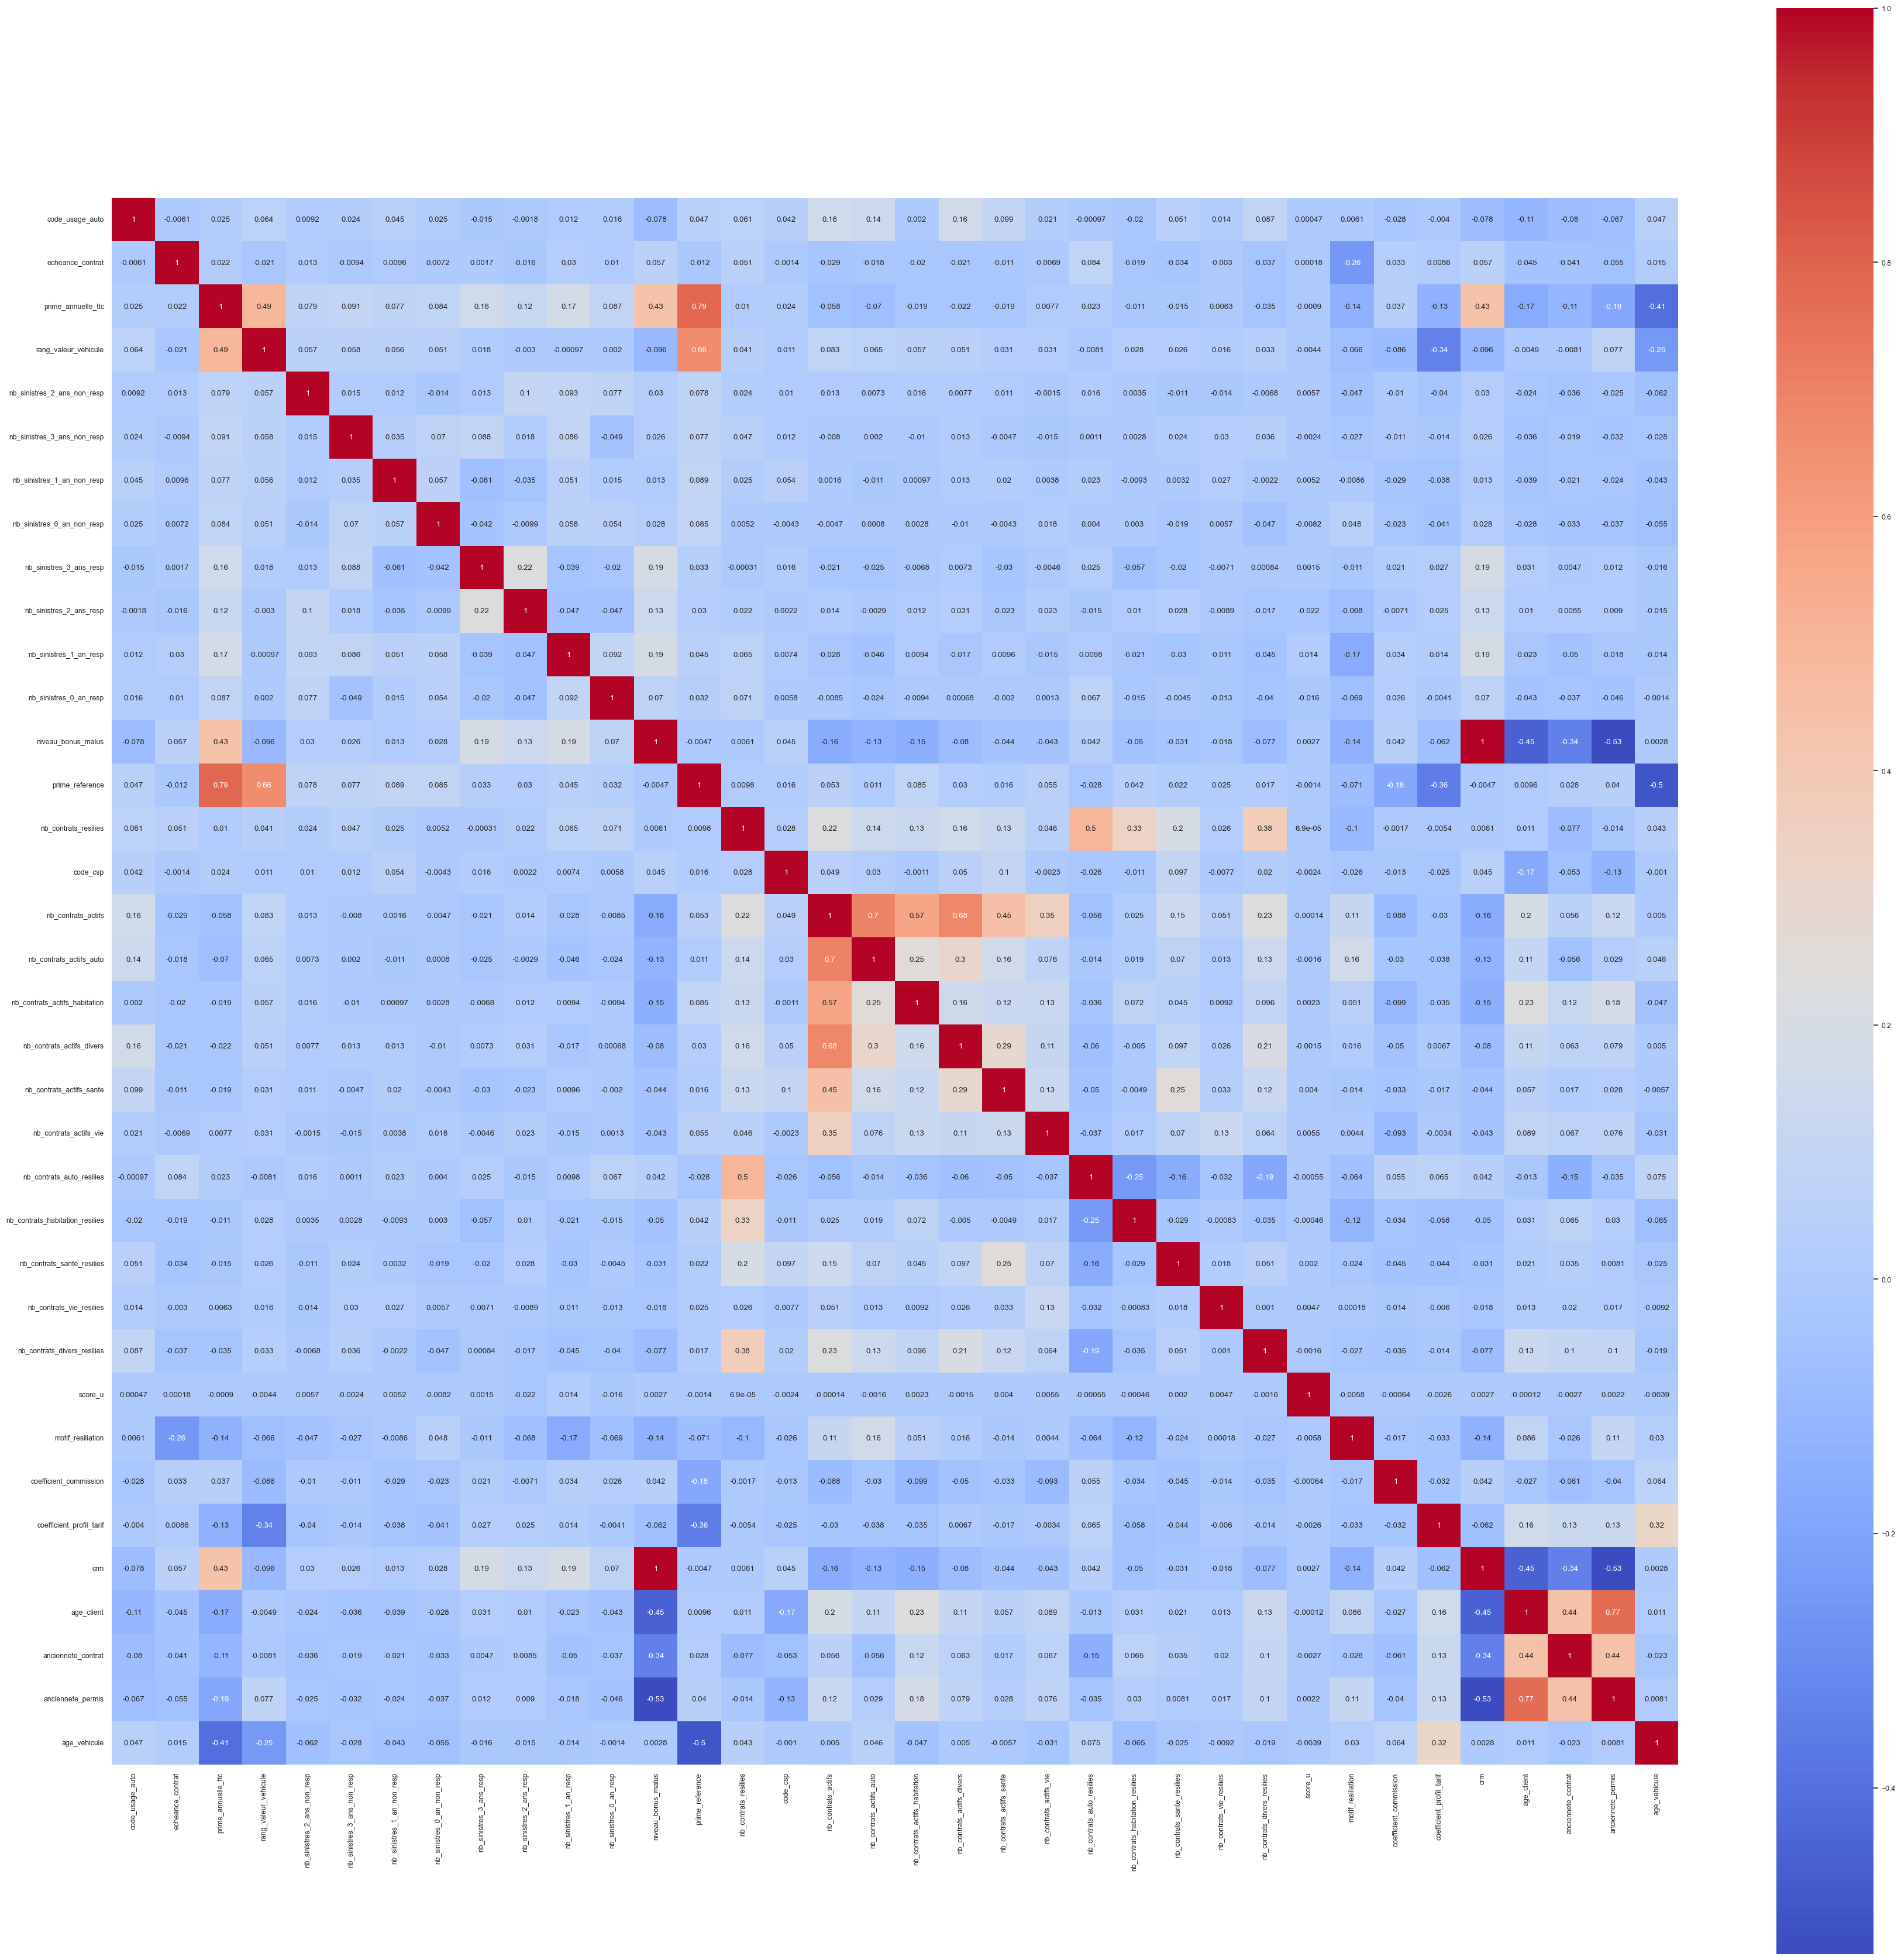

In [76]:
graph_correlations(var_num,df)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90026 entries, 0 to 90246
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   code_usage_auto                  90010 non-null  float64       
 1   code_agent                       90026 non-null  object        
 2   code_formule                     89484 non-null  object        
 3   code_produit_gestion             90026 non-null  object        
 4   date_debut_contrat               90026 non-null  datetime64[ns]
 5   date_dernier_mouvement           90026 non-null  datetime64[ns]
 6   echeance_contrat                 90010 non-null  float64       
 7   prime_annuelle_ttc               90026 non-null  float64       
 8   code_marque_vehicule             89939 non-null  object        
 9   date_obtention_permis            89884 non-null  datetime64[ns]
 10  date_mise_circulation            89097 non-null  datetime64[ns]

In [88]:
df_encoded['contrat'].value_counts()

contrat
ACTIF    79920
RESIL    10106
Name: count, dtype: int64

In [94]:
from scipy.stats import pointbiserialr

df_encoded = df.copy()
df_encoded = df_encoded[df_encoded['contrat'].notna()] #supp nan 
df_encoded['contrat_encoded'] = (df_encoded['contrat'] == 'ACTIF').astype(int)

numerical_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns

strong_corr = {} # on crée un dictionnaire pour stocker les variables avec les valeurs de corrélation

# boucle pour calculer la corrélation point biserial
for col in numerical_cols:
    if col != 'contrat_encoded' and df_encoded[col].notna().sum() > 0: #il faut pas de NaN dans les variables explicatives sinon ça marche pas
        try:
            corr, _ = pointbiserialr(df_encoded['contrat_encoded'], df_encoded[col])
            if abs(corr) > 0.3:
                strong_corr[col] = round(corr, 2)
        except Exception as e:
            continue  


print("Variables corrélées à 'contrat' (> 0.3) :")
print(strong_corr)


Variables corrélées à 'contrat' (> 0.3) :
{'nb_contrats_resilies': -0.45}


💡 CONSTATS ET INTUITIONS : 
------

### 3.4 Lien entre les variables explicatives continues et la variable cible

Application du Welch’s t-test

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> Le Welch’s t-test est un test de Student où on relâche l'hypothèse d'équivariance entre les 2 populations.<br>
H0 : Les distributions de x|y=1 et x|y=0 sont les mêmes (avec x: variable explicative continue, y:variable cible bimodale)
</div>

In [ ]:
for field in var_num:
    a=list(df[df["contrat"]==0][field])
    b=list(df[df["contrat"]==1][field])
    st_test, st_p = st.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')
    print(field + ": p-value test Student = " + str(st_p))

echeance_contrat: p-value test Student = nan
prime_annuelle_ttc: p-value test Student = nan
nb_sinistres_2_ans_non_resp: p-value test Student = nan
nb_sinistres_3_ans_non_resp: p-value test Student = nan
nb_sinistres_1_an_non_resp: p-value test Student = nan
nb_sinistres_0_an_non_resp: p-value test Student = nan
nb_sinistres_3_ans_resp: p-value test Student = nan
nb_sinistres_2_ans_resp: p-value test Student = nan
nb_sinistres_1_an_resp: p-value test Student = nan
nb_sinistres_0_an_resp: p-value test Student = nan
niveau_bonus_malus: p-value test Student = nan
prime_reference: p-value test Student = nan
nb_contrats_resilies: p-value test Student = nan
nb_contrats_actifs: p-value test Student = nan
nb_contrats_actifs_auto: p-value test Student = nan
nb_contrats_actifs_habitation: p-value test Student = nan
nb_contrats_actifs_divers: p-value test Student = nan
nb_contrats_actifs_sante: p-value test Student = nan
nb_contrats_actifs_vie: p-value test Student = nan
nb_contrats_auto_resilies

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


⚠️ revoir 

In [93]:
df['contrat'].value_counts()

contrat
ACTIF    79920
RESIL    10106
Name: count, dtype: int64